# Distributed Asynchronous Hyper-parameter Optimization with NGBoost

## Notes on Hyperopt

Hyperopt will allow us to intelligently narrow our search space over traditional methods like grid search in sklearn and thus save runtime when tuning our NGBoost model.

Original Article:

*Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. To appear in Proc. of the 30th International Conference on Machine Learning (ICML 2013).*

For install instructions and more information on how Hyperopt works click [here](http://hyperopt.github.io/hyperopt/)


## Import Dependencies

In [24]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
from hyperopt import hp, tpe, space_eval
from hyperopt.pyll.base import scope
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK, Trials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging

## Setup basic logging

In [2]:
logging.basicConfig(
    # filename = "errors.log",
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger()

## Load the Boston Housing Dataset

For this example we will be splitting the dataset into train/test/validation sets

In [3]:
b4 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=6)
b4 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=6)
b4 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=6)
boston = load_boston()
data = boston.data
target = boston.target

X_intermediate, X_test, y_intermediate, y_test = train_test_split(data, 
                                                                  target, 
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=1)

# train/validation split (gives us train and validation sets)
X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=1)

# delete intermediate variables
del X_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(target),2),
                                                       round(len(y_validation)/len(target),2),
                                                       round(len(y_test)/len(target),2)))

train: 0.6% | validation: 0.2% | test 0.2%


In [4]:
len(X_train), len(X_validation), len(X_test)

(303, 101, 102)

## Setup the Hyper-Parameters to test

Note:
- hp.choice selects from the provided list
- hp.uniform will iterate at random over the range provided like .05 to 1

In [5]:
b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)
b3 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)
b4 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
b5 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=6)
b6 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=7)
b7 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=8)

space = {
    'learning_rate':hp.uniform('learning_rate', .01, 0.3),
    #'minibatch_frac':hp.choice('minibatch_frac', [1.0, 0.9, 0.8, 0.75, 0.7, 0.6]),
    'minibatch_frac':hp.uniform('minibatch_frac', 0.6, 1.0),
    'Base':hp.choice('Base', [b1, b2, b3, b4, b5, b6, b7]),
    'n_estimators':hp.randint('n_estimators', 40, 70)
    #'n_estimators':hp.choice('n_estimators', [40, 50, 60, 70])
}

default_params = {"verbose_eval":0,
                  "random_state":1}

## Setup the model to be tested and log the loss for each test

Note: This example uses early stopping

This objective will log the loss of the best iteration among each pass (n_estimators) using best_val_loss_itr from the NGBRegressor object

In [6]:
?NGBRegressor

In [7]:
def objective(params):
    
    params.update(default_params)
    
    print(params)
    ngb = NGBRegressor(**params).fit(X_train,y_train,X_val=X_validation, Y_val=y_validation, early_stopping_rounds=4)
    loss = ngb.evals_result['val']['LOGSCORE'][ngb.best_val_loss_itr]
    logger.info(params)
    results = {'loss':loss, 'status':STATUS_OK}
    
    return results

## Run tuning

We can modify max_evals here to adjust how many differnt sets of hyper-parameters we want to test

In [8]:
TRIALS = Trials()
logger.info("Start parameter optimization...")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=1000,
                trials=TRIALS,
                verbose=False)
logger.info("...done")

2021-01-12 23:19:21 INFO     Start parameter optimization...
2021-01-12 23:19:21 INFO     build_posterior_wrapper took 0.001042 seconds
2021-01-12 23:19:21 INFO     TPE using 0 trials
2021-01-12 23:19:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.23786506450223277, 'minibatch_frac': 0.8717073683063697, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:21 INFO     build_posterior_wrapper took 0.001114 seconds
2021-01-12 23:19:21 INFO     TPE using 1/1 trials with best loss 2.517918
2021-01-12 23:19:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.22232891460731707, 'minibatch_frac': 0.9201050400430985, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:21 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:19:21 INFO     TPE using 2/2 trials with best loss 2.517918


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.23786506450223277, 'minibatch_frac': 0.8717073683063697, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5179)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.22232891460731707, 'minibatch_frac': 0.9201050400430985, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.7126)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0759308154854169, 'minibatch_frac': 0.7297017271009606, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0759308154854169, 'minibatch_frac': 0.7297017271009606, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:21 INFO     build_posterior_wrapper took 0.001088 seconds
2021-01-12 23:19:21 INFO     TPE using 3/3 trials with best loss 2.517918


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.6653)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.016675553338377624, 'minibatch_frac': 0.946603310340594, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.016675553338377624, 'minibatch_frac': 0.946603310340594, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:22 INFO     build_posterior_wrapper took 0.001120 seconds
2021-01-12 23:19:22 INFO     TPE using 4/4 trials with best loss 2.517918
2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.2817468810213864, 'minibatch_frac': 0.7575427930277615, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:22 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:19:22 INFO     TPE using 5/5 trials with best loss 2.517918
2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.25646014320351596, 'minibatch_frac': 0.7143783544411573, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.2817468810213864, 'minibatch_frac': 0.7575427930277615, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6807)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.25646014320351596, 'minibatch_frac': 0.7143783544411573, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6350)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07697795303749805, 'minibatch_frac': 0.847317016081856, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07697795303749805, 'minibatch_frac': 0.847317016081856, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:22 INFO     build_posterior_wrapper took 0.001110 seconds
2021-01-12 23:19:22 INFO     TPE using 7/7 trials with best loss 2.473517
2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.23493035042536126, 'minibatch_frac': 0.8633389533000551, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:22 INFO     build_posterior_wrapper took 0.001144 seconds
2021-01-12 23:19:22 INFO     TPE using 8/8 trials with best loss 2.473517
2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2617530954743394, 'minibatch_frac': 0.9668167571017868, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
20

== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4735)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.23493035042536126, 'minibatch_frac': 0.8633389533000551, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6154)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2617530954743394, 'minibatch_frac': 0.9668167571017868, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5984)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.018056991847628462, 'minibatch_frac': 0.7868310182173406, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.018056991847628462, 'minibatch_frac': 0.7868310182173406, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:22 INFO     build_posterior_wrapper took 0.001134 seconds
2021-01-12 23:19:22 INFO     TPE using 10/10 trials with best loss 2.473517
2021-01-12 23:19:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.15961623712853895, 'minibatch_frac': 0.865458299508881, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:22 INFO     build_posterior_wrapper took 0.001120 seconds
2021-01-12 23:19:22 INFO     TPE using 11/11 trials with best loss 2.473517


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.15961623712853895, 'minibatch_frac': 0.865458299508881, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.7165)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07785503334222102, 'minibatch_frac': 0.7986844100171867, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07785503334222102, 'minibatch_frac': 0.7986844100171867, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:23 INFO     build_posterior_wrapper took 0.001648 seconds
2021-01-12 23:19:23 INFO     TPE using 12/12 trials with best loss 2.473517
2021-01-12 23:19:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.28907072015723434, 'minibatch_frac': 0.6618658678825987, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:23 INFO     build_posterior_wrapper took 0.001816 seconds
2021-01-12 23:19:23 INFO     TPE using 13/13 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5329)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.28907072015723434, 'minibatch_frac': 0.6618658678825987, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.7436)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09226976331911262, 'minibatch_frac': 0.7982381519003798, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09226976331911262, 'minibatch_frac': 0.7982381519003798, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:23 INFO     build_posterior_wrapper took 0.001113 seconds
2021-01-12 23:19:23 INFO     TPE using 14/14 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4919)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.03044387190196366, 'minibatch_frac': 0.8040519175925458, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.03044387190196366, 'minibatch_frac': 0.8040519175925458, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:23 INFO     build_posterior_wrapper took 0.001245 seconds
2021-01-12 23:19:23 INFO     TPE using 15/15 trials with best loss 2.473517
2021-01-12 23:19:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.2579624656198756, 'minibatch_frac': 0.8971190279605441, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:23 INFO     build_posterior_wrapper took 0.001163 seconds
2021-01-12 23:19:23 INFO     TPE using 16/16 trials with best loss 2.473517
2021-01-12 23:19:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.22680591661943877, 'minibatch_frac': 0.8994652215558738, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.2579624656198756, 'minibatch_frac': 0.8971190279605441, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6374)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.22680591661943877, 'minibatch_frac': 0.8994652215558738, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6021)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2884286017675134, 'minibatch_frac': 0.6608045489327687, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2884286017675134, 'minibatch_frac': 0.6608045489327687, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:24 INFO     build_posterior_wrapper took 0.001281 seconds
2021-01-12 23:19:24 INFO     TPE using 18/18 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6495)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0448952347201606, 'minibatch_frac': 0.8836064462374942, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0448952347201606, 'minibatch_frac': 0.8836064462374942, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:24 INFO     build_posterior_wrapper took 0.001164 seconds
2021-01-12 23:19:24 INFO     TPE using 19/19 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL49 (val_loss=2.7118)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.06523228423935448, 'minibatch_frac': 0.7273136271923362, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.06523228423935448, 'minibatch_frac': 0.7273136271923362, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:24 INFO     build_posterior_wrapper took 0.001169 seconds
2021-01-12 23:19:24 INFO     TPE using 20/20 trials with best loss 2.473517
2021-01-12 23:19:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11395521140861822, 'minibatch_frac': 0.6011343529382198, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:24 INFO     build_posterior_wrapper took 0.001170 seconds
2021-01-12 23:19:24 INFO     TPE using 21/21 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.5026)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11395521140861822, 'minibatch_frac': 0.6011343529382198, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4998)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14168694246218705, 'minibatch_frac': 0.8303736044918225, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14168694246218705, 'minibatch_frac': 0.8303736044918225, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:24 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:19:24 INFO     TPE using 22/22 trials with best loss 2.473517
2021-01-12 23:19:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15641461180468594, 'minibatch_frac': 0.8383469139574767, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:25 INFO     build_posterior_wrapper took 0.001172 seconds
2021-01-12 23:19:25 INFO     TPE using 23/23 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4781)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15641461180468594, 'minibatch_frac': 0.8383469139574767, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5426)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18546961396187223, 'minibatch_frac': 0.9954907613917151, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18546961396187223, 'minibatch_frac': 0.9954907613917151, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:25 INFO     build_posterior_wrapper took 0.001218 seconds
2021-01-12 23:19:25 INFO     TPE using 24/24 trials with best loss 2.473517
2021-01-12 23:19:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1261086582987074, 'minibatch_frac': 0.8301571760597367, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:25 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:19:25 INFO     TPE using 25/25 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5680)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1261086582987074, 'minibatch_frac': 0.8301571760597367, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4830)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19406384115071992, 'minibatch_frac': 0.9313220041267463, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19406384115071992, 'minibatch_frac': 0.9313220041267463, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:25 INFO     build_posterior_wrapper took 0.001252 seconds
2021-01-12 23:19:25 INFO     TPE using 26/26 trials with best loss 2.473517
2021-01-12 23:19:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11750407263007157, 'minibatch_frac': 0.8322541880712236, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:25 INFO     build_posterior_wrapper took 0.001202 seconds
2021-01-12 23:19:25 INFO     TPE using 27/27 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5307)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11750407263007157, 'minibatch_frac': 0.8322541880712236, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5768)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.133891547798425, 'minibatch_frac': 0.7570802711018957, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.133891547798425, 'minibatch_frac': 0.7570802711018957, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:25 INFO     build_posterior_wrapper took 0.001280 seconds
2021-01-12 23:19:25 INFO     TPE using 28/28 trials with best loss 2.473517
2021-01-12 23:19:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.09836245281487346, 'minibatch_frac': 0.9688628627388598, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:25 INFO     build_posterior_wrapper took 0.001186 seconds
2021-01-12 23:19:25 INFO     TPE using 29/29 trials with best loss 2.473517


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5491)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.09836245281487346, 'minibatch_frac': 0.9688628627388598, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5487)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.052768195984546726, 'minibatch_frac': 0.8500530591917534, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.052768195984546726, 'minibatch_frac': 0.8500530591917534, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:26 INFO     build_posterior_wrapper took 0.001151 seconds
2021-01-12 23:19:26 INFO     TPE using 30/30 trials with best loss 2.465083


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4651)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04908058953315829, 'minibatch_frac': 0.8570393370173193, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04908058953315829, 'minibatch_frac': 0.8570393370173193, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:26 INFO     build_posterior_wrapper took 0.001258 seconds
2021-01-12 23:19:26 INFO     TPE using 31/31 trials with best loss 2.465083


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4732)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.050636886297078056, 'minibatch_frac': 0.9112487104280486, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.050636886297078056, 'minibatch_frac': 0.9112487104280486, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:26 INFO     build_posterior_wrapper took 0.001124 seconds
2021-01-12 23:19:26 INFO     TPE using 32/32 trials with best loss 2.465083


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.4800)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03346072164906634, 'minibatch_frac': 0.7680058348710566, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03346072164906634, 'minibatch_frac': 0.7680058348710566, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:27 INFO     build_posterior_wrapper took 0.001189 seconds
2021-01-12 23:19:27 INFO     TPE using 33/33 trials with best loss 2.465083


== Early stopping achieved.
== Best iteration / VAL44 (val_loss=2.5294)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.013454633631643897, 'minibatch_frac': 0.999568158224366, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.013454633631643897, 'minibatch_frac': 0.999568158224366, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:27 INFO     build_posterior_wrapper took 0.001132 seconds
2021-01-12 23:19:27 INFO     TPE using 34/34 trials with best loss 2.465083


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.05488738379216148, 'minibatch_frac': 0.6882718820702816, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.05488738379216148, 'minibatch_frac': 0.6882718820702816, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:27 INFO     build_posterior_wrapper took 0.001264 seconds
2021-01-12 23:19:27 INFO     TPE using 35/35 trials with best loss 2.465083
2021-01-12 23:19:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.18199845001806148, 'minibatch_frac': 0.9358459499353801, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:27 INFO     build_posterior_wrapper took 0.001100 seconds
2021-01-12 23:19:27 INFO     TPE using 36/36 trials with best loss 2.465083


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.5050)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.18199845001806148, 'minibatch_frac': 0.9358459499353801, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5778)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09755208830790388, 'minibatch_frac': 0.9543960196521633, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09755208830790388, 'minibatch_frac': 0.9543960196521633, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:27 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:19:27 INFO     TPE using 37/37 trials with best loss 2.465083
2021-01-12 23:19:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2086724578677515, 'minibatch_frac': 0.8710423348038248, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:28 INFO     build_posterior_wrapper took 0.001310 seconds
2021-01-12 23:19:28 INFO     TPE using 38/38 trials with best loss 2.465083


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5131)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2086724578677515, 'minibatch_frac': 0.8710423348038248, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5470)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0322320034158606, 'minibatch_frac': 0.7725141517869317, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0322320034158606, 'minibatch_frac': 0.7725141517869317, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:28 INFO     build_posterior_wrapper took 0.001177 seconds
2021-01-12 23:19:28 INFO     TPE using 39/39 trials with best loss 2.465083
2021-01-12 23:19:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06721763954386539, 'minibatch_frac': 0.8502461815993707, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:28 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:19:28 INFO     TPE using 40/40 trials with best loss 2.465083


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06721763954386539, 'minibatch_frac': 0.8502461815993707, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5567)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010422754836005778, 'minibatch_frac': 0.8195001722251404, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010422754836005778, 'minibatch_frac': 0.8195001722251404, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:28 INFO     build_posterior_wrapper took 0.001187 seconds
2021-01-12 23:19:28 INFO     TPE using 41/41 trials with best loss 2.465083
2021-01-12 23:19:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07987958820634092, 'minibatch_frac': 0.9846164778879396, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:29 INFO     build_posterior_wrapper took 0.001838 seconds


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07987958820634092, 'minibatch_frac': 0.9846164778879396, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4890)


2021-01-12 23:19:29 INFO     TPE using 42/42 trials with best loss 2.465083
2021-01-12 23:19:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08900554634426387, 'minibatch_frac': 0.7486091760419701, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:29 INFO     build_posterior_wrapper took 0.001279 seconds
2021-01-12 23:19:29 INFO     TPE using 43/43 trials with best loss 2.443383


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08900554634426387, 'minibatch_frac': 0.7486091760419701, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4434)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.16961824699187328, 'minibatch_frac': 0.6015979273476653, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.16961824699187328, 'minibatch_frac': 0.6015979273476653, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:29 INFO     build_posterior_wrapper took 0.001161 seconds
2021-01-12 23:19:29 INFO     TPE using 44/44 trials with best loss 2.443383
2021-01-12 23:19:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11031956533612355, 'minibatch_frac': 0.6374749963735633, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:29 INFO     build_posterior_wrapper took 0.001131 seconds
2021-01-12 23:19:29 INFO     TPE using 45/45 trials with best loss 2.443383


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.6562)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11031956533612355, 'minibatch_frac': 0.6374749963735633, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.6106)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1442834855536951, 'minibatch_frac': 0.7014277147694433, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1442834855536951, 'minibatch_frac': 0.7014277147694433, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:29 INFO     build_posterior_wrapper took 0.001205 seconds
2021-01-12 23:19:29 INFO     TPE using 46/46 trials with best loss 2.443383
2021-01-12 23:19:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08745780403264101, 'minibatch_frac': 0.7430331867391363, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:29 INFO     build_posterior_wrapper took 0.001134 seconds
2021-01-12 23:19:29 INFO     TPE using 47/47 trials with best loss 2.434319


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.6330)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08745780403264101, 'minibatch_frac': 0.7430331867391363, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4343)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08894985141868886, 'minibatch_frac': 0.7435557383639508, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08894985141868886, 'minibatch_frac': 0.7435557383639508, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:30 INFO     build_posterior_wrapper took 0.001111 seconds
2021-01-12 23:19:30 INFO     TPE using 48/48 trials with best loss 2.434319
2021-01-12 23:19:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10515738887790245, 'minibatch_frac': 0.6769946384932166, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:30 INFO     build_posterior_wrapper took 0.001134 seconds
2021-01-12 23:19:30 INFO     TPE using 49/49 trials with best loss 2.434319


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4537)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10515738887790245, 'minibatch_frac': 0.6769946384932166, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5587)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.12748094753249767, 'minibatch_frac': 0.6386697196375105, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.12748094753249767, 'minibatch_frac': 0.6386697196375105, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:30 INFO     build_posterior_wrapper took 0.001103 seconds
2021-01-12 23:19:30 INFO     TPE using 50/50 trials with best loss 2.434319
2021-01-12 23:19:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06767534603420239, 'minibatch_frac': 0.7236995871626763, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:30 INFO     build_posterior_wrapper took 0.001119 seconds
2021-01-12 23:19:30 INFO     TPE using 51/51 trials with best loss 2.434319


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4891)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06767534603420239, 'minibatch_frac': 0.7236995871626763, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5282)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.27003026798382923, 'minibatch_frac': 0.710736209686289, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.27003026798382923, 'minibatch_frac': 0.710736209686289, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:30 INFO     build_posterior_wrapper took 0.001256 seconds
2021-01-12 23:19:30 INFO     TPE using 52/52 trials with best loss 2.434319
2021-01-12 23:19:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0840278630933632, 'minibatch_frac': 0.747906382627594, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:30 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:19:30 INFO     TPE using 53/53 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6750)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0840278630933632, 'minibatch_frac': 0.747906382627594, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.3996)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.02395849125173513, 'minibatch_frac': 0.8112726470534637, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.02395849125173513, 'minibatch_frac': 0.8112726470534637, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:31 INFO     build_posterior_wrapper took 0.001706 seconds
2021-01-12 23:19:31 INFO     TPE using 54/54 trials with best loss 2.399563
2021-01-12 23:19:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2077981170597638, 'minibatch_frac': 0.7867150633161349, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:31 INFO     build_posterior_wrapper took 0.001240 seconds
2021-01-12 23:19:31 INFO     TPE using 55/55 trials with best loss 2.399563
2021-01-12 23:19:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17103655311696536, 'minibatch_frac': 0.6301623414207711, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2077981170597638, 'minibatch_frac': 0.7867150633161349, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5846)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17103655311696536, 'minibatch_frac': 0.6301623414207711, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6067)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14633691076630462, 'minibatch_frac': 0.6636860306861406, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14633691076630462, 'minibatch_frac': 0.6636860306861406, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:31 INFO     build_posterior_wrapper took 0.001186 seconds
2021-01-12 23:19:31 INFO     TPE using 57/57 trials with best loss 2.399563
2021-01-12 23:19:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.24069183536699768, 'minibatch_frac': 0.7785832680426286, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:31 INFO     build_posterior_wrapper took 0.001162 seconds
2021-01-12 23:19:31 INFO     TPE using 58/58 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5537)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.24069183536699768, 'minibatch_frac': 0.7785832680426286, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6894)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0374825889187748, 'minibatch_frac': 0.7391709091133958, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0374825889187748, 'minibatch_frac': 0.7391709091133958, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:31 INFO     build_posterior_wrapper took 0.001183 seconds
2021-01-12 23:19:31 INFO     TPE using 59/59 trials with best loss 2.399563
2021-01-12 23:19:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0788669780551622, 'minibatch_frac': 0.6973291947228089, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:31 INFO     build_posterior_wrapper took 0.001200 seconds
2021-01-12 23:19:31 INFO     TPE using 60/60 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0788669780551622, 'minibatch_frac': 0.6973291947228089, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5247)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.12045159835521482, 'minibatch_frac': 0.6789621717448217, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.12045159835521482, 'minibatch_frac': 0.6789621717448217, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:32 INFO     build_posterior_wrapper took 0.001137 seconds
2021-01-12 23:19:32 INFO     TPE using 61/61 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5815)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.05941293771773378, 'minibatch_frac': 0.7163198160621951, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.05941293771773378, 'minibatch_frac': 0.7163198160621951, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:32 INFO     build_posterior_wrapper took 0.001244 seconds
2021-01-12 23:19:32 INFO     TPE using 62/62 trials with best loss 2.399563
2021-01-12 23:19:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13606057665931465, 'minibatch_frac': 0.6161841407961003, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:32 INFO     build_posterior_wrapper took 0.001130 seconds
2021-01-12 23:19:32 INFO     TPE using 63/63 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.5670)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13606057665931465, 'minibatch_frac': 0.6161841407961003, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4740)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.15271422951534713, 'minibatch_frac': 0.7575902804652682, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.15271422951534713, 'minibatch_frac': 0.7575902804652682, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:32 INFO     build_posterior_wrapper took 0.001247 seconds
2021-01-12 23:19:32 INFO     TPE using 64/64 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5430)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.04224381803818541, 'minibatch_frac': 0.7941532126657027, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.04224381803818541, 'minibatch_frac': 0.7941532126657027, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:32 INFO     build_posterior_wrapper took 0.001237 seconds
2021-01-12 23:19:32 INFO     TPE using 65/65 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL37 (val_loss=2.5119)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08755892610387046, 'minibatch_frac': 0.7378057922391024, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08755892610387046, 'minibatch_frac': 0.7378057922391024, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:33 INFO     build_posterior_wrapper took 0.001405 seconds
2021-01-12 23:19:33 INFO     TPE using 66/66 trials with best loss 2.399563
2021-01-12 23:19:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10137751220704921, 'minibatch_frac': 0.7548910534778593, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:33 INFO     build_posterior_wrapper took 0.001284 seconds
2021-01-12 23:19:33 INFO     TPE using 67/67 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.6394)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10137751220704921, 'minibatch_frac': 0.7548910534778593, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4680)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.08401623186959482, 'minibatch_frac': 0.8828292331922447, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.08401623186959482, 'minibatch_frac': 0.8828292331922447, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:33 INFO     build_posterior_wrapper took 0.001185 seconds
2021-01-12 23:19:33 INFO     TPE using 68/68 trials with best loss 2.399563
2021-01-12 23:19:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11000294750786298, 'minibatch_frac': 0.6572003273551528, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:33 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:19:33 INFO     TPE using 69/69 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5002)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11000294750786298, 'minibatch_frac': 0.6572003273551528, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4445)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.06971392397846005, 'minibatch_frac': 0.7512854032599108, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.06971392397846005, 'minibatch_frac': 0.7512854032599108, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:33 INFO     build_posterior_wrapper took 0.001154 seconds
2021-01-12 23:19:33 INFO     TPE using 70/70 trials with best loss 2.399563
2021-01-12 23:19:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09361382607429149, 'minibatch_frac': 0.8113874844116259, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:34 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:19:34 INFO     TPE using 71/71 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4645)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09361382607429149, 'minibatch_frac': 0.8113874844116259, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4890)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.02545511121118356, 'minibatch_frac': 0.7679475215655509, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.02545511121118356, 'minibatch_frac': 0.7679475215655509, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:34 INFO     build_posterior_wrapper took 0.001096 seconds
2021-01-12 23:19:34 INFO     TPE using 72/72 trials with best loss 2.399563
2021-01-12 23:19:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16422227319394356, 'minibatch_frac': 0.7313496741853006, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:34 INFO     build_posterior_wrapper took 0.001127 seconds
2021-01-12 23:19:34 INFO     TPE using 73/73 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16422227319394356, 'minibatch_frac': 0.7313496741853006, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5222)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11853802204370484, 'minibatch_frac': 0.7162184061110182, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11853802204370484, 'minibatch_frac': 0.7162184061110182, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:34 INFO     build_posterior_wrapper took 0.001145 seconds
2021-01-12 23:19:34 INFO     TPE using 74/74 trials with best loss 2.399563
2021-01-12 23:19:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.12749719906132584, 'minibatch_frac': 0.7821195159894183, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:34 INFO     build_posterior_wrapper took 0.001224 seconds
2021-01-12 23:19:34 INFO     TPE using 75/75 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4560)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.12749719906132584, 'minibatch_frac': 0.7821195159894183, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.7063)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.0730946309417337, 'minibatch_frac': 0.7948609645632256, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.0730946309417337, 'minibatch_frac': 0.7948609645632256, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:35 INFO     build_posterior_wrapper took 0.001147 seconds
2021-01-12 23:19:35 INFO     TPE using 76/76 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4909)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.019812457784983847, 'minibatch_frac': 0.6925632341160773, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.019812457784983847, 'minibatch_frac': 0.6925632341160773, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:35 INFO     build_posterior_wrapper took 0.001199 seconds
2021-01-12 23:19:35 INFO     TPE using 77/77 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.061033637150311626, 'minibatch_frac': 0.8410921971034964, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.061033637150311626, 'minibatch_frac': 0.8410921971034964, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:35 INFO     build_posterior_wrapper took 0.001102 seconds
2021-01-12 23:19:35 INFO     TPE using 78/78 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.5664)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.058155834658034616, 'minibatch_frac': 0.6748700975982582, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.058155834658034616, 'minibatch_frac': 0.6748700975982582, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:36 INFO     build_posterior_wrapper took 0.001169 seconds
2021-01-12 23:19:36 INFO     TPE using 79/79 trials with best loss 2.399563
2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.13504713292085535, 'minibatch_frac': 0.7069777309395453, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:36 INFO     build_posterior_wrapper took 0.001330 seconds
2021-01-12 23:19:36 INFO     TPE using 80/80 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4777)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.13504713292085535, 'minibatch_frac': 0.7069777309395453, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5969)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.046681591321242846, 'minibatch_frac': 0.6542222811368666, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.046681591321242846, 'minibatch_frac': 0.6542222811368666, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:36 INFO     build_posterior_wrapper took 0.001328 seconds
2021-01-12 23:19:36 INFO     TPE using 81/81 trials with best loss 2.399563
2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1869092051708506, 'minibatch_frac': 0.8257884704954993, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:36 INFO     build_posterior_wrapper took 0.001161 seconds
2021-01-12 23:19:36 INFO     TPE using 82/82 trials with best loss 2.399563
2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2442843223092541, 'minibatch_frac': 0.9086059265283792, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 

== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4585)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1869092051708506, 'minibatch_frac': 0.8257884704954993, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4289)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2442843223092541, 'minibatch_frac': 0.9086059265283792, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6055)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.20013781927902938, 'minibatch_frac': 0.8212394961102073, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.20013781927902938, 'minibatch_frac': 0.8212394961102073, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:36 INFO     build_posterior_wrapper took 0.001242 seconds
2021-01-12 23:19:36 INFO     TPE using 84/84 trials with best loss 2.399563
2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1809682126346474, 'minibatch_frac': 0.8918653745937701, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:36 INFO     build_posterior_wrapper took 0.001105 seconds
2021-01-12 23:19:36 INFO     TPE using 85/85 trials with best loss 2.399563
2021-01-12 23:19:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2723942900326016, 'minibatch_frac': 0.7636679611640423, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1

== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6288)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1809682126346474, 'minibatch_frac': 0.8918653745937701, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5403)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2723942900326016, 'minibatch_frac': 0.7636679611640423, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.8166)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18901112399706663, 'minibatch_frac': 0.8196304647430651, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18901112399706663, 'minibatch_frac': 0.8196304647430651, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001264 seconds
2021-01-12 23:19:37 INFO     TPE using 87/87 trials with best loss 2.399563
2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17369132341437324, 'minibatch_frac': 0.8666329701909733, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001171 seconds
2021-01-12 23:19:37 INFO     TPE using 88/88 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5632)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17369132341437324, 'minibatch_frac': 0.8666329701909733, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5359)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.22209839472537007, 'minibatch_frac': 0.8061397998313772, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.22209839472537007, 'minibatch_frac': 0.8061397998313772, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001369 seconds
2021-01-12 23:19:37 INFO     TPE using 89/89 trials with best loss 2.399563
2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.2494607867955338, 'minibatch_frac': 0.8564033844491342, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001135 seconds
2021-01-12 23:19:37 INFO     TPE using 90/90 trials with best loss 2.399563
2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23211305095379844, 'minibatch_frac': 0.923583334411506, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1

== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.6079)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.2494607867955338, 'minibatch_frac': 0.8564033844491342, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6865)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23211305095379844, 'minibatch_frac': 0.923583334411506, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5865)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19690970667461516, 'minibatch_frac': 0.8395648585995905, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19690970667461516, 'minibatch_frac': 0.8395648585995905, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001251 seconds
2021-01-12 23:19:37 INFO     TPE using 92/92 trials with best loss 2.399563
2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.22086107784199005, 'minibatch_frac': 0.7244946796001631, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001216 seconds
2021-01-12 23:19:37 INFO     TPE using 93/93 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6207)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.22086107784199005, 'minibatch_frac': 0.7244946796001631, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6290)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.15403221641295073, 'minibatch_frac': 0.880371579538577, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.15403221641295073, 'minibatch_frac': 0.880371579538577, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001136 seconds
2021-01-12 23:19:37 INFO     TPE using 94/94 trials with best loss 2.399563
2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2994096435661854, 'minibatch_frac': 0.9481303068039496, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:19:37 INFO     TPE using 95/95 trials with best loss 2.399563
2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2116172143074936, 'minibatch_frac': 0.6878046710112394, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}

== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4692)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2994096435661854, 'minibatch_frac': 0.9481303068039496, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6745)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2116172143074936, 'minibatch_frac': 0.6878046710112394, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.6699)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.16487396451558647, 'minibatch_frac': 0.7757271003202215, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.16487396451558647, 'minibatch_frac': 0.7757271003202215, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:37 INFO     build_posterior_wrapper took 0.001271 seconds
2021-01-12 23:19:37 INFO     TPE using 97/97 trials with best loss 2.399563
2021-01-12 23:19:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14812368726622263, 'minibatch_frac': 0.7862833505218975, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:38 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:19:38 INFO     TPE using 98/98 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4957)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14812368726622263, 'minibatch_frac': 0.7862833505218975, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5658)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10906057137436481, 'minibatch_frac': 0.8278480429065569, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10906057137436481, 'minibatch_frac': 0.8278480429065569, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:38 INFO     build_posterior_wrapper took 0.001143 seconds
2021-01-12 23:19:38 INFO     TPE using 99/99 trials with best loss 2.399563
2021-01-12 23:19:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12236264047605558, 'minibatch_frac': 0.8017203964969974, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:38 INFO     build_posterior_wrapper took 0.001103 seconds
2021-01-12 23:19:38 INFO     TPE using 100/100 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5183)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12236264047605558, 'minibatch_frac': 0.8017203964969974, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5317)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17563769227005374, 'minibatch_frac': 0.7353204074278996, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17563769227005374, 'minibatch_frac': 0.7353204074278996, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:38 INFO     build_posterior_wrapper took 0.001115 seconds
2021-01-12 23:19:38 INFO     TPE using 101/101 trials with best loss 2.399563
2021-01-12 23:19:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09808453086372838, 'minibatch_frac': 0.7656189196136965, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:38 INFO     build_posterior_wrapper took 0.001181 seconds
2021-01-12 23:19:38 INFO     TPE using 102/102 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5478)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09808453086372838, 'minibatch_frac': 0.7656189196136965, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4483)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13722183604621024, 'minibatch_frac': 0.7458365788923574, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13722183604621024, 'minibatch_frac': 0.7458365788923574, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:38 INFO     build_posterior_wrapper took 0.001378 seconds
2021-01-12 23:19:38 INFO     TPE using 103/103 trials with best loss 2.399563
2021-01-12 23:19:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.20280630527448604, 'minibatch_frac': 0.8574800041546751, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:38 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:19:38 INFO     TPE using 104/104 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5414)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.20280630527448604, 'minibatch_frac': 0.8574800041546751, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6186)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10547592567719463, 'minibatch_frac': 0.701014333803087, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10547592567719463, 'minibatch_frac': 0.701014333803087, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:39 INFO     build_posterior_wrapper took 0.001211 seconds
2021-01-12 23:19:39 INFO     TPE using 105/105 trials with best loss 2.399563
2021-01-12 23:19:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16083106332892286, 'minibatch_frac': 0.6465181933949823, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:39 INFO     build_posterior_wrapper took 0.001279 seconds
2021-01-12 23:19:39 INFO     TPE using 106/106 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5374)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16083106332892286, 'minibatch_frac': 0.6465181933949823, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.8243)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03803892318409055, 'minibatch_frac': 0.6141950095892045, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03803892318409055, 'minibatch_frac': 0.6141950095892045, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:39 INFO     build_posterior_wrapper took 0.001146 seconds
2021-01-12 23:19:39 INFO     TPE using 107/107 trials with best loss 2.399563
2021-01-12 23:19:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1908389619382356, 'minibatch_frac': 0.6703355997024412, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:39 INFO     build_posterior_wrapper took 0.001287 seconds
2021-01-12 23:19:39 INFO     TPE using 108/108 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL42 (val_loss=2.4867)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1908389619382356, 'minibatch_frac': 0.6703355997024412, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6019)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.1287456311645059, 'minibatch_frac': 0.7941266638370624, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.1287456311645059, 'minibatch_frac': 0.7941266638370624, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:39 INFO     build_posterior_wrapper took 0.001275 seconds
2021-01-12 23:19:39 INFO     TPE using 109/109 trials with best loss 2.399563
2021-01-12 23:19:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11545189400108627, 'minibatch_frac': 0.9743085154648878, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:39 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:19:39 INFO     TPE using 110/110 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5533)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11545189400108627, 'minibatch_frac': 0.9743085154648878, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5002)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08354277738291153, 'minibatch_frac': 0.81167024041925, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08354277738291153, 'minibatch_frac': 0.81167024041925, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:40 INFO     build_posterior_wrapper took 0.001212 seconds
2021-01-12 23:19:40 INFO     TPE using 111/111 trials with best loss 2.399563
2021-01-12 23:19:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.21419918484110886, 'minibatch_frac': 0.6835202344612868, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:40 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:19:40 INFO     TPE using 112/112 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5266)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.21419918484110886, 'minibatch_frac': 0.6835202344612868, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5569)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07616273218775099, 'minibatch_frac': 0.9042775909514914, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07616273218775099, 'minibatch_frac': 0.9042775909514914, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:40 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:19:40 INFO     TPE using 113/113 trials with best loss 2.399563
2021-01-12 23:19:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09224468201737551, 'minibatch_frac': 0.845219219923983, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:40 INFO     build_posterior_wrapper took 0.001134 seconds
2021-01-12 23:19:40 INFO     TPE using 114/114 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4731)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09224468201737551, 'minibatch_frac': 0.845219219923983, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4806)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.011022226274387398, 'minibatch_frac': 0.7191565072631212, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.011022226274387398, 'minibatch_frac': 0.7191565072631212, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:40 INFO     build_posterior_wrapper took 0.001215 seconds
2021-01-12 23:19:40 INFO     TPE using 115/115 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.02610962354222169, 'minibatch_frac': 0.624641358730657, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.02610962354222169, 'minibatch_frac': 0.624641358730657, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:41 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:19:41 INFO     TPE using 116/116 trials with best loss 2.399563
2021-01-12 23:19:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14100371153192515, 'minibatch_frac': 0.7597644723347083, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:41 INFO     build_posterior_wrapper took 0.001312 seconds
2021-01-12 23:19:41 INFO     TPE using 117/117 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14100371153192515, 'minibatch_frac': 0.7597644723347083, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4991)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.231830051250709, 'minibatch_frac': 0.8730059338733862, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.231830051250709, 'minibatch_frac': 0.8730059338733862, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:41 INFO     build_posterior_wrapper took 0.001308 seconds
2021-01-12 23:19:41 INFO     TPE using 118/118 trials with best loss 2.399563
2021-01-12 23:19:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.2613972398805187, 'minibatch_frac': 0.77272946493493, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:41 INFO     build_posterior_wrapper took 0.001248 seconds
2021-01-12 23:19:41 INFO     TPE using 119/119 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5586)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.2613972398805187, 'minibatch_frac': 0.77272946493493, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6607)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.18060416013788302, 'minibatch_frac': 0.7080549505499097, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.18060416013788302, 'minibatch_frac': 0.7080549505499097, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:41 INFO     build_posterior_wrapper took 0.001228 seconds
2021-01-12 23:19:41 INFO     TPE using 120/120 trials with best loss 2.399563
2021-01-12 23:19:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2786367784405697, 'minibatch_frac': 0.826238505275497, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:41 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:19:41 INFO     TPE using 121/121 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5665)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2786367784405697, 'minibatch_frac': 0.826238505275497, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6225)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.052853970573623586, 'minibatch_frac': 0.917166207220419, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.052853970573623586, 'minibatch_frac': 0.917166207220419, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:42 INFO     build_posterior_wrapper took 0.001220 seconds
2021-01-12 23:19:42 INFO     TPE using 122/122 trials with best loss 2.399563
2021-01-12 23:19:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14830822647052586, 'minibatch_frac': 0.8930055669221423, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:42 INFO     build_posterior_wrapper took 0.001248 seconds
2021-01-12 23:19:42 INFO     TPE using 123/123 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.5142)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14830822647052586, 'minibatch_frac': 0.8930055669221423, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5047)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.062035104815248876, 'minibatch_frac': 0.7439475382745794, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.062035104815248876, 'minibatch_frac': 0.7439475382745794, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:42 INFO     build_posterior_wrapper took 0.001179 seconds
2021-01-12 23:19:42 INFO     TPE using 124/124 trials with best loss 2.399563
2021-01-12 23:19:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07167621092097214, 'minibatch_frac': 0.7261746529090612, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:42 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:19:42 INFO     TPE using 125/125 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.5088)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07167621092097214, 'minibatch_frac': 0.7261746529090612, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4707)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1311751762692101, 'minibatch_frac': 0.8325776402329792, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1311751762692101, 'minibatch_frac': 0.8325776402329792, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:42 INFO     build_posterior_wrapper took 0.001111 seconds
2021-01-12 23:19:42 INFO     TPE using 126/126 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.7383)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.016285796026167823, 'minibatch_frac': 0.7911831768260547, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.016285796026167823, 'minibatch_frac': 0.7911831768260547, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:43 INFO     build_posterior_wrapper took 0.001177 seconds
2021-01-12 23:19:43 INFO     TPE using 127/127 trials with best loss 2.399563
2021-01-12 23:19:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.24911475569854058, 'minibatch_frac': 0.8070852115526534, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:43 INFO     build_posterior_wrapper took 0.001179 seconds
2021-01-12 23:19:43 INFO     TPE using 128/128 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.24911475569854058, 'minibatch_frac': 0.8070852115526534, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6841)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04277427789166084, 'minibatch_frac': 0.6689302433340253, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04277427789166084, 'minibatch_frac': 0.6689302433340253, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:43 INFO     build_posterior_wrapper took 0.001109 seconds
2021-01-12 23:19:43 INFO     TPE using 129/129 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.4318)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.034155687337227514, 'minibatch_frac': 0.6019031672592021, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.034155687337227514, 'minibatch_frac': 0.6019031672592021, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:43 INFO     build_posterior_wrapper took 0.001132 seconds
2021-01-12 23:19:43 INFO     TPE using 130/130 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04367709910028719, 'minibatch_frac': 0.639217787576529, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04367709910028719, 'minibatch_frac': 0.639217787576529, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:44 INFO     build_posterior_wrapper took 0.001155 seconds
2021-01-12 23:19:44 INFO     TPE using 131/131 trials with best loss 2.399563
2021-01-12 23:19:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16771300670795306, 'minibatch_frac': 0.6461954896297495, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:44 INFO     build_posterior_wrapper took 0.001107 seconds
2021-01-12 23:19:44 INFO     TPE using 132/132 trials with best loss 2.399563
2021-01-12 23:19:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15755936592398095, 'minibatch_frac': 0.9285870987068845, 'n_estimators': 61, 'verbose_eval': 0, 'random_stat

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16771300670795306, 'minibatch_frac': 0.6461954896297495, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6037)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15755936592398095, 'minibatch_frac': 0.9285870987068845, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.6179)


2021-01-12 23:19:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2995361232301025, 'minibatch_frac': 0.6184674973433444, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:44 INFO     build_posterior_wrapper took 0.001113 seconds
2021-01-12 23:19:44 INFO     TPE using 134/134 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2995361232301025, 'minibatch_frac': 0.6184674973433444, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6942)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.01957875556272096, 'minibatch_frac': 0.6046373602060454, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.01957875556272096, 'minibatch_frac': 0.6046373602060454, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:44 INFO     build_posterior_wrapper took 0.001191 seconds
2021-01-12 23:19:44 INFO     TPE using 135/135 trials with best loss 2.399563
2021-01-12 23:19:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10129353821264409, 'minibatch_frac': 0.8770290221023584, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:45 INFO     build_posterior_wrapper took 0.001314 seconds
2021-01-12 23:19:45 INFO     TPE using 136/136 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10129353821264409, 'minibatch_frac': 0.8770290221023584, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4887)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04973322957450352, 'minibatch_frac': 0.9600223450804972, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04973322957450352, 'minibatch_frac': 0.9600223450804972, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:45 INFO     build_posterior_wrapper took 0.001130 seconds
2021-01-12 23:19:45 INFO     TPE using 137/137 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.5518)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.029192336215455972, 'minibatch_frac': 0.6388132150401309, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.029192336215455972, 'minibatch_frac': 0.6388132150401309, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:45 INFO     build_posterior_wrapper took 0.001151 seconds
2021-01-12 23:19:45 INFO     TPE using 138/138 trials with best loss 2.399563
2021-01-12 23:19:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18638001609427765, 'minibatch_frac': 0.69424098373792, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:45 INFO     build_posterior_wrapper took 0.001125 seconds
2021-01-12 23:19:45 INFO     TPE using 139/139 trials with best loss 2.399563
2021-01-12 23:19:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.20521903576499173, 'minibatch_frac': 0.887297863786201, 'n_estimators': 44, 'verbose_eval': 0, 'random_state

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18638001609427765, 'minibatch_frac': 0.69424098373792, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6470)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.20521903576499173, 'minibatch_frac': 0.887297863786201, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5703)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.040504683525737606, 'minibatch_frac': 0.8624269594695716, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.040504683525737606, 'minibatch_frac': 0.8624269594695716, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:46 INFO     build_posterior_wrapper took 0.001255 seconds
2021-01-12 23:19:46 INFO     TPE using 141/141 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL36 (val_loss=2.4893)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06317457429955714, 'minibatch_frac': 0.6489478029036894, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06317457429955714, 'minibatch_frac': 0.6489478029036894, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:46 INFO     build_posterior_wrapper took 0.001416 seconds
2021-01-12 23:19:46 INFO     TPE using 142/142 trials with best loss 2.399563
2021-01-12 23:19:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1117918922315654, 'minibatch_frac': 0.6621486939675967, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:46 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:19:46 INFO     TPE using 143/143 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4773)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1117918922315654, 'minibatch_frac': 0.6621486939675967, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5044)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.28647265926428667, 'minibatch_frac': 0.9917599420236277, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.28647265926428667, 'minibatch_frac': 0.9917599420236277, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:46 INFO     build_posterior_wrapper took 0.001200 seconds
2021-01-12 23:19:46 INFO     TPE using 144/144 trials with best loss 2.399563
2021-01-12 23:19:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19402955325314086, 'minibatch_frac': 0.7795807472851968, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:46 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:19:46 INFO     TPE using 145/145 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5965)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19402955325314086, 'minibatch_frac': 0.7795807472851968, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.7532)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04380255589227735, 'minibatch_frac': 0.671924354159218, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04380255589227735, 'minibatch_frac': 0.671924354159218, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:47 INFO     build_posterior_wrapper took 0.001208 seconds
2021-01-12 23:19:47 INFO     TPE using 146/146 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4405)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06843762644754099, 'minibatch_frac': 0.7026614892187754, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06843762644754099, 'minibatch_frac': 0.7026614892187754, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:47 INFO     build_posterior_wrapper took 0.001559 seconds
2021-01-12 23:19:47 INFO     TPE using 147/147 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5289)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010420596679062366, 'minibatch_frac': 0.6387233474470115, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010420596679062366, 'minibatch_frac': 0.6387233474470115, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:47 INFO     build_posterior_wrapper took 0.001164 seconds
2021-01-12 23:19:47 INFO     TPE using 148/148 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05353701064042676, 'minibatch_frac': 0.6244177527657074, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05353701064042676, 'minibatch_frac': 0.6244177527657074, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:47 INFO     build_posterior_wrapper took 0.001102 seconds
2021-01-12 23:19:47 INFO     TPE using 149/149 trials with best loss 2.399563
2021-01-12 23:19:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.21765094401122959, 'minibatch_frac': 0.6647469647661889, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:47 INFO     build_posterior_wrapper took 0.001107 seconds
2021-01-12 23:19:47 INFO     TPE using 150/150 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.5495)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.21765094401122959, 'minibatch_frac': 0.6647469647661889, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6294)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.023406781233339065, 'minibatch_frac': 0.6121773548042289, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.023406781233339065, 'minibatch_frac': 0.6121773548042289, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:48 INFO     build_posterior_wrapper took 0.001152 seconds
2021-01-12 23:19:48 INFO     TPE using 151/151 trials with best loss 2.399563
2021-01-12 23:19:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08396552528138747, 'minibatch_frac': 0.6560615562236061, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:48 INFO     build_posterior_wrapper took 0.001485 seconds
2021-01-12 23:19:48 INFO     TPE using 152/152 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08396552528138747, 'minibatch_frac': 0.6560615562236061, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5563)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.03180153229920818, 'minibatch_frac': 0.7123346667364803, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.03180153229920818, 'minibatch_frac': 0.7123346667364803, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:48 INFO     build_posterior_wrapper took 0.001196 seconds
2021-01-12 23:19:48 INFO     TPE using 153/153 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL49 (val_loss=2.4568)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.056529578935516855, 'minibatch_frac': 0.6340274365082255, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.056529578935516855, 'minibatch_frac': 0.6340274365082255, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:48 INFO     build_posterior_wrapper took 0.001277 seconds
2021-01-12 23:19:48 INFO     TPE using 154/154 trials with best loss 2.399563
2021-01-12 23:19:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09549045117188998, 'minibatch_frac': 0.6795896851276522, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:49 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:19:49 INFO     TPE using 155/155 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.5128)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09549045117188998, 'minibatch_frac': 0.6795896851276522, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4776)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2267269793229675, 'minibatch_frac': 0.7514888037976949, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2267269793229675, 'minibatch_frac': 0.7514888037976949, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:49 INFO     build_posterior_wrapper took 0.001253 seconds
2021-01-12 23:19:49 INFO     TPE using 156/156 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5765)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08010643141632806, 'minibatch_frac': 0.6865523250195413, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08010643141632806, 'minibatch_frac': 0.6865523250195413, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:49 INFO     build_posterior_wrapper took 0.001232 seconds
2021-01-12 23:19:49 INFO     TPE using 157/157 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.6572)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04805658756696873, 'minibatch_frac': 0.6277300555567988, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04805658756696873, 'minibatch_frac': 0.6277300555567988, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:49 INFO     build_posterior_wrapper took 0.001521 seconds
2021-01-12 23:19:49 INFO     TPE using 158/158 trials with best loss 2.399563
2021-01-12 23:19:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.12141003119868729, 'minibatch_frac': 0.7342345729495021, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:49 INFO     build_posterior_wrapper took 0.001188 seconds
2021-01-12 23:19:49 INFO     TPE using 159/159 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.5089)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.12141003119868729, 'minibatch_frac': 0.7342345729495021, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4714)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07289466994982999, 'minibatch_frac': 0.6670938405553954, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07289466994982999, 'minibatch_frac': 0.6670938405553954, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:50 INFO     build_posterior_wrapper took 0.001209 seconds
2021-01-12 23:19:50 INFO     TPE using 160/160 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4995)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.03679640040453874, 'minibatch_frac': 0.8502927472052074, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.03679640040453874, 'minibatch_frac': 0.8502927472052074, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:50 INFO     build_posterior_wrapper took 0.001144 seconds
2021-01-12 23:19:50 INFO     TPE using 161/161 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.016036314426258216, 'minibatch_frac': 0.719819800287006, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.016036314426258216, 'minibatch_frac': 0.719819800287006, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:50 INFO     build_posterior_wrapper took 0.001258 seconds
2021-01-12 23:19:50 INFO     TPE using 162/162 trials with best loss 2.399563
2021-01-12 23:19:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10404982435491614, 'minibatch_frac': 0.6941471638824834, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:50 INFO     build_posterior_wrapper took 0.001256 seconds
2021-01-12 23:19:50 INFO     TPE using 163/163 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10404982435491614, 'minibatch_frac': 0.6941471638824834, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4638)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.043766880789743744, 'minibatch_frac': 0.7994996169412115, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.043766880789743744, 'minibatch_frac': 0.7994996169412115, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:51 INFO     build_posterior_wrapper took 0.001163 seconds
2021-01-12 23:19:51 INFO     TPE using 164/164 trials with best loss 2.399563
2021-01-12 23:19:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17677008699199526, 'minibatch_frac': 0.8131843743198027, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:51 INFO     build_posterior_wrapper took 0.001148 seconds
2021-01-12 23:19:51 INFO     TPE using 165/165 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.5243)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17677008699199526, 'minibatch_frac': 0.8131843743198027, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5593)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.026944023060579782, 'minibatch_frac': 0.6046291827630071, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.026944023060579782, 'minibatch_frac': 0.6046291827630071, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:51 INFO     build_posterior_wrapper took 0.001190 seconds
2021-01-12 23:19:51 INFO     TPE using 166/166 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0652609677187309, 'minibatch_frac': 0.8348388264032431, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0652609677187309, 'minibatch_frac': 0.8348388264032431, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:51 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:19:51 INFO     TPE using 167/167 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.5036)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.09072427879186365, 'minibatch_frac': 0.7675172832934644, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.09072427879186365, 'minibatch_frac': 0.7675172832934644, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:52 INFO     build_posterior_wrapper took 0.001148 seconds
2021-01-12 23:19:52 INFO     TPE using 168/168 trials with best loss 2.399563
2021-01-12 23:19:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14364131581763703, 'minibatch_frac': 0.61081882095213, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:52 INFO     build_posterior_wrapper took 0.001205 seconds
2021-01-12 23:19:52 INFO     TPE using 169/169 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.6497)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14364131581763703, 'minibatch_frac': 0.61081882095213, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5508)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010375745509005302, 'minibatch_frac': 0.7306182838661482, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010375745509005302, 'minibatch_frac': 0.7306182838661482, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:52 INFO     build_posterior_wrapper took 0.001900 seconds
2021-01-12 23:19:52 INFO     TPE using 170/170 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07846681595737953, 'minibatch_frac': 0.7844098109484969, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07846681595737953, 'minibatch_frac': 0.7844098109484969, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:53 INFO     build_posterior_wrapper took 0.001187 seconds
2021-01-12 23:19:53 INFO     TPE using 171/171 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.5359)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.021050580905865098, 'minibatch_frac': 0.7549248759657794, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.021050580905865098, 'minibatch_frac': 0.7549248759657794, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:53 INFO     build_posterior_wrapper took 0.001145 seconds
2021-01-12 23:19:53 INFO     TPE using 172/172 trials with best loss 2.399563
2021-01-12 23:19:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19959748076194977, 'minibatch_frac': 0.6778739620560884, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:53 INFO     build_posterior_wrapper took 0.001188 seconds
2021-01-12 23:19:53 INFO     TPE using 173/173 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19959748076194977, 'minibatch_frac': 0.6778739620560884, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5828)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1167791292211339, 'minibatch_frac': 0.6497316721410193, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1167791292211339, 'minibatch_frac': 0.6497316721410193, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:53 INFO     build_posterior_wrapper took 0.001176 seconds
2021-01-12 23:19:53 INFO     TPE using 174/174 trials with best loss 2.399563
2021-01-12 23:19:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23828190255899287, 'minibatch_frac': 0.8176717821262378, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:53 INFO     build_posterior_wrapper took 0.001189 seconds
2021-01-12 23:19:53 INFO     TPE using 175/175 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.6208)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23828190255899287, 'minibatch_frac': 0.8176717821262378, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5527)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15283578075803575, 'minibatch_frac': 0.7065662509379892, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15283578075803575, 'minibatch_frac': 0.7065662509379892, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:53 INFO     build_posterior_wrapper took 0.001776 seconds
2021-01-12 23:19:53 INFO     TPE using 176/176 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4940)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.05928383718238215, 'minibatch_frac': 0.7417952187538245, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.05928383718238215, 'minibatch_frac': 0.7417952187538245, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:54 INFO     build_posterior_wrapper took 0.001122 seconds
2021-01-12 23:19:54 INFO     TPE using 177/177 trials with best loss 2.399563
2021-01-12 23:19:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12369981642991985, 'minibatch_frac': 0.9010346410649024, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:54 INFO     build_posterior_wrapper took 0.001125 seconds
2021-01-12 23:19:54 INFO     TPE using 178/178 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.5478)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12369981642991985, 'minibatch_frac': 0.9010346410649024, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4956)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1393678751844106, 'minibatch_frac': 0.9372772721226312, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1393678751844106, 'minibatch_frac': 0.9372772721226312, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:54 INFO     build_posterior_wrapper took 0.001142 seconds
2021-01-12 23:19:54 INFO     TPE using 179/179 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.6507)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04992910530423494, 'minibatch_frac': 0.6209739036709958, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04992910530423494, 'minibatch_frac': 0.6209739036709958, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:54 INFO     build_posterior_wrapper took 0.001744 seconds
2021-01-12 23:19:54 INFO     TPE using 180/180 trials with best loss 2.399563
2021-01-12 23:19:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16199952314762067, 'minibatch_frac': 0.6568453897141106, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:54 INFO     build_posterior_wrapper took 0.001125 seconds
2021-01-12 23:19:54 INFO     TPE using 181/181 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4845)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16199952314762067, 'minibatch_frac': 0.6568453897141106, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5954)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.034456033349653074, 'minibatch_frac': 0.7740133732236899, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.034456033349653074, 'minibatch_frac': 0.7740133732236899, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:55 INFO     build_posterior_wrapper took 0.001791 seconds
2021-01-12 23:19:55 INFO     TPE using 182/182 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04239988892763769, 'minibatch_frac': 0.7603662653582751, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04239988892763769, 'minibatch_frac': 0.7603662653582751, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:55 INFO     build_posterior_wrapper took 0.001100 seconds
2021-01-12 23:19:55 INFO     TPE using 183/183 trials with best loss 2.399563
2021-01-12 23:19:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08434228061179358, 'minibatch_frac': 0.640392767170644, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:55 INFO     build_posterior_wrapper took 0.001741 seconds
2021-01-12 23:19:55 INFO     TPE using 184/184 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.4863)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08434228061179358, 'minibatch_frac': 0.640392767170644, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4824)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09700722240383984, 'minibatch_frac': 0.6925577263827797, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09700722240383984, 'minibatch_frac': 0.6925577263827797, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:55 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:19:55 INFO     TPE using 185/185 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5178)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07235956126250953, 'minibatch_frac': 0.8669960676271679, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07235956126250953, 'minibatch_frac': 0.8669960676271679, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:56 INFO     build_posterior_wrapper took 0.001157 seconds
2021-01-12 23:19:56 INFO     TPE using 186/186 trials with best loss 2.399563
2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2539838993995087, 'minibatch_frac': 0.8231004895205909, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:56 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:19:56 INFO     TPE using 187/187 trials with best loss 2.399563
2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.17179374303317013, 'minibatch_frac': 0.7135473943833951, 'n_estimators': 60, 'verbose_eval': 0, 'random_stat

== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4944)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2539838993995087, 'minibatch_frac': 0.8231004895205909, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6365)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.17179374303317013, 'minibatch_frac': 0.7135473943833951, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6424)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.20920772694232553, 'minibatch_frac': 0.8421022829046303, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.20920772694232553, 'minibatch_frac': 0.8421022829046303, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:56 INFO     build_posterior_wrapper took 0.001560 seconds
2021-01-12 23:19:56 INFO     TPE using 189/189 trials with best loss 2.399563
2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2258186841876253, 'minibatch_frac': 0.7254663616894148, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:56 INFO     build_posterior_wrapper took 0.001124 seconds
2021-01-12 23:19:56 INFO     TPE using 190/190 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5798)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2258186841876253, 'minibatch_frac': 0.7254663616894148, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.8372)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13358645114526468, 'minibatch_frac': 0.7893601453023783, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13358645114526468, 'minibatch_frac': 0.7893601453023783, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:56 INFO     build_posterior_wrapper took 0.001246 seconds
2021-01-12 23:19:56 INFO     TPE using 191/191 trials with best loss 2.399563
2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.18550975497209368, 'minibatch_frac': 0.629383231973661, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:56 INFO     build_posterior_wrapper took 0.001637 seconds
2021-01-12 23:19:56 INFO     TPE using 192/192 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5217)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.18550975497209368, 'minibatch_frac': 0.629383231973661, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.6903)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.11004929655331226, 'minibatch_frac': 0.6841953922253213, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.11004929655331226, 'minibatch_frac': 0.6841953922253213, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:56 INFO     build_posterior_wrapper took 0.001855 seconds
2021-01-12 23:19:56 INFO     TPE using 193/193 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5398)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.056749499036670856, 'minibatch_frac': 0.6666796505905149, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.056749499036670856, 'minibatch_frac': 0.6666796505905149, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:57 INFO     build_posterior_wrapper took 0.002607 seconds
2021-01-12 23:19:57 INFO     TPE using 194/194 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4802)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06599006889944722, 'minibatch_frac': 0.8539821337397702, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06599006889944722, 'minibatch_frac': 0.8539821337397702, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:57 INFO     build_posterior_wrapper took 0.001160 seconds
2021-01-12 23:19:57 INFO     TPE using 195/195 trials with best loss 2.399563
2021-01-12 23:19:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.21504721684940858, 'minibatch_frac': 0.8037580919828478, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:57 INFO     build_posterior_wrapper took 0.001124 seconds
2021-01-12 23:19:57 INFO     TPE using 196/196 trials with best loss 2.399563
2021-01-12 23:19:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.26530052195699527, 'minibatch_frac': 0.7471240523028512, 'n_estimators': 59, 'verbose_eval': 0, 'random_sta

== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5515)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.21504721684940858, 'minibatch_frac': 0.8037580919828478, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.4924)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.26530052195699527, 'minibatch_frac': 0.7471240523028512, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6142)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.015153165999724025, 'minibatch_frac': 0.6485776054155358, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.015153165999724025, 'minibatch_frac': 0.6485776054155358, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:57 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:19:57 INFO     TPE using 198/198 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.030158495390239237, 'minibatch_frac': 0.7028918268275008, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.030158495390239237, 'minibatch_frac': 0.7028918268275008, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:58 INFO     build_posterior_wrapper took 0.001301 seconds
2021-01-12 23:19:58 INFO     TPE using 199/199 trials with best loss 2.399563
2021-01-12 23:19:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08812874547314839, 'minibatch_frac': 0.6750279702347312, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:58 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:19:58 INFO     TPE using 200/200 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL48 (val_loss=2.4579)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08812874547314839, 'minibatch_frac': 0.6750279702347312, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5179)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.07523449407605767, 'minibatch_frac': 0.7331944617120539, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.07523449407605767, 'minibatch_frac': 0.7331944617120539, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:58 INFO     build_posterior_wrapper took 0.001290 seconds
2021-01-12 23:19:58 INFO     TPE using 201/201 trials with best loss 2.399563
2021-01-12 23:19:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19449850972593907, 'minibatch_frac': 0.9135452731319496, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:58 INFO     build_posterior_wrapper took 0.001217 seconds
2021-01-12 23:19:58 INFO     TPE using 202/202 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.7429)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19449850972593907, 'minibatch_frac': 0.9135452731319496, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6038)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.038301734495837014, 'minibatch_frac': 0.6102520658952584, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.038301734495837014, 'minibatch_frac': 0.6102520658952584, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:59 INFO     build_posterior_wrapper took 0.001254 seconds
2021-01-12 23:19:59 INFO     TPE using 203/203 trials with best loss 2.399563
2021-01-12 23:19:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1566194995021103, 'minibatch_frac': 0.7973492090033363, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:59 INFO     build_posterior_wrapper took 0.001151 seconds
2021-01-12 23:19:59 INFO     TPE using 204/204 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL40 (val_loss=2.4367)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1566194995021103, 'minibatch_frac': 0.7973492090033363, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5567)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17841275465156484, 'minibatch_frac': 0.6956061186352847, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17841275465156484, 'minibatch_frac': 0.6956061186352847, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:59 INFO     build_posterior_wrapper took 0.001323 seconds
2021-01-12 23:19:59 INFO     TPE using 205/205 trials with best loss 2.399563
2021-01-12 23:19:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.14968147842770183, 'minibatch_frac': 0.7680660604921881, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:59 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:19:59 INFO     TPE using 206/206 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5952)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.14968147842770183, 'minibatch_frac': 0.7680660604921881, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5383)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010658071474308847, 'minibatch_frac': 0.6006363295914663, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:19:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010658071474308847, 'minibatch_frac': 0.6006363295914663, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:59 INFO     build_posterior_wrapper took 0.001123 seconds
2021-01-12 23:19:59 INFO     TPE using 207/207 trials with best loss 2.399563
2021-01-12 23:19:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10364886013158806, 'minibatch_frac': 0.6590877494511247, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:19:59 INFO     build_posterior_wrapper took 0.001096 seconds
2021-01-12 23:19:59 INFO     TPE using 208/208 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10364886013158806, 'minibatch_frac': 0.6590877494511247, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5151)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.020553755534148524, 'minibatch_frac': 0.7810496919698124, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.020553755534148524, 'minibatch_frac': 0.7810496919698124, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:00 INFO     build_posterior_wrapper took 0.001117 seconds
2021-01-12 23:20:00 INFO     TPE using 209/209 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04660718246581493, 'minibatch_frac': 0.6335487321146022, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04660718246581493, 'minibatch_frac': 0.6335487321146022, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:00 INFO     build_posterior_wrapper took 0.001124 seconds
2021-01-12 23:20:00 INFO     TPE using 210/210 trials with best loss 2.399563
2021-01-12 23:20:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1281513554482528, 'minibatch_frac': 0.8305657671841684, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:00 INFO     build_posterior_wrapper took 0.001122 seconds
2021-01-12 23:20:00 INFO     TPE using 211/211 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.5028)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1281513554482528, 'minibatch_frac': 0.8305657671841684, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5810)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.24367260742764807, 'minibatch_frac': 0.8882512574122219, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.24367260742764807, 'minibatch_frac': 0.8882512574122219, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:00 INFO     build_posterior_wrapper took 0.001132 seconds
2021-01-12 23:20:00 INFO     TPE using 212/212 trials with best loss 2.399563
2021-01-12 23:20:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1652792221715806, 'minibatch_frac': 0.7223876635546034, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:00 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:20:00 INFO     TPE using 213/213 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.6747)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1652792221715806, 'minibatch_frac': 0.7223876635546034, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4310)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17104303187616035, 'minibatch_frac': 0.7548413357183107, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17104303187616035, 'minibatch_frac': 0.7548413357183107, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:00 INFO     build_posterior_wrapper took 0.001154 seconds
2021-01-12 23:20:00 INFO     TPE using 214/214 trials with best loss 2.399563
2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18236855391905357, 'minibatch_frac': 0.721029779005519, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:01 INFO     build_posterior_wrapper took 0.001131 seconds
2021-01-12 23:20:01 INFO     TPE using 215/215 trials with best loss 2.399563
2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.190149014963925, 'minibatch_frac': 0.7434747494075091, 'n_estimators': 45, 'verbose_eval': 0, 'random_state'

== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5668)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18236855391905357, 'minibatch_frac': 0.721029779005519, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5461)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.190149014963925, 'minibatch_frac': 0.7434747494075091, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6085)


2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2322490436757923, 'minibatch_frac': 0.8159571154328376, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:01 INFO     build_posterior_wrapper took 0.001211 seconds
2021-01-12 23:20:01 INFO     TPE using 217/217 trials with best loss 2.399563
2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1667801205405129, 'minibatch_frac': 0.8452680354483663, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:01 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:20:01 INFO     TPE using 218/218 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2322490436757923, 'minibatch_frac': 0.8159571154328376, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6222)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1667801205405129, 'minibatch_frac': 0.8452680354483663, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5225)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14167305001802644, 'minibatch_frac': 0.7757982038878664, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14167305001802644, 'minibatch_frac': 0.7757982038878664, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:01 INFO     build_posterior_wrapper took 0.001161 seconds
2021-01-12 23:20:01 INFO     TPE using 219/219 trials with best loss 2.399563
2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20527056491801016, 'minibatch_frac': 0.7122218162676517, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:01 INFO     build_posterior_wrapper took 0.001171 seconds
2021-01-12 23:20:01 INFO     TPE using 220/220 trials with best loss 2.399563
2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1637251175294619, 'minibatch_frac': 0.8077860632677072, 'n_estimators': 52, 'verbose_eval': 0, 'random_stat

== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5166)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20527056491801016, 'minibatch_frac': 0.7122218162676517, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6728)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1637251175294619, 'minibatch_frac': 0.8077860632677072, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5398)


2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22128488038912958, 'minibatch_frac': 0.7915391790595783, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:01 INFO     build_posterior_wrapper took 0.001220 seconds
2021-01-12 23:20:01 INFO     TPE using 222/222 trials with best loss 2.399563
2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19965401116858453, 'minibatch_frac': 0.7620284048229784, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:01 INFO     build_posterior_wrapper took 0.001246 seconds
2021-01-12 23:20:01 INFO     TPE using 223/223 trials with best loss 2.399563
2021-01-12 23:20:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15912814383002893, 'minibatch_frac': 0.7370258247406483, 'n_estimators': 64, 'verbose_eval': 0, 'random_sta

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22128488038912958, 'minibatch_frac': 0.7915391790595783, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6132)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19965401116858453, 'minibatch_frac': 0.7620284048229784, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5837)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15912814383002893, 'minibatch_frac': 0.7370258247406483, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4667)


2021-01-12 23:20:01 INFO     TPE using 224/224 trials with best loss 2.399563
2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1339147113266489, 'minibatch_frac': 0.8382877608657031, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001282 seconds
2021-01-12 23:20:02 INFO     TPE using 225/225 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1339147113266489, 'minibatch_frac': 0.8382877608657031, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4661)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14944093528357005, 'minibatch_frac': 0.878036569475946, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14944093528357005, 'minibatch_frac': 0.878036569475946, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001167 seconds
2021-01-12 23:20:02 INFO     TPE using 226/226 trials with best loss 2.399563
2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1133568448465599, 'minibatch_frac': 0.727217122464871, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001141 seconds
2021-01-12 23:20:02 INFO     TPE using 227/227 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5302)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1133568448465599, 'minibatch_frac': 0.727217122464871, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5509)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17471153486064736, 'minibatch_frac': 0.7983239237260804, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17471153486064736, 'minibatch_frac': 0.7983239237260804, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001218 seconds
2021-01-12 23:20:02 INFO     TPE using 228/228 trials with best loss 2.399563
2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18571776293464795, 'minibatch_frac': 0.8249815839798458, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001263 seconds
2021-01-12 23:20:02 INFO     TPE using 229/229 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5357)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18571776293464795, 'minibatch_frac': 0.8249815839798458, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5662)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.11986477166574991, 'minibatch_frac': 0.7687060727239216, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.11986477166574991, 'minibatch_frac': 0.7687060727239216, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001476 seconds
2021-01-12 23:20:02 INFO     TPE using 230/230 trials with best loss 2.399563
2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20991478586344509, 'minibatch_frac': 0.7518830035817561, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001242 seconds
2021-01-12 23:20:02 INFO     TPE using 231/231 trials with best loss 2.399563
2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19548603609977394, 'minibatch_frac': 0.7600550680423893, 'n_estimators': 66, 'verbose_eval': 0, 'random_sta

== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5444)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20991478586344509, 'minibatch_frac': 0.7518830035817561, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5492)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19548603609977394, 'minibatch_frac': 0.7600550680423893, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5326)


2021-01-12 23:20:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1540010233383109, 'minibatch_frac': 0.8608002526124411, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:02 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:20:02 INFO     TPE using 233/233 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1540010233383109, 'minibatch_frac': 0.8608002526124411, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5177)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.12653769205034535, 'minibatch_frac': 0.7848881018281062, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.12653769205034535, 'minibatch_frac': 0.7848881018281062, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:03 INFO     build_posterior_wrapper took 0.001185 seconds
2021-01-12 23:20:03 INFO     TPE using 234/234 trials with best loss 2.399563
2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14264082272849404, 'minibatch_frac': 0.6890550360080535, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:03 INFO     build_posterior_wrapper took 0.001206 seconds
2021-01-12 23:20:03 INFO     TPE using 235/235 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.7044)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14264082272849404, 'minibatch_frac': 0.6890550360080535, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5579)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.25612014369050523, 'minibatch_frac': 0.7017217975479871, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.25612014369050523, 'minibatch_frac': 0.7017217975479871, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:03 INFO     build_posterior_wrapper took 0.001231 seconds
2021-01-12 23:20:03 INFO     TPE using 236/236 trials with best loss 2.399563
2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1680651402300754, 'minibatch_frac': 0.7402735074647789, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:03 INFO     build_posterior_wrapper took 0.001188 seconds
2021-01-12 23:20:03 INFO     TPE using 237/237 trials with best loss 2.399563
2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.23598510893845284, 'minibatch_frac': 0.7151810667838554, 'n_estimators': 54, 'verbose_eval': 0, 'random_stat

== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5880)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1680651402300754, 'minibatch_frac': 0.7402735074647789, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.6040)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.23598510893845284, 'minibatch_frac': 0.7151810667838554, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5410)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21477057046982487, 'minibatch_frac': 0.8072391900434246, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21477057046982487, 'minibatch_frac': 0.8072391900434246, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:03 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:20:03 INFO     TPE using 239/239 trials with best loss 2.399563
2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10761618146757392, 'minibatch_frac': 0.8502867824849003, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:03 INFO     build_posterior_wrapper took 0.001236 seconds
2021-01-12 23:20:03 INFO     TPE using 240/240 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6191)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10761618146757392, 'minibatch_frac': 0.8502867824849003, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4412)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2487227237923088, 'minibatch_frac': 0.6777714351711668, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2487227237923088, 'minibatch_frac': 0.6777714351711668, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:03 INFO     build_posterior_wrapper took 0.001228 seconds
2021-01-12 23:20:03 INFO     TPE using 241/241 trials with best loss 2.399563
2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1372800117551471, 'minibatch_frac': 0.9439721874609903, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001211 seconds
2021-01-12 23:20:04 INFO     TPE using 242/242 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6769)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1372800117551471, 'minibatch_frac': 0.9439721874609903, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4889)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.17981355562134485, 'minibatch_frac': 0.7806460879400325, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.17981355562134485, 'minibatch_frac': 0.7806460879400325, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001196 seconds
2021-01-12 23:20:04 INFO     TPE using 243/243 trials with best loss 2.399563
2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09535444081059757, 'minibatch_frac': 0.9810853945475411, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001136 seconds
2021-01-12 23:20:04 INFO     TPE using 244/244 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.7268)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09535444081059757, 'minibatch_frac': 0.9810853945475411, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5356)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1586392571161547, 'minibatch_frac': 0.7503505091858597, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1586392571161547, 'minibatch_frac': 0.7503505091858597, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001142 seconds
2021-01-12 23:20:04 INFO     TPE using 245/245 trials with best loss 2.399563
2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.26938676015407476, 'minibatch_frac': 0.7312681371659164, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001261 seconds
2021-01-12 23:20:04 INFO     TPE using 246/246 trials with best loss 2.399563
2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14561196994470083, 'minibatch_frac': 0.896581201270329, 'n_estimators': 65, 'verbose_eval': 0, 'random_state

== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5658)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.26938676015407476, 'minibatch_frac': 0.7312681371659164, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6756)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14561196994470083, 'minibatch_frac': 0.896581201270329, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5075)


2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.27725755156333665, 'minibatch_frac': 0.7058644481451402, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:20:04 INFO     TPE using 248/248 trials with best loss 2.399563
2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.203568569868121, 'minibatch_frac': 0.8182361474096554, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.003133 seconds
2021-01-12 23:20:04 INFO     TPE using 249/249 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.27725755156333665, 'minibatch_frac': 0.7058644481451402, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6844)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.203568569868121, 'minibatch_frac': 0.8182361474096554, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5663)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22756384870083501, 'minibatch_frac': 0.7220825821211267, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22756384870083501, 'minibatch_frac': 0.7220825821211267, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:20:04 INFO     TPE using 250/250 trials with best loss 2.399563
2021-01-12 23:20:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13069792660141222, 'minibatch_frac': 0.8708197654178735, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:04 INFO     build_posterior_wrapper took 0.001179 seconds
2021-01-12 23:20:04 INFO     TPE using 251/251 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6153)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13069792660141222, 'minibatch_frac': 0.8708197654178735, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4943)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1004546580663549, 'minibatch_frac': 0.6419718851867092, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1004546580663549, 'minibatch_frac': 0.6419718851867092, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:05 INFO     build_posterior_wrapper took 0.001553 seconds
2021-01-12 23:20:05 INFO     TPE using 252/252 trials with best loss 2.399563
2021-01-12 23:20:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19061684796466824, 'minibatch_frac': 0.923454597649221, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:05 INFO     build_posterior_wrapper took 0.001356 seconds
2021-01-12 23:20:05 INFO     TPE using 253/253 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4859)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19061684796466824, 'minibatch_frac': 0.923454597649221, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.6967)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1163540672117249, 'minibatch_frac': 0.7712322986004387, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1163540672117249, 'minibatch_frac': 0.7712322986004387, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:05 INFO     build_posterior_wrapper took 0.001189 seconds
2021-01-12 23:20:05 INFO     TPE using 254/254 trials with best loss 2.399563
2021-01-12 23:20:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16418820509829973, 'minibatch_frac': 0.8351091595281362, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:05 INFO     build_posterior_wrapper took 0.001131 seconds
2021-01-12 23:20:05 INFO     TPE using 255/255 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4907)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16418820509829973, 'minibatch_frac': 0.8351091595281362, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5743)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08340836724092471, 'minibatch_frac': 0.8599778944153753, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08340836724092471, 'minibatch_frac': 0.8599778944153753, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:05 INFO     build_posterior_wrapper took 0.001218 seconds
2021-01-12 23:20:05 INFO     TPE using 256/256 trials with best loss 2.399563
2021-01-12 23:20:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21799248248567282, 'minibatch_frac': 0.7917739244758091, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:05 INFO     build_posterior_wrapper took 0.001217 seconds
2021-01-12 23:20:05 INFO     TPE using 257/257 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.5236)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21799248248567282, 'minibatch_frac': 0.7917739244758091, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6362)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.05342745209638154, 'minibatch_frac': 0.6693900387543187, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.05342745209638154, 'minibatch_frac': 0.6693900387543187, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:06 INFO     build_posterior_wrapper took 0.001229 seconds
2021-01-12 23:20:06 INFO     TPE using 258/258 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4753)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0334666549813728, 'minibatch_frac': 0.6860029262978696, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0334666549813728, 'minibatch_frac': 0.6860029262978696, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:06 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:06 INFO     TPE using 259/259 trials with best loss 2.399563
2021-01-12 23:20:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06145723088149453, 'minibatch_frac': 0.6525799464747309, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:06 INFO     build_posterior_wrapper took 0.001279 seconds


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06145723088149453, 'minibatch_frac': 0.6525799464747309, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.5047)


2021-01-12 23:20:06 INFO     TPE using 260/260 trials with best loss 2.399563
2021-01-12 23:20:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07015359789039019, 'minibatch_frac': 0.6224881157148354, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:06 INFO     build_posterior_wrapper took 0.001241 seconds
2021-01-12 23:20:06 INFO     TPE using 261/261 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07015359789039019, 'minibatch_frac': 0.6224881157148354, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4538)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.024378019692943776, 'minibatch_frac': 0.696172607496011, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.024378019692943776, 'minibatch_frac': 0.696172607496011, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:07 INFO     build_posterior_wrapper took 0.001411 seconds
2021-01-12 23:20:07 INFO     TPE using 262/262 trials with best loss 2.399563


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04418662373570051, 'minibatch_frac': 0.6595487413003978, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04418662373570051, 'minibatch_frac': 0.6595487413003978, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:07 INFO     build_posterior_wrapper took 0.001230 seconds
2021-01-12 23:20:07 INFO     TPE using 263/263 trials with best loss 2.399563
2021-01-12 23:20:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07762045067265332, 'minibatch_frac': 0.6701340347696948, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:07 INFO     build_posterior_wrapper took 0.001335 seconds
2021-01-12 23:20:07 INFO     TPE using 264/264 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4829)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07762045067265332, 'minibatch_frac': 0.6701340347696948, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4518)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.028326723759473038, 'minibatch_frac': 0.6820445383238626, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.028326723759473038, 'minibatch_frac': 0.6820445383238626, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:08 INFO     build_posterior_wrapper took 0.001199 seconds
2021-01-12 23:20:08 INFO     TPE using 265/265 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL56 (val_loss=2.4583)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0402923909515496, 'minibatch_frac': 0.6436164178884075, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0402923909515496, 'minibatch_frac': 0.6436164178884075, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:08 INFO     build_posterior_wrapper took 0.001202 seconds
2021-01-12 23:20:08 INFO     TPE using 266/266 trials with best loss 2.399563
2021-01-12 23:20:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09039115726047814, 'minibatch_frac': 0.6157980414872244, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:08 INFO     build_posterior_wrapper took 0.001216 seconds
2021-01-12 23:20:08 INFO     TPE using 267/267 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.5220)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09039115726047814, 'minibatch_frac': 0.6157980414872244, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5166)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05636194010948815, 'minibatch_frac': 0.6322482880452216, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05636194010948815, 'minibatch_frac': 0.6322482880452216, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:08 INFO     build_posterior_wrapper took 0.001263 seconds
2021-01-12 23:20:08 INFO     TPE using 268/268 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4954)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04914522609760921, 'minibatch_frac': 0.7185155231015672, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04914522609760921, 'minibatch_frac': 0.7185155231015672, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:09 INFO     build_posterior_wrapper took 0.001225 seconds
2021-01-12 23:20:09 INFO     TPE using 269/269 trials with best loss 2.399563


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.5108)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06399046299381464, 'minibatch_frac': 0.7068975902043925, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06399046299381464, 'minibatch_frac': 0.7068975902043925, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:09 INFO     build_posterior_wrapper took 0.002303 seconds
2021-01-12 23:20:09 INFO     TPE using 270/270 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.3930)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06648634720812065, 'minibatch_frac': 0.7375005459199242, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06648634720812065, 'minibatch_frac': 0.7375005459199242, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:09 INFO     build_posterior_wrapper took 0.001135 seconds
2021-01-12 23:20:09 INFO     TPE using 271/271 trials with best loss 2.392951
2021-01-12 23:20:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12410004460165526, 'minibatch_frac': 0.7467487243113196, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:09 INFO     build_posterior_wrapper took 0.001167 seconds
2021-01-12 23:20:09 INFO     TPE using 272/272 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4913)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12410004460165526, 'minibatch_frac': 0.7467487243113196, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4730)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17559704275828306, 'minibatch_frac': 0.7067339543202877, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17559704275828306, 'minibatch_frac': 0.7067339543202877, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:09 INFO     build_posterior_wrapper took 0.001118 seconds
2021-01-12 23:20:09 INFO     TPE using 273/273 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6059)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06119898142396574, 'minibatch_frac': 0.6970588055997146, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06119898142396574, 'minibatch_frac': 0.6970588055997146, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:09 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:20:09 INFO     TPE using 274/274 trials with best loss 2.392951
2021-01-12 23:20:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08116791924091628, 'minibatch_frac': 0.7286657714807022, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:10 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:20:10 INFO     TPE using 275/275 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4753)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08116791924091628, 'minibatch_frac': 0.7286657714807022, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4391)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09418960183058211, 'minibatch_frac': 0.7588681838900712, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09418960183058211, 'minibatch_frac': 0.7588681838900712, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:10 INFO     build_posterior_wrapper took 0.001151 seconds
2021-01-12 23:20:10 INFO     TPE using 276/276 trials with best loss 2.392951
2021-01-12 23:20:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15207129153784502, 'minibatch_frac': 0.7648139669018459, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:10 INFO     build_posterior_wrapper took 0.001091 seconds
2021-01-12 23:20:10 INFO     TPE using 277/277 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5020)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15207129153784502, 'minibatch_frac': 0.7648139669018459, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4924)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10718717650275392, 'minibatch_frac': 0.7735427404752574, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10718717650275392, 'minibatch_frac': 0.7735427404752574, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:10 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:20:10 INFO     TPE using 278/278 trials with best loss 2.392951
2021-01-12 23:20:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08657886398110275, 'minibatch_frac': 0.710751515297476, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:10 INFO     build_posterior_wrapper took 0.001231 seconds
2021-01-12 23:20:10 INFO     TPE using 279/279 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5316)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08657886398110275, 'minibatch_frac': 0.710751515297476, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4905)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07342318942595705, 'minibatch_frac': 0.8034776818044035, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07342318942595705, 'minibatch_frac': 0.8034776818044035, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:10 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:20:10 INFO     TPE using 280/280 trials with best loss 2.392951
2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19359406143354974, 'minibatch_frac': 0.736630237008983, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:11 INFO     build_posterior_wrapper took 0.001238 seconds
2021-01-12 23:20:11 INFO     TPE using 281/281 trials with best loss 2.392951
2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.18136596425428897, 'minibatch_frac': 0.722917375332071, 'n_estimators': 50, 'verbose_eval': 0, 'random_state

== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4593)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19359406143354974, 'minibatch_frac': 0.736630237008983, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5859)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.18136596425428897, 'minibatch_frac': 0.722917375332071, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5128)


2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2004608187034025, 'minibatch_frac': 0.7495272376824913, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:11 INFO     build_posterior_wrapper took 0.001108 seconds
2021-01-12 23:20:11 INFO     TPE using 283/283 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2004608187034025, 'minibatch_frac': 0.7495272376824913, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.4415)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.17045751080007523, 'minibatch_frac': 0.6873042857243346, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.17045751080007523, 'minibatch_frac': 0.6873042857243346, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:11 INFO     build_posterior_wrapper took 0.002511 seconds
2021-01-12 23:20:11 INFO     TPE using 284/284 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5861)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06768651447006233, 'minibatch_frac': 0.6625805220142169, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06768651447006233, 'minibatch_frac': 0.6625805220142169, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:11 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:20:11 INFO     TPE using 285/285 trials with best loss 2.392951
2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.10155612832090574, 'minibatch_frac': 0.7818454389891795, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:11 INFO     build_posterior_wrapper took 0.001272 seconds
2021-01-12 23:20:11 INFO     TPE using 286/286 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4572)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.10155612832090574, 'minibatch_frac': 0.7818454389891795, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4364)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2931407060755231, 'minibatch_frac': 0.6765571476264062, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2931407060755231, 'minibatch_frac': 0.6765571476264062, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:11 INFO     build_posterior_wrapper took 0.001128 seconds
2021-01-12 23:20:11 INFO     TPE using 287/287 trials with best loss 2.392951
2021-01-12 23:20:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1865676232892959, 'minibatch_frac': 0.6991099974562909, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:11 INFO     build_posterior_wrapper took 0.001112 seconds
2021-01-12 23:20:11 INFO     TPE using 288/288 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6029)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1865676232892959, 'minibatch_frac': 0.6991099974562909, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5679)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11139479585034641, 'minibatch_frac': 0.7888814724830852, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11139479585034641, 'minibatch_frac': 0.7888814724830852, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:12 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:20:12 INFO     TPE using 289/289 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5192)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.051452280917663844, 'minibatch_frac': 0.7426954766479709, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.051452280917663844, 'minibatch_frac': 0.7426954766479709, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:12 INFO     build_posterior_wrapper took 0.001256 seconds
2021-01-12 23:20:12 INFO     TPE using 290/290 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4467)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.03695772093148091, 'minibatch_frac': 0.7133945999805037, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.03695772093148091, 'minibatch_frac': 0.7133945999805037, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:12 INFO     build_posterior_wrapper took 0.001176 seconds
2021-01-12 23:20:12 INFO     TPE using 291/291 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL47 (val_loss=2.4870)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.019143712581619086, 'minibatch_frac': 0.8271583691626927, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.019143712581619086, 'minibatch_frac': 0.8271583691626927, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:13 INFO     build_posterior_wrapper took 0.001281 seconds
2021-01-12 23:20:13 INFO     TPE using 292/292 trials with best loss 2.392951
2021-01-12 23:20:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13971957613529828, 'minibatch_frac': 0.7598703432793122, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:13 INFO     build_posterior_wrapper took 0.001410 seconds
2021-01-12 23:20:13 INFO     TPE using 293/293 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13971957613529828, 'minibatch_frac': 0.7598703432793122, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5679)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16019838052166985, 'minibatch_frac': 0.8107917403956348, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16019838052166985, 'minibatch_frac': 0.8107917403956348, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:13 INFO     build_posterior_wrapper took 0.001300 seconds
2021-01-12 23:20:13 INFO     TPE using 294/294 trials with best loss 2.392951
2021-01-12 23:20:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20903750248739061, 'minibatch_frac': 0.6927036568101228, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:13 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:20:13 INFO     TPE using 295/295 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.6526)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20903750248739061, 'minibatch_frac': 0.6927036568101228, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.7035)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13381563421187734, 'minibatch_frac': 0.7298230190548001, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4806)


2021-01-12 23:20:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13381563421187734, 'minibatch_frac': 0.7298230190548001, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:13 INFO     build_posterior_wrapper took 0.001448 seconds
2021-01-12 23:20:13 INFO     TPE using 296/296 trials with best loss 2.392951
2021-01-12 23:20:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14950353481704845, 'minibatch_frac': 0.6058668999963996, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:13 INFO     build_posterior_wrapper took 0.001136 seconds
2021-01-12 23:20:13 INFO     TPE using 297/297 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.14950353481704845, 'minibatch_frac': 0.6058668999963996, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.6584)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.014781942433477996, 'minibatch_frac': 0.7185776946425211, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.014781942433477996, 'minibatch_frac': 0.7185776946425211, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:14 INFO     build_posterior_wrapper took 0.001201 seconds
2021-01-12 23:20:14 INFO     TPE using 298/298 trials with best loss 2.392951
2021-01-12 23:20:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1161466653589471, 'minibatch_frac': 0.7545268956180898, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:14 INFO     build_posterior_wrapper took 0.001179 seconds
2021-01-12 23:20:14 INFO     TPE using 299/299 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1161466653589471, 'minibatch_frac': 0.7545268956180898, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4783)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09128273498153544, 'minibatch_frac': 0.7753060097939064, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09128273498153544, 'minibatch_frac': 0.7753060097939064, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:14 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:20:14 INFO     TPE using 300/300 trials with best loss 2.392951
2021-01-12 23:20:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07772721055386295, 'minibatch_frac': 0.6469682471026069, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:14 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:20:14 INFO     TPE using 301/301 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4721)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07772721055386295, 'minibatch_frac': 0.6469682471026069, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5009)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05797714113807916, 'minibatch_frac': 0.7976292725848501, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05797714113807916, 'minibatch_frac': 0.7976292725848501, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:14 INFO     build_posterior_wrapper took 0.001302 seconds
2021-01-12 23:20:14 INFO     TPE using 302/302 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.4833)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03120228129731161, 'minibatch_frac': 0.7053965841299952, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03120228129731161, 'minibatch_frac': 0.7053965841299952, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:15 INFO     build_posterior_wrapper took 0.001183 seconds
2021-01-12 23:20:15 INFO     TPE using 303/303 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL46 (val_loss=2.4642)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06345791606954249, 'minibatch_frac': 0.683012751268118, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06345791606954249, 'minibatch_frac': 0.683012751268118, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:15 INFO     build_posterior_wrapper took 0.001198 seconds
2021-01-12 23:20:15 INFO     TPE using 304/304 trials with best loss 2.392951
2021-01-12 23:20:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.12059497031525726, 'minibatch_frac': 0.735624795276659, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:15 INFO     build_posterior_wrapper took 0.001157 seconds
2021-01-12 23:20:15 INFO     TPE using 305/305 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4871)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.12059497031525726, 'minibatch_frac': 0.735624795276659, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.7509)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.010667982376489499, 'minibatch_frac': 0.7659221891418451, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.010667982376489499, 'minibatch_frac': 0.7659221891418451, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:15 INFO     build_posterior_wrapper took 0.001198 seconds
2021-01-12 23:20:15 INFO     TPE using 306/306 trials with best loss 2.392951
2021-01-12 23:20:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14608863756769636, 'minibatch_frac': 0.6544710250741028, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:16 INFO     build_posterior_wrapper took 0.001243 seconds
2021-01-12 23:20:16 INFO     TPE using 307/307 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14608863756769636, 'minibatch_frac': 0.6544710250741028, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5236)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16507504984230678, 'minibatch_frac': 0.6372819928702137, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16507504984230678, 'minibatch_frac': 0.6372819928702137, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:16 INFO     build_posterior_wrapper took 0.001253 seconds
2021-01-12 23:20:16 INFO     TPE using 308/308 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5582)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0241937557423426, 'minibatch_frac': 0.8212924645305139, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0241937557423426, 'minibatch_frac': 0.8212924645305139, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:16 INFO     build_posterior_wrapper took 0.001207 seconds
2021-01-12 23:20:16 INFO     TPE using 309/309 trials with best loss 2.392951
2021-01-12 23:20:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.2255906305539934, 'minibatch_frac': 0.6726247529918398, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:16 INFO     build_posterior_wrapper took 0.001264 seconds
2021-01-12 23:20:16 INFO     TPE using 310/310 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL59 (val_loss=2.4880)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.2255906305539934, 'minibatch_frac': 0.6726247529918398, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6872)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12951289202155442, 'minibatch_frac': 0.7265064237191523, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12951289202155442, 'minibatch_frac': 0.7265064237191523, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:16 INFO     build_posterior_wrapper took 0.001178 seconds
2021-01-12 23:20:16 INFO     TPE using 311/311 trials with best loss 2.392951
2021-01-12 23:20:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15481206109804072, 'minibatch_frac': 0.7853150763627195, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:16 INFO     build_posterior_wrapper took 0.001183 seconds
2021-01-12 23:20:16 INFO     TPE using 312/312 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5009)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15481206109804072, 'minibatch_frac': 0.7853150763627195, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5284)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09947886201898011, 'minibatch_frac': 0.7462188391162261, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09947886201898011, 'minibatch_frac': 0.7462188391162261, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:17 INFO     build_posterior_wrapper took 0.001172 seconds
2021-01-12 23:20:17 INFO     TPE using 313/313 trials with best loss 2.392951
2021-01-12 23:20:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2403136194891915, 'minibatch_frac': 0.8008062172089112, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:17 INFO     build_posterior_wrapper took 0.001359 seconds
2021-01-12 23:20:17 INFO     TPE using 314/314 trials with best loss 2.392951
2021-01-12 23:20:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1897552463567087, 'minibatch_frac': 0.8845905194056495, 'n_estimators': 50, 'verbose_eval': 0, 'random_state

== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5035)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2403136194891915, 'minibatch_frac': 0.8008062172089112, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5426)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1897552463567087, 'minibatch_frac': 0.8845905194056495, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5740)


2021-01-12 23:20:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17271836324627204, 'minibatch_frac': 0.6999077669877618, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:17 INFO     build_posterior_wrapper took 0.001117 seconds
2021-01-12 23:20:17 INFO     TPE using 316/316 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17271836324627204, 'minibatch_frac': 0.6999077669877618, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6377)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.04645030583839542, 'minibatch_frac': 0.7169231716879033, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.04645030583839542, 'minibatch_frac': 0.7169231716879033, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:17 INFO     build_posterior_wrapper took 0.001096 seconds
2021-01-12 23:20:17 INFO     TPE using 317/317 trials with best loss 2.392951
2021-01-12 23:20:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1975596170749832, 'minibatch_frac': 0.8488182999213765, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:17 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:20:17 INFO     TPE using 318/318 trials with best loss 2.392951
2021-01-12 23:20:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18128195818282572, 'minibatch_frac': 0.6266774452456488, 'n_estimators': 62, 'verbose_eval': 0, 'random_stat

== Early stopping achieved.
== Best iteration / VAL47 (val_loss=2.6873)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1975596170749832, 'minibatch_frac': 0.8488182999213765, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5769)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18128195818282572, 'minibatch_frac': 0.6266774452456488, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6198)


2021-01-12 23:20:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07959278846937641, 'minibatch_frac': 0.8159948077702821, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:18 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:20:18 INFO     TPE using 320/320 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07959278846937641, 'minibatch_frac': 0.8159948077702821, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5677)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.21390524053477408, 'minibatch_frac': 0.7744667184605694, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.21390524053477408, 'minibatch_frac': 0.7744667184605694, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:18 INFO     build_posterior_wrapper took 0.001156 seconds
2021-01-12 23:20:18 INFO     TPE using 321/321 trials with best loss 2.392951
2021-01-12 23:20:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.20477823388568955, 'minibatch_frac': 0.841305657181638, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:18 INFO     build_posterior_wrapper took 0.001134 seconds
2021-01-12 23:20:18 INFO     TPE using 322/322 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6059)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.20477823388568955, 'minibatch_frac': 0.841305657181638, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5506)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05309982683356514, 'minibatch_frac': 0.6648141711010367, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05309982683356514, 'minibatch_frac': 0.6648141711010367, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:18 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:20:18 INFO     TPE using 323/323 trials with best loss 2.392951
2021-01-12 23:20:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0705540135500398, 'minibatch_frac': 0.7076482483653539, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:18 INFO     build_posterior_wrapper took 0.001243 seconds
2021-01-12 23:20:18 INFO     TPE using 324/324 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4815)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0705540135500398, 'minibatch_frac': 0.7076482483653539, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.5516)


2021-01-12 23:20:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13941996966384287, 'minibatch_frac': 0.7537607020170978, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:18 INFO     build_posterior_wrapper took 0.001211 seconds
2021-01-12 23:20:18 INFO     TPE using 325/325 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13941996966384287, 'minibatch_frac': 0.7537607020170978, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5557)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.041804337938653804, 'minibatch_frac': 0.688243951533302, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.041804337938653804, 'minibatch_frac': 0.688243951533302, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:19 INFO     build_posterior_wrapper took 0.001245 seconds
2021-01-12 23:20:19 INFO     TPE using 326/326 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL36 (val_loss=2.4888)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03513744244790031, 'minibatch_frac': 0.6175146934482668, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03513744244790031, 'minibatch_frac': 0.6175146934482668, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:19 INFO     build_posterior_wrapper took 0.001111 seconds
2021-01-12 23:20:19 INFO     TPE using 327/327 trials with best loss 2.392951
2021-01-12 23:20:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10398686367320098, 'minibatch_frac': 0.7690469154857061, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:19 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:20:19 INFO     TPE using 328/328 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL40 (val_loss=2.5211)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10398686367320098, 'minibatch_frac': 0.7690469154857061, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.6657)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08715762785583438, 'minibatch_frac': 0.7940171995078578, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08715762785583438, 'minibatch_frac': 0.7940171995078578, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:19 INFO     build_posterior_wrapper took 0.001449 seconds
2021-01-12 23:20:19 INFO     TPE using 329/329 trials with best loss 2.392951
2021-01-12 23:20:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.17718768694101325, 'minibatch_frac': 0.8311784920451735, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:19 INFO     build_posterior_wrapper took 0.001245 seconds
2021-01-12 23:20:19 INFO     TPE using 330/330 trials with best loss 2.392951
2021-01-12 23:20:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1692467798270962, 'minibatch_frac': 0.6546241091188357, 'n_estimators': 50, 'verbose_eval': 0, 'random_stat

== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4388)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.17718768694101325, 'minibatch_frac': 0.8311784920451735, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6432)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1692467798270962, 'minibatch_frac': 0.6546241091188357, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5139)


2021-01-12 23:20:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12578241265349982, 'minibatch_frac': 0.9059235825609171, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:20 INFO     build_posterior_wrapper took 0.001196 seconds
2021-01-12 23:20:20 INFO     TPE using 332/332 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12578241265349982, 'minibatch_frac': 0.9059235825609171, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5852)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0960784520298884, 'minibatch_frac': 0.7405957212746798, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0960784520298884, 'minibatch_frac': 0.7405957212746798, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:20 INFO     build_posterior_wrapper took 0.001187 seconds
2021-01-12 23:20:20 INFO     TPE using 333/333 trials with best loss 2.392951
2021-01-12 23:20:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11171995652584456, 'minibatch_frac': 0.724429735594112, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:20 INFO     build_posterior_wrapper took 0.001160 seconds
2021-01-12 23:20:20 INFO     TPE using 334/334 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4613)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11171995652584456, 'minibatch_frac': 0.724429735594112, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5194)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06155287508618669, 'minibatch_frac': 0.7311684669206479, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06155287508618669, 'minibatch_frac': 0.7311684669206479, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:20 INFO     build_posterior_wrapper took 0.001181 seconds
2021-01-12 23:20:20 INFO     TPE using 335/335 trials with best loss 2.392951
2021-01-12 23:20:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07375095313093095, 'minibatch_frac': 0.7611299040323565, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:20 INFO     build_posterior_wrapper took 0.001189 seconds
2021-01-12 23:20:20 INFO     TPE using 336/336 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4685)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07375095313093095, 'minibatch_frac': 0.7611299040323565, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4900)


2021-01-12 23:20:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15866578152705707, 'minibatch_frac': 0.7796473447224058, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:21 INFO     build_posterior_wrapper took 0.001269 seconds
2021-01-12 23:20:21 INFO     TPE using 337/337 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15866578152705707, 'minibatch_frac': 0.7796473447224058, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4717)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.017643791365017803, 'minibatch_frac': 0.8648768603688287, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.017643791365017803, 'minibatch_frac': 0.8648768603688287, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:21 INFO     build_posterior_wrapper took 0.001229 seconds
2021-01-12 23:20:21 INFO     TPE using 338/338 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.027148973661763616, 'minibatch_frac': 0.9630590871198821, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.027148973661763616, 'minibatch_frac': 0.9630590871198821, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:21 INFO     build_posterior_wrapper took 0.001114 seconds
2021-01-12 23:20:21 INFO     TPE using 339/339 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0486719172694172, 'minibatch_frac': 0.6774996424489516, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0486719172694172, 'minibatch_frac': 0.6774996424489516, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001228 seconds
2021-01-12 23:20:22 INFO     TPE using 340/340 trials with best loss 2.392951
2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18523989620966164, 'minibatch_frac': 0.7463458203299002, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001113 seconds
2021-01-12 23:20:22 INFO     TPE using 341/341 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4772)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18523989620966164, 'minibatch_frac': 0.7463458203299002, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5556)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11833024716242353, 'minibatch_frac': 0.695143746602324, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11833024716242353, 'minibatch_frac': 0.695143746602324, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:20:22 INFO     TPE using 342/342 trials with best loss 2.392951
2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08501339069763203, 'minibatch_frac': 0.7116786637658776, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001107 seconds
2021-01-12 23:20:22 INFO     TPE using 343/343 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5377)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08501339069763203, 'minibatch_frac': 0.7116786637658776, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.5190)


2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2332785862489253, 'minibatch_frac': 0.8112836037961112, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001399 seconds
2021-01-12 23:20:22 INFO     TPE using 344/344 trials with best loss 2.392951
2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22108936110704758, 'minibatch_frac': 0.6018100243940954, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001187 seconds
2021-01-12 23:20:22 INFO     TPE using 345/345 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2332785862489253, 'minibatch_frac': 0.8112836037961112, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5481)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22108936110704758, 'minibatch_frac': 0.6018100243940954, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5880)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14601005659827884, 'minibatch_frac': 0.6649246021698425, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14601005659827884, 'minibatch_frac': 0.6649246021698425, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001315 seconds
2021-01-12 23:20:22 INFO     TPE using 346/346 trials with best loss 2.392951
2021-01-12 23:20:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19842899023783, 'minibatch_frac': 0.6848884806890502, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:22 INFO     build_posterior_wrapper took 0.001365 seconds
2021-01-12 23:20:22 INFO     TPE using 347/347 trials with best loss 2.392951
2021-01-12 23:20:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1631172389346631, 'minibatch_frac': 0.6435937897009738, 'n_estimators': 61, 'verbose_eval': 0, 'random_state':

== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4791)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19842899023783, 'minibatch_frac': 0.6848884806890502, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6305)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1631172389346631, 'minibatch_frac': 0.6435937897009738, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5783)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06535632597984481, 'minibatch_frac': 0.7876818922266279, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06535632597984481, 'minibatch_frac': 0.7876818922266279, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:23 INFO     build_posterior_wrapper took 0.001471 seconds
2021-01-12 23:20:23 INFO     TPE using 349/349 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5626)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.09179466447085773, 'minibatch_frac': 0.7539675127060586, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.09179466447085773, 'minibatch_frac': 0.7539675127060586, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:23 INFO     build_posterior_wrapper took 0.001094 seconds
2021-01-12 23:20:23 INFO     TPE using 350/350 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.5717)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.057460992094218975, 'minibatch_frac': 0.6305022872959335, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.057460992094218975, 'minibatch_frac': 0.6305022872959335, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:23 INFO     build_posterior_wrapper took 0.001144 seconds
2021-01-12 23:20:23 INFO     TPE using 351/351 trials with best loss 2.392951
2021-01-12 23:20:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.2503817288118808, 'minibatch_frac': 0.8708450049322832, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:23 INFO     build_posterior_wrapper took 0.001208 seconds
2021-01-12 23:20:23 INFO     TPE using 352/352 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4718)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.2503817288118808, 'minibatch_frac': 0.8708450049322832, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5185)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1350474780567422, 'minibatch_frac': 0.7373493050067196, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1350474780567422, 'minibatch_frac': 0.7373493050067196, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:23 INFO     build_posterior_wrapper took 0.001093 seconds
2021-01-12 23:20:23 INFO     TPE using 353/353 trials with best loss 2.392951
2021-01-12 23:20:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.19315401538822524, 'minibatch_frac': 0.8029481077544368, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:24 INFO     build_posterior_wrapper took 0.001136 seconds
2021-01-12 23:20:24 INFO     TPE using 354/354 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4976)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.19315401538822524, 'minibatch_frac': 0.8029481077544368, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6354)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15160569991211043, 'minibatch_frac': 0.8526093188349492, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15160569991211043, 'minibatch_frac': 0.8526093188349492, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:24 INFO     build_posterior_wrapper took 0.001231 seconds
2021-01-12 23:20:24 INFO     TPE using 355/355 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5975)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03717062176438337, 'minibatch_frac': 0.7205483094383043, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03717062176438337, 'minibatch_frac': 0.7205483094383043, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:24 INFO     build_posterior_wrapper took 0.001351 seconds
2021-01-12 23:20:24 INFO     TPE using 356/356 trials with best loss 2.392951
2021-01-12 23:20:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10775528041820068, 'minibatch_frac': 0.6737932378436904, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:24 INFO     build_posterior_wrapper took 0.001104 seconds
2021-01-12 23:20:24 INFO     TPE using 357/357 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10775528041820068, 'minibatch_frac': 0.6737932378436904, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5452)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08225085527440715, 'minibatch_frac': 0.6907005228301456, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08225085527440715, 'minibatch_frac': 0.6907005228301456, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:24 INFO     build_posterior_wrapper took 0.001423 seconds
2021-01-12 23:20:24 INFO     TPE using 358/358 trials with best loss 2.392951
2021-01-12 23:20:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17646835850233972, 'minibatch_frac': 0.7042508091894973, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:24 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:24 INFO     TPE using 359/359 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4993)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17646835850233972, 'minibatch_frac': 0.7042508091894973, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5759)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07489585467546134, 'minibatch_frac': 0.8263672983736925, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07489585467546134, 'minibatch_frac': 0.8263672983736925, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:25 INFO     build_posterior_wrapper took 0.001338 seconds
2021-01-12 23:20:25 INFO     TPE using 360/360 trials with best loss 2.392951
2021-01-12 23:20:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.20824941176616274, 'minibatch_frac': 0.6501756719848363, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:25 INFO     build_posterior_wrapper took 0.001157 seconds
2021-01-12 23:20:25 INFO     TPE using 361/361 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5035)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.20824941176616274, 'minibatch_frac': 0.6501756719848363, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.8711)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09889644505461487, 'minibatch_frac': 0.6111962362462634, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09889644505461487, 'minibatch_frac': 0.6111962362462634, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:25 INFO     build_posterior_wrapper took 0.001199 seconds
2021-01-12 23:20:25 INFO     TPE using 362/362 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.6050)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010112262350615367, 'minibatch_frac': 0.7652791878504199, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010112262350615367, 'minibatch_frac': 0.7652791878504199, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:25 INFO     build_posterior_wrapper took 0.001292 seconds
2021-01-12 23:20:25 INFO     TPE using 363/363 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05347400968682817, 'minibatch_frac': 0.713361980580846, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05347400968682817, 'minibatch_frac': 0.713361980580846, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:25 INFO     build_posterior_wrapper took 0.001204 seconds
2021-01-12 23:20:25 INFO     TPE using 364/364 trials with best loss 2.392951
2021-01-12 23:20:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1288005600136803, 'minibatch_frac': 0.8364801945656642, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:26 INFO     build_posterior_wrapper took 0.001148 seconds
2021-01-12 23:20:26 INFO     TPE using 365/365 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4604)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1288005600136803, 'minibatch_frac': 0.8364801945656642, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5849)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.262071223700775, 'minibatch_frac': 0.8796647727252962, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.262071223700775, 'minibatch_frac': 0.8796647727252962, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:26 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:26 INFO     TPE using 366/366 trials with best loss 2.392951
2021-01-12 23:20:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1670076214711321, 'minibatch_frac': 0.7789872854108294, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:26 INFO     build_posterior_wrapper took 0.001244 seconds
2021-01-12 23:20:26 INFO     TPE using 367/367 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.5827)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1670076214711321, 'minibatch_frac': 0.7789872854108294, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5445)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.031220608424301605, 'minibatch_frac': 0.6370536883935707, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.031220608424301605, 'minibatch_frac': 0.6370536883935707, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:26 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:26 INFO     TPE using 368/368 trials with best loss 2.392951
2021-01-12 23:20:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12234103234402734, 'minibatch_frac': 0.6611101547129744, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:26 INFO     build_posterior_wrapper took 0.001128 seconds
2021-01-12 23:20:26 INFO     TPE using 369/369 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL49 (val_loss=2.5559)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12234103234402734, 'minibatch_frac': 0.6611101547129744, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4089)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08956887947690227, 'minibatch_frac': 0.6215328962104292, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08956887947690227, 'minibatch_frac': 0.6215328962104292, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:27 INFO     build_posterior_wrapper took 0.002757 seconds
2021-01-12 23:20:27 INFO     TPE using 370/370 trials with best loss 2.392951
2021-01-12 23:20:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10545664043509548, 'minibatch_frac': 0.6318097115373688, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:27 INFO     build_posterior_wrapper took 0.001172 seconds
2021-01-12 23:20:27 INFO     TPE using 371/371 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5014)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10545664043509548, 'minibatch_frac': 0.6318097115373688, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5781)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06859451336380984, 'minibatch_frac': 0.6611563013648634, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06859451336380984, 'minibatch_frac': 0.6611563013648634, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:27 INFO     build_posterior_wrapper took 0.001151 seconds
2021-01-12 23:20:27 INFO     TPE using 372/372 trials with best loss 2.392951
2021-01-12 23:20:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11873338485896702, 'minibatch_frac': 0.6519814056277607, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:27 INFO     build_posterior_wrapper took 0.001113 seconds
2021-01-12 23:20:27 INFO     TPE using 373/373 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.6728)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11873338485896702, 'minibatch_frac': 0.6519814056277607, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5242)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09646906888704428, 'minibatch_frac': 0.6042307418564172, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09646906888704428, 'minibatch_frac': 0.6042307418564172, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:27 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:20:27 INFO     TPE using 374/374 trials with best loss 2.392951
2021-01-12 23:20:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07966860476265467, 'minibatch_frac': 0.6634246651962858, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:27 INFO     build_posterior_wrapper took 0.001167 seconds
2021-01-12 23:20:27 INFO     TPE using 375/375 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4419)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07966860476265467, 'minibatch_frac': 0.6634246651962858, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4965)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11200725748042091, 'minibatch_frac': 0.6165929226880018, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11200725748042091, 'minibatch_frac': 0.6165929226880018, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:28 INFO     build_posterior_wrapper took 0.001190 seconds
2021-01-12 23:20:28 INFO     TPE using 376/376 trials with best loss 2.392951
2021-01-12 23:20:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08702776398539011, 'minibatch_frac': 0.6790427769462194, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:28 INFO     build_posterior_wrapper took 0.001202 seconds
2021-01-12 23:20:28 INFO     TPE using 377/377 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.6381)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08702776398539011, 'minibatch_frac': 0.6790427769462194, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5248)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07450322752228494, 'minibatch_frac': 0.6270850249012633, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07450322752228494, 'minibatch_frac': 0.6270850249012633, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:28 INFO     build_posterior_wrapper took 0.001143 seconds
2021-01-12 23:20:28 INFO     TPE using 378/378 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5333)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.041569049974618195, 'minibatch_frac': 0.6471288679560848, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.041569049974618195, 'minibatch_frac': 0.6471288679560848, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:28 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:20:28 INFO     TPE using 379/379 trials with best loss 2.392951
2021-01-12 23:20:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12530409444991059, 'minibatch_frac': 0.6591839311355047, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:28 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:28 INFO     TPE using 380/380 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12530409444991059, 'minibatch_frac': 0.6591839311355047, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5010)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06215428831013964, 'minibatch_frac': 0.6401830606786791, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06215428831013964, 'minibatch_frac': 0.6401830606786791, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:29 INFO     build_posterior_wrapper took 0.001777 seconds
2021-01-12 23:20:29 INFO     TPE using 381/381 trials with best loss 2.392951
2021-01-12 23:20:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09364941830767662, 'minibatch_frac': 0.9998075737938581, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:29 INFO     build_posterior_wrapper took 0.001115 seconds
2021-01-12 23:20:29 INFO     TPE using 382/382 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.5852)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09364941830767662, 'minibatch_frac': 0.9998075737938581, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5249)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10370291743480342, 'minibatch_frac': 0.6736700171500133, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10370291743480342, 'minibatch_frac': 0.6736700171500133, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:29 INFO     build_posterior_wrapper took 0.001221 seconds
2021-01-12 23:20:29 INFO     TPE using 383/383 trials with best loss 2.392951
2021-01-12 23:20:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11518177683172133, 'minibatch_frac': 0.6990038479664622, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:29 INFO     build_posterior_wrapper took 0.001314 seconds
2021-01-12 23:20:29 INFO     TPE using 384/384 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.6547)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11518177683172133, 'minibatch_frac': 0.6990038479664622, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5960)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06617825558583379, 'minibatch_frac': 0.601552709380881, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06617825558583379, 'minibatch_frac': 0.601552709380881, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:29 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:20:29 INFO     TPE using 385/385 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4683)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.04475543457891784, 'minibatch_frac': 0.6846140111316394, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.04475543457891784, 'minibatch_frac': 0.6846140111316394, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:30 INFO     build_posterior_wrapper took 0.001221 seconds
2021-01-12 23:20:30 INFO     TPE using 386/386 trials with best loss 2.392951
2021-01-12 23:20:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08288077632481045, 'minibatch_frac': 0.6130357197863554, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:30 INFO     build_posterior_wrapper took 0.001178 seconds
2021-01-12 23:20:30 INFO     TPE using 387/387 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.5049)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08288077632481045, 'minibatch_frac': 0.6130357197863554, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5301)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.056596585060262, 'minibatch_frac': 0.6693404439738696, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.056596585060262, 'minibatch_frac': 0.6693404439738696, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:30 INFO     build_posterior_wrapper took 0.001175 seconds
2021-01-12 23:20:30 INFO     TPE using 388/388 trials with best loss 2.392951
2021-01-12 23:20:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09997261132239293, 'minibatch_frac': 0.6553744427350592, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:30 INFO     build_posterior_wrapper took 0.001211 seconds
2021-01-12 23:20:30 INFO     TPE using 389/389 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.5357)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09997261132239293, 'minibatch_frac': 0.6553744427350592, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5419)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13727839164537953, 'minibatch_frac': 0.6999003716281215, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13727839164537953, 'minibatch_frac': 0.6999003716281215, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:30 INFO     build_posterior_wrapper took 0.001141 seconds
2021-01-12 23:20:30 INFO     TPE using 390/390 trials with best loss 2.392951
2021-01-12 23:20:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12340522586086004, 'minibatch_frac': 0.6343336004959906, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:30 INFO     build_posterior_wrapper took 0.001315 seconds
2021-01-12 23:20:30 INFO     TPE using 391/391 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5345)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12340522586086004, 'minibatch_frac': 0.6343336004959906, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.6069)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04941072344834263, 'minibatch_frac': 0.6226228186999861, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04941072344834263, 'minibatch_frac': 0.6226228186999861, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:31 INFO     build_posterior_wrapper took 0.001334 seconds
2021-01-12 23:20:31 INFO     TPE using 392/392 trials with best loss 2.392951
2021-01-12 23:20:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07553766793625388, 'minibatch_frac': 0.6908426295992897, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:31 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:20:31 INFO     TPE using 393/393 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4874)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07553766793625388, 'minibatch_frac': 0.6908426295992897, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5147)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.02207587731478604, 'minibatch_frac': 0.6409916099356541, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.02207587731478604, 'minibatch_frac': 0.6409916099356541, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:31 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:20:31 INFO     TPE using 394/394 trials with best loss 2.392951
2021-01-12 23:20:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08134354886398024, 'minibatch_frac': 0.917723045820124, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:31 INFO     build_posterior_wrapper took 0.001154 seconds
2021-01-12 23:20:31 INFO     TPE using 395/395 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08134354886398024, 'minibatch_frac': 0.917723045820124, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5396)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10831409163594169, 'minibatch_frac': 0.7324114342343666, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10831409163594169, 'minibatch_frac': 0.7324114342343666, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:32 INFO     build_posterior_wrapper took 0.001273 seconds
2021-01-12 23:20:32 INFO     TPE using 396/396 trials with best loss 2.392951
2021-01-12 23:20:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07143135595522958, 'minibatch_frac': 0.6809023063954958, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:32 INFO     build_posterior_wrapper took 0.001112 seconds
2021-01-12 23:20:32 INFO     TPE using 397/397 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4963)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07143135595522958, 'minibatch_frac': 0.6809023063954958, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.5785)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1314926303577229, 'minibatch_frac': 0.7107172061993157, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1314926303577229, 'minibatch_frac': 0.7107172061993157, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:32 INFO     build_posterior_wrapper took 0.001119 seconds
2021-01-12 23:20:32 INFO     TPE using 398/398 trials with best loss 2.392951
2021-01-12 23:20:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0885731506314464, 'minibatch_frac': 0.6698440244307533, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:32 INFO     build_posterior_wrapper took 0.001166 seconds


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5674)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0885731506314464, 'minibatch_frac': 0.6698440244307533, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4980)


2021-01-12 23:20:32 INFO     TPE using 399/399 trials with best loss 2.392951
2021-01-12 23:20:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12077783350014132, 'minibatch_frac': 0.8963395607139738, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:32 INFO     build_posterior_wrapper took 0.001161 seconds
2021-01-12 23:20:32 INFO     TPE using 400/400 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12077783350014132, 'minibatch_frac': 0.8963395607139738, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4716)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06095983343709896, 'minibatch_frac': 0.8451690743793724, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06095983343709896, 'minibatch_frac': 0.8451690743793724, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:32 INFO     build_posterior_wrapper took 0.001128 seconds
2021-01-12 23:20:32 INFO     TPE using 401/401 trials with best loss 2.392951
2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15653302204858577, 'minibatch_frac': 0.7196707635776003, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.002806 seconds
2021-01-12 23:20:33 INFO     TPE using 402/402 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4788)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15653302204858577, 'minibatch_frac': 0.7196707635776003, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5118)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14494654867171491, 'minibatch_frac': 0.7272953752369191, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14494654867171491, 'minibatch_frac': 0.7272953752369191, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.001212 seconds
2021-01-12 23:20:33 INFO     TPE using 403/403 trials with best loss 2.392951
2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18752173722388948, 'minibatch_frac': 0.7460761137712865, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:20:33 INFO     TPE using 404/404 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4915)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18752173722388948, 'minibatch_frac': 0.7460761137712865, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5747)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1405428464979427, 'minibatch_frac': 0.7056717769829507, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1405428464979427, 'minibatch_frac': 0.7056717769829507, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.001123 seconds
2021-01-12 23:20:33 INFO     TPE using 405/405 trials with best loss 2.392951
2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13413610925157754, 'minibatch_frac': 0.6911975645806456, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.001167 seconds
2021-01-12 23:20:33 INFO     TPE using 406/406 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4114)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13413610925157754, 'minibatch_frac': 0.6911975645806456, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5746)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11250539692126725, 'minibatch_frac': 0.6821371900863993, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11250539692126725, 'minibatch_frac': 0.6821371900863993, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:20:33 INFO     TPE using 407/407 trials with best loss 2.392951
2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1438310802836459, 'minibatch_frac': 0.7033775748713933, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.001190 seconds
2021-01-12 23:20:33 INFO     TPE using 408/408 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5375)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1438310802836459, 'minibatch_frac': 0.7033775748713933, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5482)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1488321227019279, 'minibatch_frac': 0.6498463568760801, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1488321227019279, 'minibatch_frac': 0.6498463568760801, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:33 INFO     build_posterior_wrapper took 0.001181 seconds
2021-01-12 23:20:33 INFO     TPE using 409/409 trials with best loss 2.392951
2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14067255651239957, 'minibatch_frac': 0.710011390317341, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001097 seconds
2021-01-12 23:20:34 INFO     TPE using 410/410 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5389)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14067255651239957, 'minibatch_frac': 0.710011390317341, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4804)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12709524256399918, 'minibatch_frac': 0.6657631061612579, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12709524256399918, 'minibatch_frac': 0.6657631061612579, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001233 seconds
2021-01-12 23:20:34 INFO     TPE using 411/411 trials with best loss 2.392951
2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10238911572808337, 'minibatch_frac': 0.6961947073660638, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001310 seconds
2021-01-12 23:20:34 INFO     TPE using 412/412 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5553)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10238911572808337, 'minibatch_frac': 0.6961947073660638, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5191)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1381643759723853, 'minibatch_frac': 0.6761362155332384, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1381643759723853, 'minibatch_frac': 0.6761362155332384, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001232 seconds
2021-01-12 23:20:34 INFO     TPE using 413/413 trials with best loss 2.392951
2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1532786852718525, 'minibatch_frac': 0.7414730258902353, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001189 seconds
2021-01-12 23:20:34 INFO     TPE using 414/414 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5056)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1532786852718525, 'minibatch_frac': 0.7414730258902353, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4692)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09804421769217346, 'minibatch_frac': 0.6571361268368467, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09804421769217346, 'minibatch_frac': 0.6571361268368467, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001176 seconds
2021-01-12 23:20:34 INFO     TPE using 415/415 trials with best loss 2.392951
2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11549059163067649, 'minibatch_frac': 0.7171758439075396, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001354 seconds
2021-01-12 23:20:34 INFO     TPE using 416/416 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4806)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11549059163067649, 'minibatch_frac': 0.7171758439075396, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4801)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1072571747963129, 'minibatch_frac': 0.7314653396202027, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1072571747963129, 'minibatch_frac': 0.7314653396202027, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:34 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:20:34 INFO     TPE using 417/417 trials with best loss 2.392951
2021-01-12 23:20:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09242684110824204, 'minibatch_frac': 0.6452079372605569, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:35 INFO     build_posterior_wrapper took 0.001282 seconds
2021-01-12 23:20:35 INFO     TPE using 418/418 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4648)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09242684110824204, 'minibatch_frac': 0.6452079372605569, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5089)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1309734666968107, 'minibatch_frac': 0.690330285355548, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1309734666968107, 'minibatch_frac': 0.690330285355548, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:35 INFO     build_posterior_wrapper took 0.001562 seconds
2021-01-12 23:20:35 INFO     TPE using 419/419 trials with best loss 2.392951
2021-01-12 23:20:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12137375648027143, 'minibatch_frac': 0.7062241094645225, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:35 INFO     build_posterior_wrapper took 0.001401 seconds
2021-01-12 23:20:35 INFO     TPE using 420/420 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5442)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12137375648027143, 'minibatch_frac': 0.7062241094645225, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5648)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05443169208960226, 'minibatch_frac': 0.6264600980909623, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05443169208960226, 'minibatch_frac': 0.6264600980909623, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:35 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:20:35 INFO     TPE using 421/421 trials with best loss 2.392951
2021-01-12 23:20:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15770701885098598, 'minibatch_frac': 0.7556997034703221, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:35 INFO     build_posterior_wrapper took 0.001178 seconds
2021-01-12 23:20:35 INFO     TPE using 422/422 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.5917)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15770701885098598, 'minibatch_frac': 0.7556997034703221, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4916)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03768103307383719, 'minibatch_frac': 0.6683966335850465, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03768103307383719, 'minibatch_frac': 0.6683966335850465, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:36 INFO     build_posterior_wrapper took 0.001301 seconds
2021-01-12 23:20:36 INFO     TPE using 423/423 trials with best loss 2.392951
2021-01-12 23:20:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06917163437755433, 'minibatch_frac': 0.6366550409431323, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:36 INFO     build_posterior_wrapper took 0.001199 seconds
2021-01-12 23:20:36 INFO     TPE using 424/424 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL39 (val_loss=2.4999)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06917163437755433, 'minibatch_frac': 0.6366550409431323, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5016)


2021-01-12 23:20:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1711689089811873, 'minibatch_frac': 0.6593679363461767, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:36 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:36 INFO     TPE using 425/425 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1711689089811873, 'minibatch_frac': 0.6593679363461767, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.7366)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08342691399361418, 'minibatch_frac': 0.7258350422471297, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08342691399361418, 'minibatch_frac': 0.7258350422471297, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:36 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:20:36 INFO     TPE using 426/426 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4844)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.028196850882447427, 'minibatch_frac': 0.677187314154654, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.028196850882447427, 'minibatch_frac': 0.677187314154654, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:36 INFO     build_posterior_wrapper took 0.001276 seconds
2021-01-12 23:20:36 INFO     TPE using 427/427 trials with best loss 2.392951
2021-01-12 23:20:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16257283437473616, 'minibatch_frac': 0.7393919800008357, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:36 INFO     build_posterior_wrapper took 0.001191 seconds
2021-01-12 23:20:36 INFO     TPE using 428/428 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16257283437473616, 'minibatch_frac': 0.7393919800008357, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5494)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0768206193045182, 'minibatch_frac': 0.6987591020129307, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0768206193045182, 'minibatch_frac': 0.6987591020129307, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:37 INFO     build_posterior_wrapper took 0.001457 seconds
2021-01-12 23:20:37 INFO     TPE using 429/429 trials with best loss 2.392951
2021-01-12 23:20:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12450010918684423, 'minibatch_frac': 0.6077570530214553, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:37 INFO     build_posterior_wrapper took 0.001101 seconds
2021-01-12 23:20:37 INFO     TPE using 430/430 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.5260)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12450010918684423, 'minibatch_frac': 0.6077570530214553, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5585)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.049737122260116694, 'minibatch_frac': 0.7915319218053284, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.049737122260116694, 'minibatch_frac': 0.7915319218053284, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:37 INFO     build_posterior_wrapper took 0.001162 seconds
2021-01-12 23:20:37 INFO     TPE using 431/431 trials with best loss 2.392951
2021-01-12 23:20:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09413055441166832, 'minibatch_frac': 0.768844022907478, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:37 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:20:37 INFO     TPE using 432/432 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4675)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09413055441166832, 'minibatch_frac': 0.768844022907478, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5400)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06753096868744701, 'minibatch_frac': 0.6862497293435574, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06753096868744701, 'minibatch_frac': 0.6862497293435574, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:37 INFO     build_posterior_wrapper took 0.001396 seconds
2021-01-12 23:20:37 INFO     TPE using 433/433 trials with best loss 2.392951
2021-01-12 23:20:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11126581747418678, 'minibatch_frac': 0.8101968199346692, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:38 INFO     build_posterior_wrapper took 0.001164 seconds
2021-01-12 23:20:38 INFO     TPE using 434/434 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4895)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11126581747418678, 'minibatch_frac': 0.8101968199346692, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4953)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.18212612630733185, 'minibatch_frac': 0.8570776856668373, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.18212612630733185, 'minibatch_frac': 0.8570776856668373, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:38 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:20:38 INFO     TPE using 435/435 trials with best loss 2.392951
2021-01-12 23:20:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14389380464895105, 'minibatch_frac': 0.7497563622819153, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:38 INFO     build_posterior_wrapper took 0.001098 seconds
2021-01-12 23:20:38 INFO     TPE using 436/436 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6148)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14389380464895105, 'minibatch_frac': 0.7497563622819153, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5017)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.042812326004083176, 'minibatch_frac': 0.7147839176808845, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.042812326004083176, 'minibatch_frac': 0.7147839176808845, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:38 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:38 INFO     TPE using 437/437 trials with best loss 2.392951
2021-01-12 23:20:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1166587392747363, 'minibatch_frac': 0.8227896591890811, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:38 INFO     build_posterior_wrapper took 0.001152 seconds
2021-01-12 23:20:38 INFO     TPE using 438/438 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1166587392747363, 'minibatch_frac': 0.8227896591890811, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4987)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05839670197277791, 'minibatch_frac': 0.649771185082009, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05839670197277791, 'minibatch_frac': 0.649771185082009, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:39 INFO     build_posterior_wrapper took 0.001207 seconds
2021-01-12 23:20:39 INFO     TPE using 439/439 trials with best loss 2.392951
2021-01-12 23:20:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10414992907574444, 'minibatch_frac': 0.6198533306964285, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:39 INFO     build_posterior_wrapper took 0.001217 seconds
2021-01-12 23:20:39 INFO     TPE using 440/440 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.5124)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10414992907574444, 'minibatch_frac': 0.6198533306964285, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5324)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1501955198983059, 'minibatch_frac': 0.7582329265630331, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1501955198983059, 'minibatch_frac': 0.7582329265630331, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:39 INFO     build_posterior_wrapper took 0.001292 seconds
2021-01-12 23:20:39 INFO     TPE using 441/441 trials with best loss 2.392951
2021-01-12 23:20:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.13540280140972155, 'minibatch_frac': 0.7979759441252525, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:39 INFO     build_posterior_wrapper took 0.001156 seconds
2021-01-12 23:20:39 INFO     TPE using 442/442 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5051)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.13540280140972155, 'minibatch_frac': 0.7979759441252525, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5812)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08737616841169137, 'minibatch_frac': 0.6711259964662086, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08737616841169137, 'minibatch_frac': 0.6711259964662086, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:39 INFO     build_posterior_wrapper took 0.001152 seconds
2021-01-12 23:20:39 INFO     TPE using 443/443 trials with best loss 2.392951
2021-01-12 23:20:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07866956793496965, 'minibatch_frac': 0.7046984800080914, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:39 INFO     build_posterior_wrapper took 0.001294 seconds
2021-01-12 23:20:39 INFO     TPE using 444/444 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4994)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07866956793496965, 'minibatch_frac': 0.7046984800080914, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4863)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.17423797068629654, 'minibatch_frac': 0.733346096702297, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.17423797068629654, 'minibatch_frac': 0.733346096702297, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:39 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:20:39 INFO     TPE using 445/445 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4688)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.033605514472652226, 'minibatch_frac': 0.7853759579052179, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.033605514472652226, 'minibatch_frac': 0.7853759579052179, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:40 INFO     build_posterior_wrapper took 0.001105 seconds
2021-01-12 23:20:40 INFO     TPE using 446/446 trials with best loss 2.392951
2021-01-12 23:20:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09524758346885136, 'minibatch_frac': 0.6829766909334154, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:40 INFO     build_posterior_wrapper took 0.001502 seconds
2021-01-12 23:20:40 INFO     TPE using 447/447 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09524758346885136, 'minibatch_frac': 0.6829766909334154, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5554)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06403159748437845, 'minibatch_frac': 0.600241646928605, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06403159748437845, 'minibatch_frac': 0.600241646928605, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:40 INFO     build_posterior_wrapper took 0.001464 seconds
2021-01-12 23:20:40 INFO     TPE using 448/448 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5668)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04605590358562145, 'minibatch_frac': 0.6932160389427963, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04605590358562145, 'minibatch_frac': 0.6932160389427963, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:40 INFO     build_posterior_wrapper took 0.001326 seconds
2021-01-12 23:20:40 INFO     TPE using 449/449 trials with best loss 2.392951
2021-01-12 23:20:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13136203230648835, 'minibatch_frac': 0.7190451073368731, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:41 INFO     build_posterior_wrapper took 0.001269 seconds
2021-01-12 23:20:41 INFO     TPE using 450/450 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4908)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13136203230648835, 'minibatch_frac': 0.7190451073368731, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.6894)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.021985169081193516, 'minibatch_frac': 0.64284500223268, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.021985169081193516, 'minibatch_frac': 0.64284500223268, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:41 INFO     build_posterior_wrapper took 0.001326 seconds
2021-01-12 23:20:41 INFO     TPE using 451/451 trials with best loss 2.392951
2021-01-12 23:20:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1591327429936702, 'minibatch_frac': 0.6608014610412551, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:41 INFO     build_posterior_wrapper took 0.001186 seconds
2021-01-12 23:20:41 INFO     TPE using 452/452 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1591327429936702, 'minibatch_frac': 0.6608014610412551, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4879)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07176008048378839, 'minibatch_frac': 0.7665665951752388, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07176008048378839, 'minibatch_frac': 0.7665665951752388, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:41 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:20:41 INFO     TPE using 453/453 trials with best loss 2.392951
2021-01-12 23:20:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12041530632347155, 'minibatch_frac': 0.8345449146568878, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:41 INFO     build_posterior_wrapper took 0.001115 seconds
2021-01-12 23:20:41 INFO     TPE using 454/454 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5503)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12041530632347155, 'minibatch_frac': 0.8345449146568878, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5411)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10339379129791246, 'minibatch_frac': 0.7254280448073344, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10339379129791246, 'minibatch_frac': 0.7254280448073344, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:42 INFO     build_posterior_wrapper took 0.001196 seconds
2021-01-12 23:20:42 INFO     TPE using 455/455 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5080)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.015387704099993047, 'minibatch_frac': 0.6327630801186983, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.015387704099993047, 'minibatch_frac': 0.6327630801186983, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:42 INFO     build_posterior_wrapper took 0.001175 seconds
2021-01-12 23:20:42 INFO     TPE using 456/456 trials with best loss 2.392951
2021-01-12 23:20:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.14027864043219782, 'minibatch_frac': 0.7773567950189867, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:42 INFO     build_posterior_wrapper took 0.001236 seconds
2021-01-12 23:20:42 INFO     TPE using 457/457 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.14027864043219782, 'minibatch_frac': 0.7773567950189867, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5338)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1097069272717482, 'minibatch_frac': 0.7455170345281054, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1097069272717482, 'minibatch_frac': 0.7455170345281054, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:42 INFO     build_posterior_wrapper took 0.001368 seconds
2021-01-12 23:20:42 INFO     TPE using 458/458 trials with best loss 2.392951
2021-01-12 23:20:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1661816452115333, 'minibatch_frac': 0.8142761883594047, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:42 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:20:42 INFO     TPE using 459/459 trials with best loss 2.392951
2021-01-12 23:20:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20156207894274683, 'minibatch_frac': 0.7092100560309397, 'n_estimators': 66, 'verbose_eval': 0, 'random_state

== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4827)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1661816452115333, 'minibatch_frac': 0.8142761883594047, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5579)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20156207894274683, 'minibatch_frac': 0.7092100560309397, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6390)


2021-01-12 23:20:42 INFO     build_posterior_wrapper took 0.001397 seconds
2021-01-12 23:20:42 INFO     TPE using 460/460 trials with best loss 2.392951
2021-01-12 23:20:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15424523832860587, 'minibatch_frac': 0.6992952536625952, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:42 INFO     build_posterior_wrapper took 0.001148 seconds
2021-01-12 23:20:43 INFO     TPE using 461/461 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15424523832860587, 'minibatch_frac': 0.6992952536625952, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5924)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.051620825003046975, 'minibatch_frac': 0.6799995955885374, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.051620825003046975, 'minibatch_frac': 0.6799995955885374, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:43 INFO     build_posterior_wrapper took 0.001394 seconds
2021-01-12 23:20:43 INFO     TPE using 462/462 trials with best loss 2.392951
2021-01-12 23:20:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08807207724412575, 'minibatch_frac': 0.6126850485900249, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:43 INFO     build_posterior_wrapper took 0.001206 seconds
2021-01-12 23:20:43 INFO     TPE using 463/463 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4569)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08807207724412575, 'minibatch_frac': 0.6126850485900249, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.6050)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19055399944616971, 'minibatch_frac': 0.6515377638641542, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19055399944616971, 'minibatch_frac': 0.6515377638641542, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:43 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:20:43 INFO     TPE using 464/464 trials with best loss 2.392951
2021-01-12 23:20:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17762603065074606, 'minibatch_frac': 0.6726733793149757, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:43 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:20:43 INFO     TPE using 465/465 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.8681)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17762603065074606, 'minibatch_frac': 0.6726733793149757, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5454)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.03910158134034872, 'minibatch_frac': 0.8026691234651651, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.03910158134034872, 'minibatch_frac': 0.8026691234651651, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:43 INFO     build_posterior_wrapper took 0.001403 seconds
2021-01-12 23:20:43 INFO     TPE using 466/466 trials with best loss 2.392951
2021-01-12 23:20:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1283091822796672, 'minibatch_frac': 0.7613150881884656, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:44 INFO     build_posterior_wrapper took 0.001148 seconds
2021-01-12 23:20:44 INFO     TPE using 467/467 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL36 (val_loss=2.4662)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1283091822796672, 'minibatch_frac': 0.7613150881884656, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4727)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11608545044751203, 'minibatch_frac': 0.7381787274504766, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11608545044751203, 'minibatch_frac': 0.7381787274504766, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:44 INFO     build_posterior_wrapper took 0.001249 seconds
2021-01-12 23:20:44 INFO     TPE using 468/468 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5366)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0585217775631002, 'minibatch_frac': 0.6241889472519926, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0585217775631002, 'minibatch_frac': 0.6241889472519926, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:44 INFO     build_posterior_wrapper took 0.001171 seconds
2021-01-12 23:20:44 INFO     TPE using 469/469 trials with best loss 2.392951
2021-01-12 23:20:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09784828178561886, 'minibatch_frac': 0.6887816625785803, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:44 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:20:44 INFO     TPE using 470/470 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.5574)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09784828178561886, 'minibatch_frac': 0.6887816625785803, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4983)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08026638693761536, 'minibatch_frac': 0.6613287530298263, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08026638693761536, 'minibatch_frac': 0.6613287530298263, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:44 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:20:44 INFO     TPE using 471/471 trials with best loss 2.392951
2021-01-12 23:20:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21593091213585264, 'minibatch_frac': 0.713145418943273, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:44 INFO     build_posterior_wrapper took 0.001371 seconds
2021-01-12 23:20:44 INFO     TPE using 472/472 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5208)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21593091213585264, 'minibatch_frac': 0.713145418943273, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6529)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14619777080814284, 'minibatch_frac': 0.7730785187832795, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14619777080814284, 'minibatch_frac': 0.7730785187832795, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:44 INFO     build_posterior_wrapper took 0.001338 seconds
2021-01-12 23:20:44 INFO     TPE using 473/473 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5374)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.02668747237177608, 'minibatch_frac': 0.9513619340038193, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.02668747237177608, 'minibatch_frac': 0.9513619340038193, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:45 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:45 INFO     TPE using 474/474 trials with best loss 2.392951
2021-01-12 23:20:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07122168318640311, 'minibatch_frac': 0.6435056961187651, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:45 INFO     build_posterior_wrapper took 0.001154 seconds
2021-01-12 23:20:45 INFO     TPE using 475/475 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07122168318640311, 'minibatch_frac': 0.6435056961187651, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4919)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.03376863435682888, 'minibatch_frac': 0.7241525160508693, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.03376863435682888, 'minibatch_frac': 0.7241525160508693, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:45 INFO     build_posterior_wrapper took 0.001129 seconds
2021-01-12 23:20:45 INFO     TPE using 476/476 trials with best loss 2.392951
2021-01-12 23:20:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06371288270553574, 'minibatch_frac': 0.7533225336010245, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06371288270553574, 'minibatch_frac': 0.7533225336010245, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4735)


2021-01-12 23:20:46 INFO     build_posterior_wrapper took 0.001400 seconds
2021-01-12 23:20:46 INFO     TPE using 477/477 trials with best loss 2.392951
2021-01-12 23:20:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09036887529164608, 'minibatch_frac': 0.6313674825157517, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:46 INFO     build_posterior_wrapper took 0.001138 seconds
2021-01-12 23:20:46 INFO     TPE using 478/478 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09036887529164608, 'minibatch_frac': 0.6313674825157517, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5651)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16952159232872038, 'minibatch_frac': 0.8745023689827233, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16952159232872038, 'minibatch_frac': 0.8745023689827233, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:46 INFO     build_posterior_wrapper took 0.001336 seconds
2021-01-12 23:20:46 INFO     TPE using 479/479 trials with best loss 2.392951
2021-01-12 23:20:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12421043673737392, 'minibatch_frac': 0.6969118121176144, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:46 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:20:46 INFO     TPE using 480/480 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5918)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12421043673737392, 'minibatch_frac': 0.6969118121176144, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5494)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10772354738082257, 'minibatch_frac': 0.7928104899922708, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10772354738082257, 'minibatch_frac': 0.7928104899922708, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:46 INFO     build_posterior_wrapper took 0.001254 seconds
2021-01-12 23:20:46 INFO     TPE using 481/481 trials with best loss 2.392951
2021-01-12 23:20:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13869810110467867, 'minibatch_frac': 0.7074693605864213, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:46 INFO     build_posterior_wrapper took 0.001127 seconds
2021-01-12 23:20:46 INFO     TPE using 482/482 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4814)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13869810110467867, 'minibatch_frac': 0.7074693605864213, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5294)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.053159480856781086, 'minibatch_frac': 0.6655978234657371, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.053159480856781086, 'minibatch_frac': 0.6655978234657371, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:46 INFO     build_posterior_wrapper took 0.001325 seconds
2021-01-12 23:20:46 INFO     TPE using 483/483 trials with best loss 2.392951
2021-01-12 23:20:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.14928303294116066, 'minibatch_frac': 0.7358642665008748, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:47 INFO     build_posterior_wrapper took 0.001147 seconds
2021-01-12 23:20:47 INFO     TPE using 484/484 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.5378)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.14928303294116066, 'minibatch_frac': 0.7358642665008748, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5315)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1845521638432343, 'minibatch_frac': 0.6778103758557908, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1845521638432343, 'minibatch_frac': 0.6778103758557908, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:47 INFO     build_posterior_wrapper took 0.001135 seconds
2021-01-12 23:20:47 INFO     TPE using 485/485 trials with best loss 2.392951
2021-01-12 23:20:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19435976729872426, 'minibatch_frac': 0.6527705359892272, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:47 INFO     build_posterior_wrapper took 0.001174 seconds
2021-01-12 23:20:47 INFO     TPE using 486/486 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6299)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.19435976729872426, 'minibatch_frac': 0.6527705359892272, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6052)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07591009935128497, 'minibatch_frac': 0.8638637003517733, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07591009935128497, 'minibatch_frac': 0.8638637003517733, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:47 INFO     build_posterior_wrapper took 0.001138 seconds
2021-01-12 23:20:47 INFO     TPE using 487/487 trials with best loss 2.392951
2021-01-12 23:20:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10062634731743522, 'minibatch_frac': 0.6005192840549585, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:47 INFO     build_posterior_wrapper took 0.001272 seconds
2021-01-12 23:20:47 INFO     TPE using 488/488 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.5013)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10062634731743522, 'minibatch_frac': 0.6005192840549585, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5170)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.044454544623069324, 'minibatch_frac': 0.8198304582092221, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.044454544623069324, 'minibatch_frac': 0.8198304582092221, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:47 INFO     build_posterior_wrapper took 0.001205 seconds
2021-01-12 23:20:47 INFO     TPE using 489/489 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.5307)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08277135264983204, 'minibatch_frac': 0.6914000447218439, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08277135264983204, 'minibatch_frac': 0.6914000447218439, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:48 INFO     build_posterior_wrapper took 0.001256 seconds
2021-01-12 23:20:48 INFO     TPE using 490/490 trials with best loss 2.392951
2021-01-12 23:20:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.16102826655504315, 'minibatch_frac': 0.8457736723831867, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:48 INFO     build_posterior_wrapper took 0.001307 seconds
2021-01-12 23:20:48 INFO     TPE using 491/491 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.6417)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.16102826655504315, 'minibatch_frac': 0.8457736723831867, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5117)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.136149246427033, 'minibatch_frac': 0.7167831525623362, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.136149246427033, 'minibatch_frac': 0.7167831525623362, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:48 INFO     build_posterior_wrapper took 0.001240 seconds
2021-01-12 23:20:48 INFO     TPE using 492/492 trials with best loss 2.392951
2021-01-12 23:20:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.2081256561326047, 'minibatch_frac': 0.7463037207736553, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:48 INFO     build_posterior_wrapper took 0.001249 seconds
2021-01-12 23:20:48 INFO     TPE using 493/493 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5380)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.2081256561326047, 'minibatch_frac': 0.7463037207736553, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6421)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11210703241931684, 'minibatch_frac': 0.727353939120017, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11210703241931684, 'minibatch_frac': 0.727353939120017, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:48 INFO     build_posterior_wrapper took 0.001351 seconds
2021-01-12 23:20:48 INFO     TPE using 494/494 trials with best loss 2.392951
2021-01-12 23:20:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.22453380797739037, 'minibatch_frac': 0.610230268698357, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:48 INFO     build_posterior_wrapper took 0.001251 seconds
2021-01-12 23:20:48 INFO     TPE using 495/495 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5673)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.22453380797739037, 'minibatch_frac': 0.610230268698357, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6355)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06646602348344056, 'minibatch_frac': 0.7822769678029349, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06646602348344056, 'minibatch_frac': 0.7822769678029349, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:48 INFO     build_posterior_wrapper took 0.001296 seconds
2021-01-12 23:20:48 INFO     TPE using 496/496 trials with best loss 2.392951
2021-01-12 23:20:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.23047360363968342, 'minibatch_frac': 0.6398413946905361, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:49 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:20:49 INFO     TPE using 497/497 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4785)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.23047360363968342, 'minibatch_frac': 0.6398413946905361, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6921)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.013025000388182162, 'minibatch_frac': 0.7022478973313765, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.013025000388182162, 'minibatch_frac': 0.7022478973313765, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:49 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:20:49 INFO     TPE using 498/498 trials with best loss 2.392951
2021-01-12 23:20:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12858625416826452, 'minibatch_frac': 0.6715876099492728, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:49 INFO     build_posterior_wrapper took 0.001165 seconds
2021-01-12 23:20:49 INFO     TPE using 499/499 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12858625416826452, 'minibatch_frac': 0.6715876099492728, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5134)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05814642346001639, 'minibatch_frac': 0.6836020655579702, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05814642346001639, 'minibatch_frac': 0.6836020655579702, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:49 INFO     build_posterior_wrapper took 0.001367 seconds
2021-01-12 23:20:49 INFO     TPE using 500/500 trials with best loss 2.392951
2021-01-12 23:20:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12171833726561684, 'minibatch_frac': 0.7614330066871258, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:49 INFO     build_posterior_wrapper took 0.001163 seconds
2021-01-12 23:20:49 INFO     TPE using 501/501 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4726)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12171833726561684, 'minibatch_frac': 0.7614330066871258, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4822)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09441950126806883, 'minibatch_frac': 0.6227724794917736, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09441950126806883, 'minibatch_frac': 0.6227724794917736, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:50 INFO     build_posterior_wrapper took 0.001231 seconds
2021-01-12 23:20:50 INFO     TPE using 502/502 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4750)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08726518719956412, 'minibatch_frac': 0.6624946766935773, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08726518719956412, 'minibatch_frac': 0.6624946766935773, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:50 INFO     build_posterior_wrapper took 0.001125 seconds
2021-01-12 23:20:50 INFO     TPE using 503/503 trials with best loss 2.392951
2021-01-12 23:20:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15278107057217505, 'minibatch_frac': 0.8041805931234407, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:50 INFO     build_posterior_wrapper took 0.001319 seconds
2021-01-12 23:20:50 INFO     TPE using 504/504 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.6337)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15278107057217505, 'minibatch_frac': 0.8041805931234407, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4678)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1785660954663802, 'minibatch_frac': 0.885252589229975, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1785660954663802, 'minibatch_frac': 0.885252589229975, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:50 INFO     build_posterior_wrapper took 0.001204 seconds
2021-01-12 23:20:50 INFO     TPE using 505/505 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5735)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.048571015953552024, 'minibatch_frac': 0.8384758608367879, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.048571015953552024, 'minibatch_frac': 0.8384758608367879, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:50 INFO     build_posterior_wrapper took 0.001100 seconds
2021-01-12 23:20:50 INFO     TPE using 506/506 trials with best loss 2.392951
2021-01-12 23:20:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10469427437139767, 'minibatch_frac': 0.8300785772515632, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:50 INFO     build_posterior_wrapper took 0.001145 seconds
2021-01-12 23:20:50 INFO     TPE using 507/507 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4847)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10469427437139767, 'minibatch_frac': 0.8300785772515632, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5204)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.019904043556719597, 'minibatch_frac': 0.7727615180727019, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.019904043556719597, 'minibatch_frac': 0.7727615180727019, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:51 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:20:51 INFO     TPE using 508/508 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03759832680431316, 'minibatch_frac': 0.8546336997510519, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03759832680431316, 'minibatch_frac': 0.8546336997510519, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:51 INFO     build_posterior_wrapper took 0.001237 seconds
2021-01-12 23:20:51 INFO     TPE using 509/509 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL39 (val_loss=2.4667)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.029968709259757018, 'minibatch_frac': 0.741445534459739, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.029968709259757018, 'minibatch_frac': 0.741445534459739, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:52 INFO     build_posterior_wrapper took 0.001278 seconds
2021-01-12 23:20:52 INFO     TPE using 510/510 trials with best loss 2.392951
2021-01-12 23:20:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11611570555424544, 'minibatch_frac': 0.7339936930949933, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:52 INFO     build_posterior_wrapper took 0.001183 seconds
2021-01-12 23:20:52 INFO     TPE using 511/511 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL46 (val_loss=2.4775)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11611570555424544, 'minibatch_frac': 0.7339936930949933, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4442)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07158082139282773, 'minibatch_frac': 0.6350083625163387, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07158082139282773, 'minibatch_frac': 0.6350083625163387, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:52 INFO     build_posterior_wrapper took 0.001310 seconds
2021-01-12 23:20:52 INFO     TPE using 512/512 trials with best loss 2.392951
2021-01-12 23:20:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.16965468422675437, 'minibatch_frac': 0.7507938524415616, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:52 INFO     build_posterior_wrapper took 0.001160 seconds
2021-01-12 23:20:52 INFO     TPE using 513/513 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.5437)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.16965468422675437, 'minibatch_frac': 0.7507938524415616, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5139)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19810989878200289, 'minibatch_frac': 0.9363797037897188, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19810989878200289, 'minibatch_frac': 0.9363797037897188, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:52 INFO     build_posterior_wrapper took 0.001222 seconds
2021-01-12 23:20:52 INFO     TPE using 514/514 trials with best loss 2.392951
2021-01-12 23:20:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15720118840603592, 'minibatch_frac': 0.6522888265351687, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:52 INFO     build_posterior_wrapper took 0.001185 seconds
2021-01-12 23:20:52 INFO     TPE using 515/515 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6213)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15720118840603592, 'minibatch_frac': 0.6522888265351687, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5360)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13356853952305664, 'minibatch_frac': 0.720342210019305, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13356853952305664, 'minibatch_frac': 0.720342210019305, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:52 INFO     build_posterior_wrapper took 0.001167 seconds
2021-01-12 23:20:52 INFO     TPE using 516/516 trials with best loss 2.392951
2021-01-12 23:20:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.24239162644341125, 'minibatch_frac': 0.6857261578842632, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:53 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:20:53 INFO     TPE using 517/517 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.6998)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.24239162644341125, 'minibatch_frac': 0.6857261578842632, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6175)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1433857063667766, 'minibatch_frac': 0.7006033891930624, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1433857063667766, 'minibatch_frac': 0.7006033891930624, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:53 INFO     build_posterior_wrapper took 0.001292 seconds
2021-01-12 23:20:53 INFO     TPE using 518/518 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5553)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06300422374188239, 'minibatch_frac': 0.7085013958787411, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06300422374188239, 'minibatch_frac': 0.7085013958787411, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:53 INFO     build_posterior_wrapper took 0.001137 seconds
2021-01-12 23:20:53 INFO     TPE using 519/519 trials with best loss 2.392951
2021-01-12 23:20:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0787217297995821, 'minibatch_frac': 0.6567825510876117, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:53 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:20:53 INFO     TPE using 520/520 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4970)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0787217297995821, 'minibatch_frac': 0.6567825510876117, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5044)


2021-01-12 23:20:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09981401726832818, 'minibatch_frac': 0.6743001951850099, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:53 INFO     build_posterior_wrapper took 0.001237 seconds
2021-01-12 23:20:53 INFO     TPE using 521/521 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09981401726832818, 'minibatch_frac': 0.6743001951850099, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.6123)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1630003501407019, 'minibatch_frac': 0.6179505351843126, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1630003501407019, 'minibatch_frac': 0.6179505351843126, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:53 INFO     build_posterior_wrapper took 0.001148 seconds
2021-01-12 23:20:53 INFO     TPE using 522/522 trials with best loss 2.392951
2021-01-12 23:20:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.18915401391876382, 'minibatch_frac': 0.9090894335395603, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:53 INFO     build_posterior_wrapper took 0.001141 seconds
2021-01-12 23:20:53 INFO     TPE using 523/523 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5956)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.18915401391876382, 'minibatch_frac': 0.9090894335395603, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6381)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09149764088259033, 'minibatch_frac': 0.7844869901233228, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09149764088259033, 'minibatch_frac': 0.7844869901233228, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:54 INFO     build_posterior_wrapper took 0.001289 seconds
2021-01-12 23:20:54 INFO     TPE using 524/524 trials with best loss 2.392951
2021-01-12 23:20:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17433787644233537, 'minibatch_frac': 0.6956005987835885, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:54 INFO     build_posterior_wrapper took 0.001170 seconds
2021-01-12 23:20:54 INFO     TPE using 525/525 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5400)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.17433787644233537, 'minibatch_frac': 0.6956005987835885, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6243)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.053388087057316264, 'minibatch_frac': 0.644000722260129, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.053388087057316264, 'minibatch_frac': 0.644000722260129, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:54 INFO     build_posterior_wrapper took 0.001216 seconds
2021-01-12 23:20:54 INFO     TPE using 526/526 trials with best loss 2.392951
2021-01-12 23:20:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08477308021935306, 'minibatch_frac': 0.7137973188720175, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:54 INFO     build_posterior_wrapper took 0.001157 seconds
2021-01-12 23:20:54 INFO     TPE using 527/527 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4981)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08477308021935306, 'minibatch_frac': 0.7137973188720175, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.5403)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12620386048153623, 'minibatch_frac': 0.79540422497064, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12620386048153623, 'minibatch_frac': 0.79540422497064, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:54 INFO     build_posterior_wrapper took 0.001145 seconds
2021-01-12 23:20:54 INFO     TPE using 528/528 trials with best loss 2.392951
2021-01-12 23:20:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2040964909791883, 'minibatch_frac': 0.7292503710745227, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:54 INFO     build_posterior_wrapper took 0.001134 seconds
2021-01-12 23:20:54 INFO     TPE using 529/529 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5467)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.2040964909791883, 'minibatch_frac': 0.7292503710745227, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5357)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.04072127195491567, 'minibatch_frac': 0.6657924352809852, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.04072127195491567, 'minibatch_frac': 0.6657924352809852, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:55 INFO     build_posterior_wrapper took 0.001258 seconds
2021-01-12 23:20:55 INFO     TPE using 530/530 trials with best loss 2.392951
2021-01-12 23:20:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10758804679859874, 'minibatch_frac': 0.8145583016137719, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:55 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:20:55 INFO     TPE using 531/531 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL58 (val_loss=2.6624)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10758804679859874, 'minibatch_frac': 0.8145583016137719, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5049)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.11746045998206656, 'minibatch_frac': 0.7645060426988354, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.11746045998206656, 'minibatch_frac': 0.7645060426988354, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:55 INFO     build_posterior_wrapper took 0.001252 seconds
2021-01-12 23:20:55 INFO     TPE using 532/532 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5693)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010300265976323865, 'minibatch_frac': 0.6885319158722764, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010300265976323865, 'minibatch_frac': 0.6885319158722764, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:55 INFO     build_posterior_wrapper took 0.001213 seconds
2021-01-12 23:20:55 INFO     TPE using 533/533 trials with best loss 2.392951
2021-01-12 23:20:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07643992156795112, 'minibatch_frac': 0.6263278702817889, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:56 INFO     build_posterior_wrapper took 0.001388 seconds
2021-01-12 23:20:56 INFO     TPE using 534/534 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07643992156795112, 'minibatch_frac': 0.6263278702817889, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.6015)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1427772352409559, 'minibatch_frac': 0.8230935951252262, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1427772352409559, 'minibatch_frac': 0.8230935951252262, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:56 INFO     build_posterior_wrapper took 0.001461 seconds
2021-01-12 23:20:56 INFO     TPE using 535/535 trials with best loss 2.392951
2021-01-12 23:20:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2116592909569991, 'minibatch_frac': 0.9905475105706338, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:56 INFO     build_posterior_wrapper took 0.001365 seconds
2021-01-12 23:20:56 INFO     TPE using 536/536 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5561)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2116592909569991, 'minibatch_frac': 0.9905475105706338, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6578)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18174962311478765, 'minibatch_frac': 0.7550684136223506, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18174962311478765, 'minibatch_frac': 0.7550684136223506, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:56 INFO     build_posterior_wrapper took 0.001232 seconds
2021-01-12 23:20:56 INFO     TPE using 537/537 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5929)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.025938826111160444, 'minibatch_frac': 0.777619855755657, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.025938826111160444, 'minibatch_frac': 0.777619855755657, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:56 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:20:56 INFO     TPE using 538/538 trials with best loss 2.392951
2021-01-12 23:20:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.21953051804596807, 'minibatch_frac': 0.7238391424385314, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:56 INFO     build_posterior_wrapper took 0.001290 seconds
2021-01-12 23:20:56 INFO     TPE using 539/539 trials with best loss 2.392951
2021-01-12 23:20:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.28329291790396327, 'minibatch_frac': 0.7432297243977014, 'n_estimators': 40, 'verbose_eval': 0, 'random_sta

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.21953051804596807, 'minibatch_frac': 0.7238391424385314, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5880)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.28329291790396327, 'minibatch_frac': 0.7432297243977014, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6734)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1474578124445462, 'minibatch_frac': 0.6719924521162378, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1474578124445462, 'minibatch_frac': 0.6719924521162378, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:57 INFO     build_posterior_wrapper took 0.001178 seconds
2021-01-12 23:20:57 INFO     TPE using 541/541 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5625)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04801168442319523, 'minibatch_frac': 0.8059064656133248, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04801168442319523, 'minibatch_frac': 0.8059064656133248, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:57 INFO     build_posterior_wrapper took 0.001218 seconds
2021-01-12 23:20:57 INFO     TPE using 542/542 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.4766)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.069658393157505, 'minibatch_frac': 0.7037604774406052, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.069658393157505, 'minibatch_frac': 0.7037604774406052, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:57 INFO     build_posterior_wrapper took 0.001335 seconds
2021-01-12 23:20:57 INFO     TPE using 543/543 trials with best loss 2.392951
2021-01-12 23:20:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1314878308717904, 'minibatch_frac': 0.6817685230627688, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:57 INFO     build_posterior_wrapper took 0.001122 seconds
2021-01-12 23:20:57 INFO     TPE using 544/544 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.6736)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1314878308717904, 'minibatch_frac': 0.6817685230627688, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5415)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06092628306438547, 'minibatch_frac': 0.6365128806748728, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06092628306438547, 'minibatch_frac': 0.6365128806748728, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:58 INFO     build_posterior_wrapper took 0.001181 seconds
2021-01-12 23:20:58 INFO     TPE using 545/545 trials with best loss 2.392951
2021-01-12 23:20:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10044799357088299, 'minibatch_frac': 0.609595148791924, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:58 INFO     build_posterior_wrapper took 0.001128 seconds
2021-01-12 23:20:58 INFO     TPE using 546/546 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.5382)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10044799357088299, 'minibatch_frac': 0.609595148791924, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4961)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10980129571143248, 'minibatch_frac': 0.6575558895086537, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10980129571143248, 'minibatch_frac': 0.6575558895086537, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:58 INFO     build_posterior_wrapper took 0.001188 seconds
2021-01-12 23:20:58 INFO     TPE using 547/547 trials with best loss 2.392951
2021-01-12 23:20:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15432872530003508, 'minibatch_frac': 0.6457372885044705, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:58 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:20:58 INFO     TPE using 548/548 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5588)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15432872530003508, 'minibatch_frac': 0.6457372885044705, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.6293)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09455090549339773, 'minibatch_frac': 0.6939380603360147, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09455090549339773, 'minibatch_frac': 0.6939380603360147, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:58 INFO     build_posterior_wrapper took 0.001186 seconds
2021-01-12 23:20:58 INFO     TPE using 549/549 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5152)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.055654793114051464, 'minibatch_frac': 0.7365158721717078, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.055654793114051464, 'minibatch_frac': 0.7365158721717078, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:58 INFO     build_posterior_wrapper took 0.001279 seconds
2021-01-12 23:20:58 INFO     TPE using 550/550 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.5013)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.03395249235973722, 'minibatch_frac': 0.7166160206936337, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.03395249235973722, 'minibatch_frac': 0.7166160206936337, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:59 INFO     build_posterior_wrapper took 0.001222 seconds
2021-01-12 23:20:59 INFO     TPE using 551/551 trials with best loss 2.392951
2021-01-12 23:20:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12236910544378288, 'minibatch_frac': 0.7497272692784531, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:59 INFO     build_posterior_wrapper took 0.001146 seconds
2021-01-12 23:20:59 INFO     TPE using 552/552 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12236910544378288, 'minibatch_frac': 0.7497272692784531, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4587)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.017925107949414175, 'minibatch_frac': 0.7716034996338123, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:20:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.017925107949414175, 'minibatch_frac': 0.7716034996338123, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:59 INFO     build_posterior_wrapper took 0.002422 seconds
2021-01-12 23:20:59 INFO     TPE using 553/553 trials with best loss 2.392951
2021-01-12 23:20:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08419529357558075, 'minibatch_frac': 0.6798974356099733, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:20:59 INFO     build_posterior_wrapper took 0.002648 seconds
2021-01-12 23:20:59 INFO     TPE using 554/554 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08419529357558075, 'minibatch_frac': 0.6798974356099733, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5179)


2021-01-12 23:21:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1366570602039948, 'minibatch_frac': 0.7882172971449803, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:00 INFO     build_posterior_wrapper took 0.001124 seconds
2021-01-12 23:21:00 INFO     TPE using 555/555 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1366570602039948, 'minibatch_frac': 0.7882172971449803, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5501)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16848159672857332, 'minibatch_frac': 0.6001141929787851, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16848159672857332, 'minibatch_frac': 0.6001141929787851, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:00 INFO     build_posterior_wrapper took 0.001244 seconds
2021-01-12 23:21:00 INFO     TPE using 556/556 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.6727)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04397602068899678, 'minibatch_frac': 0.6665208177101198, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04397602068899678, 'minibatch_frac': 0.6665208177101198, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:00 INFO     build_posterior_wrapper took 0.002017 seconds
2021-01-12 23:21:00 INFO     TPE using 557/557 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.4558)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06582948099531538, 'minibatch_frac': 0.7312539762952244, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06582948099531538, 'minibatch_frac': 0.7312539762952244, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:00 INFO     build_posterior_wrapper took 0.001287 seconds
2021-01-12 23:21:00 INFO     TPE using 558/558 trials with best loss 2.392951
2021-01-12 23:21:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15926996169679944, 'minibatch_frac': 0.8700567899832189, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:00 INFO     build_posterior_wrapper took 0.001307 seconds
2021-01-12 23:21:00 INFO     TPE using 559/559 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4680)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15926996169679944, 'minibatch_frac': 0.8700567899832189, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4784)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07471505089511578, 'minibatch_frac': 0.7582056969523006, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.07471505089511578, 'minibatch_frac': 0.7582056969523006, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:01 INFO     build_posterior_wrapper took 0.001145 seconds
2021-01-12 23:21:01 INFO     TPE using 560/560 trials with best loss 2.392951
2021-01-12 23:21:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11319960831982599, 'minibatch_frac': 0.7127491985256947, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:01 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:21:01 INFO     TPE using 561/561 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4671)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11319960831982599, 'minibatch_frac': 0.7127491985256947, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5238)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09280991716246102, 'minibatch_frac': 0.8460035680693413, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09280991716246102, 'minibatch_frac': 0.8460035680693413, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:01 INFO     build_posterior_wrapper took 0.001146 seconds
2021-01-12 23:21:01 INFO     TPE using 562/562 trials with best loss 2.392951
2021-01-12 23:21:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.1484841818916648, 'minibatch_frac': 0.6161230997917586, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:01 INFO     build_posterior_wrapper took 0.001154 seconds
2021-01-12 23:21:01 INFO     TPE using 563/563 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4641)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.1484841818916648, 'minibatch_frac': 0.6161230997917586, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5733)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.19252507046257972, 'minibatch_frac': 0.6301057237262654, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.19252507046257972, 'minibatch_frac': 0.6301057237262654, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:01 INFO     build_posterior_wrapper took 0.001680 seconds
2021-01-12 23:21:01 INFO     TPE using 564/564 trials with best loss 2.392951
2021-01-12 23:21:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08011392968919556, 'minibatch_frac': 0.654056950323483, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:01 INFO     build_posterior_wrapper took 0.001111 seconds
2021-01-12 23:21:01 INFO     TPE using 565/565 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6082)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08011392968919556, 'minibatch_frac': 0.654056950323483, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.5449)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17382232378878976, 'minibatch_frac': 0.8306378604316835, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17382232378878976, 'minibatch_frac': 0.8306378604316835, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:02 INFO     build_posterior_wrapper took 0.001322 seconds
2021-01-12 23:21:02 INFO     TPE using 566/566 trials with best loss 2.392951
2021-01-12 23:21:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1195578695957213, 'minibatch_frac': 0.7056962284165463, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:02 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:21:02 INFO     TPE using 567/567 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5848)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1195578695957213, 'minibatch_frac': 0.7056962284165463, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4987)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.23584733734698554, 'minibatch_frac': 0.692066060399659, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.23584733734698554, 'minibatch_frac': 0.692066060399659, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:02 INFO     build_posterior_wrapper took 0.001402 seconds
2021-01-12 23:21:02 INFO     TPE using 568/568 trials with best loss 2.392951
2021-01-12 23:21:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13101718457207062, 'minibatch_frac': 0.7230584730060075, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:02 INFO     build_posterior_wrapper took 0.001202 seconds
2021-01-12 23:21:02 INFO     TPE using 569/569 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6102)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13101718457207062, 'minibatch_frac': 0.7230584730060075, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.6410)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16434281976241646, 'minibatch_frac': 0.8011370019794133, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16434281976241646, 'minibatch_frac': 0.8011370019794133, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:02 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:21:02 INFO     TPE using 570/570 trials with best loss 2.392951
2021-01-12 23:21:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14023979986364085, 'minibatch_frac': 0.7651944176507881, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:02 INFO     build_posterior_wrapper took 0.001129 seconds
2021-01-12 23:21:02 INFO     TPE using 571/571 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5509)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14023979986364085, 'minibatch_frac': 0.7651944176507881, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4996)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010118737484410431, 'minibatch_frac': 0.6737431646209706, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.010118737484410431, 'minibatch_frac': 0.6737431646209706, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:03 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:21:03 INFO     TPE using 572/572 trials with best loss 2.392951
2021-01-12 23:21:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10404713678958749, 'minibatch_frac': 0.6461065458164582, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:03 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:21:03 INFO     TPE using 573/573 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10404713678958749, 'minibatch_frac': 0.6461065458164582, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4552)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.18206672363821938, 'minibatch_frac': 0.8591003275280247, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.18206672363821938, 'minibatch_frac': 0.8591003275280247, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:03 INFO     build_posterior_wrapper took 0.001119 seconds
2021-01-12 23:21:03 INFO     TPE using 574/574 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5488)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.02880633059485215, 'minibatch_frac': 0.8130987981398113, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.02880633059485215, 'minibatch_frac': 0.8130987981398113, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:03 INFO     build_posterior_wrapper took 0.001172 seconds
2021-01-12 23:21:03 INFO     TPE using 575/575 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL49 (val_loss=2.4671)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0513490416345244, 'minibatch_frac': 0.686421497124841, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.0513490416345244, 'minibatch_frac': 0.686421497124841, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001316 seconds
2021-01-12 23:21:04 INFO     TPE using 576/576 trials with best loss 2.392951
2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0867230749151829, 'minibatch_frac': 0.7961440012635199, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001250 seconds
2021-01-12 23:21:04 INFO     TPE using 577/577 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.5206)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0867230749151829, 'minibatch_frac': 0.7961440012635199, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5145)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19851140086186392, 'minibatch_frac': 0.6991134861660648, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19851140086186392, 'minibatch_frac': 0.6991134861660648, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:21:04 INFO     TPE using 578/578 trials with best loss 2.392951
2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16467345149764268, 'minibatch_frac': 0.726995590536799, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001127 seconds
2021-01-12 23:21:04 INFO     TPE using 579/579 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6292)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16467345149764268, 'minibatch_frac': 0.726995590536799, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4732)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18494176320346453, 'minibatch_frac': 0.7420562287691749, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18494176320346453, 'minibatch_frac': 0.7420562287691749, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001132 seconds
2021-01-12 23:21:04 INFO     TPE using 580/580 trials with best loss 2.392951
2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.177810019383966, 'minibatch_frac': 0.7177703758036749, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001105 seconds
2021-01-12 23:21:04 INFO     TPE using 581/581 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5939)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.177810019383966, 'minibatch_frac': 0.7177703758036749, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5455)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15277418891421374, 'minibatch_frac': 0.7386424668900128, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15277418891421374, 'minibatch_frac': 0.7386424668900128, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001221 seconds
2021-01-12 23:21:04 INFO     TPE using 582/582 trials with best loss 2.392951
2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16977145235488827, 'minibatch_frac': 0.709884331839628, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001108 seconds
2021-01-12 23:21:04 INFO     TPE using 583/583 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4493)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.16977145235488827, 'minibatch_frac': 0.709884331839628, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.6723)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18607627295716767, 'minibatch_frac': 0.7502008689450933, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18607627295716767, 'minibatch_frac': 0.7502008689450933, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:04 INFO     build_posterior_wrapper took 0.001156 seconds
2021-01-12 23:21:04 INFO     TPE using 584/584 trials with best loss 2.392951
2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17141138580410892, 'minibatch_frac': 0.7025148394606414, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001171 seconds
2021-01-12 23:21:05 INFO     TPE using 585/585 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5281)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17141138580410892, 'minibatch_frac': 0.7025148394606414, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5486)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1611904619988251, 'minibatch_frac': 0.7226037391179008, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1611904619988251, 'minibatch_frac': 0.7226037391179008, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001175 seconds
2021-01-12 23:21:05 INFO     TPE using 586/586 trials with best loss 2.392951
2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18989553930433978, 'minibatch_frac': 0.6943178218333943, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001111 seconds
2021-01-12 23:21:05 INFO     TPE using 587/587 trials with best loss 2.392951
2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2055621844649536, 'minibatch_frac': 0.7312833342488382, 'n_estimators': 53, 'verbose_eval': 0, 'random_state

== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4937)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.18989553930433978, 'minibatch_frac': 0.6943178218333943, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5724)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2055621844649536, 'minibatch_frac': 0.7312833342488382, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.7116)


2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15463729899725212, 'minibatch_frac': 0.6780818460717842, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001138 seconds
2021-01-12 23:21:05 INFO     TPE using 589/589 trials with best loss 2.392951
2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.196639162929771, 'minibatch_frac': 0.6625493285699442, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001219 seconds
2021-01-12 23:21:05 INFO     TPE using 590/590 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15463729899725212, 'minibatch_frac': 0.6780818460717842, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.6196)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.196639162929771, 'minibatch_frac': 0.6625493285699442, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6130)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1459713548241597, 'minibatch_frac': 0.7055321094382414, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1459713548241597, 'minibatch_frac': 0.7055321094382414, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:21:05 INFO     TPE using 591/591 trials with best loss 2.392951
2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17603104722966442, 'minibatch_frac': 0.7564269639652003, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001117 seconds
2021-01-12 23:21:05 INFO     TPE using 592/592 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5352)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17603104722966442, 'minibatch_frac': 0.7564269639652003, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5736)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13533186321686763, 'minibatch_frac': 0.6821898762248376, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13533186321686763, 'minibatch_frac': 0.6821898762248376, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001103 seconds
2021-01-12 23:21:05 INFO     TPE using 593/593 trials with best loss 2.392951
2021-01-12 23:21:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21427053747509245, 'minibatch_frac': 0.7146182574954631, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:05 INFO     build_posterior_wrapper took 0.001203 seconds
2021-01-12 23:21:05 INFO     TPE using 594/594 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5181)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.21427053747509245, 'minibatch_frac': 0.7146182574954631, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5516)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15951886833856516, 'minibatch_frac': 0.7367254381277546, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15951886833856516, 'minibatch_frac': 0.7367254381277546, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001243 seconds
2021-01-12 23:21:06 INFO     TPE using 595/595 trials with best loss 2.392951
2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14338025824054118, 'minibatch_frac': 0.668741209251854, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001275 seconds
2021-01-12 23:21:06 INFO     TPE using 596/596 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4733)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.14338025824054118, 'minibatch_frac': 0.668741209251854, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5542)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15138545261451763, 'minibatch_frac': 0.6907311769077692, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.15138545261451763, 'minibatch_frac': 0.6907311769077692, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:21:06 INFO     TPE using 597/597 trials with best loss 2.392951
2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1659031998326577, 'minibatch_frac': 0.7449728466865381, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001138 seconds
2021-01-12 23:21:06 INFO     TPE using 598/598 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5729)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1659031998326577, 'minibatch_frac': 0.7449728466865381, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.5225)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1794370941799792, 'minibatch_frac': 0.7717564525199084, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1794370941799792, 'minibatch_frac': 0.7717564525199084, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001287 seconds
2021-01-12 23:21:06 INFO     TPE using 599/599 trials with best loss 2.392951
2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12750254495588942, 'minibatch_frac': 0.6984737684470974, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001219 seconds
2021-01-12 23:21:06 INFO     TPE using 600/600 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6382)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12750254495588942, 'minibatch_frac': 0.6984737684470974, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5516)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19005193140411406, 'minibatch_frac': 0.7818720473091946, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.19005193140411406, 'minibatch_frac': 0.7818720473091946, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001405 seconds
2021-01-12 23:21:06 INFO     TPE using 601/601 trials with best loss 2.392951
2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.20189985108303415, 'minibatch_frac': 0.7245554991449505, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001163 seconds
2021-01-12 23:21:06 INFO     TPE using 602/602 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5994)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.20189985108303415, 'minibatch_frac': 0.7245554991449505, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5698)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13807312009727993, 'minibatch_frac': 0.6556792568029362, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13807312009727993, 'minibatch_frac': 0.6556792568029362, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:06 INFO     build_posterior_wrapper took 0.001186 seconds
2021-01-12 23:21:06 INFO     TPE using 603/603 trials with best loss 2.392951
2021-01-12 23:21:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15566867177434118, 'minibatch_frac': 0.7634429090476199, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:07 INFO     build_posterior_wrapper took 0.001207 seconds
2021-01-12 23:21:07 INFO     TPE using 604/604 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5307)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.15566867177434118, 'minibatch_frac': 0.7634429090476199, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5198)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17254650224534607, 'minibatch_frac': 0.7112628201616806, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.17254650224534607, 'minibatch_frac': 0.7112628201616806, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:07 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:21:07 INFO     TPE using 605/605 trials with best loss 2.392951
2021-01-12 23:21:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1623375499071622, 'minibatch_frac': 0.6386527844467401, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:07 INFO     build_posterior_wrapper took 0.001116 seconds
2021-01-12 23:21:07 INFO     TPE using 606/606 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5876)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1623375499071622, 'minibatch_frac': 0.6386527844467401, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.8561)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18339439780192185, 'minibatch_frac': 0.6846535484123943, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.18339439780192185, 'minibatch_frac': 0.6846535484123943, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:07 INFO     build_posterior_wrapper took 0.001258 seconds
2021-01-12 23:21:07 INFO     TPE using 607/607 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5729)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03939174616836824, 'minibatch_frac': 0.7508907341611821, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03939174616836824, 'minibatch_frac': 0.7508907341611821, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:07 INFO     build_posterior_wrapper took 0.001170 seconds
2021-01-12 23:21:07 INFO     TPE using 608/608 trials with best loss 2.392951
2021-01-12 23:21:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1480970033455768, 'minibatch_frac': 0.6730287991606486, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:07 INFO     build_posterior_wrapper took 0.001164 seconds
2021-01-12 23:21:07 INFO     TPE using 609/609 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL39 (val_loss=2.4825)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1480970033455768, 'minibatch_frac': 0.6730287991606486, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5544)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1243463838048493, 'minibatch_frac': 0.6613950351267053, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1243463838048493, 'minibatch_frac': 0.6613950351267053, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:07 INFO     build_posterior_wrapper took 0.001102 seconds
2021-01-12 23:21:07 INFO     TPE using 610/610 trials with best loss 2.392951
2021-01-12 23:21:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.21065455966509655, 'minibatch_frac': 0.7185884697949333, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:08 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:21:08 INFO     TPE using 611/611 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5987)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.21065455966509655, 'minibatch_frac': 0.7185884697949333, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6646)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05647091679946448, 'minibatch_frac': 0.7336001721675907, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05647091679946448, 'minibatch_frac': 0.7336001721675907, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:08 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:21:08 INFO     TPE using 612/612 trials with best loss 2.392951
2021-01-12 23:21:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14185495002571688, 'minibatch_frac': 0.6974570590267734, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:08 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:21:08 INFO     TPE using 613/613 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4973)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14185495002571688, 'minibatch_frac': 0.6974570590267734, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5850)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.19544945306715975, 'minibatch_frac': 0.8386387869770795, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.19544945306715975, 'minibatch_frac': 0.8386387869770795, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:08 INFO     build_posterior_wrapper took 0.001160 seconds
2021-01-12 23:21:08 INFO     TPE using 614/614 trials with best loss 2.392951
2021-01-12 23:21:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22029987468064868, 'minibatch_frac': 0.8929888767618724, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:08 INFO     build_posterior_wrapper took 0.001243 seconds
2021-01-12 23:21:08 INFO     TPE using 615/615 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5831)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.22029987468064868, 'minibatch_frac': 0.8929888767618724, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5507)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06354870272262565, 'minibatch_frac': 0.6467925740783267, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06354870272262565, 'minibatch_frac': 0.6467925740783267, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:08 INFO     build_posterior_wrapper took 0.001170 seconds
2021-01-12 23:21:08 INFO     TPE using 616/616 trials with best loss 2.392951
2021-01-12 23:21:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13342484010053832, 'minibatch_frac': 0.6889932586254262, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:08 INFO     build_posterior_wrapper took 0.001234 seconds
2021-01-12 23:21:08 INFO     TPE using 617/617 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4754)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13342484010053832, 'minibatch_frac': 0.6889932586254262, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5666)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04605708822708207, 'minibatch_frac': 0.6762881441491806, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.04605708822708207, 'minibatch_frac': 0.6762881441491806, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:09 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:21:09 INFO     TPE using 618/618 trials with best loss 2.392951
2021-01-12 23:21:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16868870983588796, 'minibatch_frac': 0.7909917822694431, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:09 INFO     build_posterior_wrapper took 0.001129 seconds
2021-01-12 23:21:09 INFO     TPE using 619/619 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4499)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.16868870983588796, 'minibatch_frac': 0.7909917822694431, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.7421)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1770939923428478, 'minibatch_frac': 0.705640734634721, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1770939923428478, 'minibatch_frac': 0.705640734634721, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:09 INFO     build_posterior_wrapper took 0.001164 seconds
2021-01-12 23:21:09 INFO     TPE using 620/620 trials with best loss 2.392951
2021-01-12 23:21:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1133816713705211, 'minibatch_frac': 0.6281068555081969, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:09 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:21:09 INFO     TPE using 621/621 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL8 (val_loss=2.4838)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1133816713705211, 'minibatch_frac': 0.6281068555081969, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5304)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07078082857947929, 'minibatch_frac': 0.7779225560917085, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07078082857947929, 'minibatch_frac': 0.7779225560917085, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:09 INFO     build_posterior_wrapper took 0.001201 seconds
2021-01-12 23:21:09 INFO     TPE using 622/622 trials with best loss 2.392951
2021-01-12 23:21:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11921448420664882, 'minibatch_frac': 0.8247475418595298, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:09 INFO     build_posterior_wrapper took 0.001421 seconds
2021-01-12 23:21:09 INFO     TPE using 623/623 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4414)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11921448420664882, 'minibatch_frac': 0.8247475418595298, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5042)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.024168014762989742, 'minibatch_frac': 0.7264439645271551, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.024168014762989742, 'minibatch_frac': 0.7264439645271551, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:10 INFO     build_posterior_wrapper took 0.001155 seconds
2021-01-12 23:21:10 INFO     TPE using 624/624 trials with best loss 2.392951
2021-01-12 23:21:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0977598280427381, 'minibatch_frac': 0.7669860274071051, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:10 INFO     build_posterior_wrapper took 0.001210 seconds
2021-01-12 23:21:10 INFO     TPE using 625/625 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0977598280427381, 'minibatch_frac': 0.7669860274071051, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5495)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1537982349143197, 'minibatch_frac': 0.7414059400895161, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1537982349143197, 'minibatch_frac': 0.7414059400895161, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:10 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:21:10 INFO     TPE using 626/626 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5119)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.032391651139991234, 'minibatch_frac': 0.6522982400548248, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.032391651139991234, 'minibatch_frac': 0.6522982400548248, 'n_estimators': 45, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:10 INFO     build_posterior_wrapper took 0.001212 seconds
2021-01-12 23:21:10 INFO     TPE using 627/627 trials with best loss 2.392951
2021-01-12 23:21:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20444192309402015, 'minibatch_frac': 0.7162716215954085, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:11 INFO     build_posterior_wrapper took 0.003390 seconds
2021-01-12 23:21:11 INFO     TPE using 628/628 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.20444192309402015, 'minibatch_frac': 0.7162716215954085, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.5914)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.13071030372632547, 'minibatch_frac': 0.6626374199473252, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.13071030372632547, 'minibatch_frac': 0.6626374199473252, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:11 INFO     build_posterior_wrapper took 0.001163 seconds
2021-01-12 23:21:11 INFO     TPE using 629/629 trials with best loss 2.392951
2021-01-12 23:21:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10761909746125409, 'minibatch_frac': 0.8088571579740562, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:11 INFO     build_posterior_wrapper took 0.001141 seconds
2021-01-12 23:21:11 INFO     TPE using 630/630 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4619)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10761909746125409, 'minibatch_frac': 0.8088571579740562, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5335)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14733719898565734, 'minibatch_frac': 0.7576463024195738, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14733719898565734, 'minibatch_frac': 0.7576463024195738, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:11 INFO     build_posterior_wrapper took 0.001364 seconds
2021-01-12 23:21:11 INFO     TPE using 631/631 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5344)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05742459093100705, 'minibatch_frac': 0.6379028026146397, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.05742459093100705, 'minibatch_frac': 0.6379028026146397, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:11 INFO     build_posterior_wrapper took 0.001228 seconds
2021-01-12 23:21:11 INFO     TPE using 632/632 trials with best loss 2.392951
2021-01-12 23:21:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.15825649942483488, 'minibatch_frac': 0.7320585998906178, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:11 INFO     build_posterior_wrapper took 0.001349 seconds
2021-01-12 23:21:11 INFO     TPE using 633/633 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4816)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.15825649942483488, 'minibatch_frac': 0.7320585998906178, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.6593)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1850526080839856, 'minibatch_frac': 0.7077874326758782, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1850526080839856, 'minibatch_frac': 0.7077874326758782, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:11 INFO     build_posterior_wrapper took 0.001246 seconds
2021-01-12 23:21:11 INFO     TPE using 634/634 trials with best loss 2.392951
2021-01-12 23:21:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16682383236843834, 'minibatch_frac': 0.6183333578789145, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:12 INFO     build_posterior_wrapper took 0.001247 seconds
2021-01-12 23:21:12 INFO     TPE using 635/635 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL6 (val_loss=2.6020)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.16682383236843834, 'minibatch_frac': 0.6183333578789145, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL7 (val_loss=2.5799)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07661121632018579, 'minibatch_frac': 0.6831405185806974, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07661121632018579, 'minibatch_frac': 0.6831405185806974, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:12 INFO     build_posterior_wrapper took 0.001253 seconds
2021-01-12 23:21:12 INFO     TPE using 636/636 trials with best loss 2.392951
2021-01-12 23:21:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2951051197101414, 'minibatch_frac': 0.7471134526247563, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:12 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:21:12 INFO     TPE using 637/637 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4670)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.2951051197101414, 'minibatch_frac': 0.7471134526247563, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL4 (val_loss=2.6648)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12361137821774894, 'minibatch_frac': 0.6703901069520252, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12361137821774894, 'minibatch_frac': 0.6703901069520252, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:12 INFO     build_posterior_wrapper took 0.001220 seconds
2021-01-12 23:21:12 INFO     TPE using 638/638 trials with best loss 2.392951
2021-01-12 23:21:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09228139262455877, 'minibatch_frac': 0.6991812477233854, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:12 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:21:12 INFO     TPE using 639/639 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5678)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09228139262455877, 'minibatch_frac': 0.6991812477233854, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5461)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1416062015390241, 'minibatch_frac': 0.6905374341806246, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1416062015390241, 'minibatch_frac': 0.6905374341806246, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:12 INFO     build_posterior_wrapper took 0.001186 seconds
2021-01-12 23:21:12 INFO     TPE using 640/640 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.5082)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06910850063745574, 'minibatch_frac': 0.7231248104561188, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06910850063745574, 'minibatch_frac': 0.7231248104561188, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:12 INFO     build_posterior_wrapper took 0.001327 seconds
2021-01-12 23:21:12 INFO     TPE using 641/641 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4264)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06299609007017838, 'minibatch_frac': 0.6070461146315508, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06299609007017838, 'minibatch_frac': 0.6070461146315508, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:13 INFO     build_posterior_wrapper took 0.001199 seconds
2021-01-12 23:21:13 INFO     TPE using 642/642 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.5405)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06896674103907122, 'minibatch_frac': 0.7878054358515211, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06896674103907122, 'minibatch_frac': 0.7878054358515211, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:13 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:21:13 INFO     TPE using 643/643 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4505)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04477399350204628, 'minibatch_frac': 0.8200652936725376, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04477399350204628, 'minibatch_frac': 0.8200652936725376, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:13 INFO     build_posterior_wrapper took 0.001154 seconds
2021-01-12 23:21:13 INFO     TPE using 644/644 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.4692)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03868879677214698, 'minibatch_frac': 0.7145541733984684, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03868879677214698, 'minibatch_frac': 0.7145541733984684, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:13 INFO     build_posterior_wrapper took 0.001206 seconds
2021-01-12 23:21:13 INFO     TPE using 645/645 trials with best loss 2.392951
2021-01-12 23:21:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08411970346308476, 'minibatch_frac': 0.8530408825320237, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:14 INFO     build_posterior_wrapper took 0.001369 seconds
2021-01-12 23:21:14 INFO     TPE using 646/646 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL40 (val_loss=2.4776)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08411970346308476, 'minibatch_frac': 0.8530408825320237, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4524)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07421462095504369, 'minibatch_frac': 0.7565659726045867, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07421462095504369, 'minibatch_frac': 0.7565659726045867, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:14 INFO     build_posterior_wrapper took 0.001130 seconds
2021-01-12 23:21:14 INFO     TPE using 647/647 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4678)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04998293360993472, 'minibatch_frac': 0.7225344237441451, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04998293360993472, 'minibatch_frac': 0.7225344237441451, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:14 INFO     build_posterior_wrapper took 0.001112 seconds
2021-01-12 23:21:14 INFO     TPE using 648/648 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.4537)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.056396886299546936, 'minibatch_frac': 0.6481869484623108, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.056396886299546936, 'minibatch_frac': 0.6481869484623108, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:14 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:21:14 INFO     TPE using 649/649 trials with best loss 2.392951
2021-01-12 23:21:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06693978017770377, 'minibatch_frac': 0.6788628467743129, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4888)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06693978017770377, 'minibatch_frac': 0.6788628467743129, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4803)


2021-01-12 23:21:15 INFO     build_posterior_wrapper took 0.001096 seconds
2021-01-12 23:21:15 INFO     TPE using 650/650 trials with best loss 2.392951
2021-01-12 23:21:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0800301935054821, 'minibatch_frac': 0.7387161331797083, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:15 INFO     build_posterior_wrapper took 0.001120 seconds
2021-01-12 23:21:15 INFO     TPE using 651/651 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0800301935054821, 'minibatch_frac': 0.7387161331797083, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4632)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05225409139822042, 'minibatch_frac': 0.6663524826662032, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05225409139822042, 'minibatch_frac': 0.6663524826662032, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:15 INFO     build_posterior_wrapper took 0.001136 seconds
2021-01-12 23:21:15 INFO     TPE using 652/652 trials with best loss 2.392951
2021-01-12 23:21:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08951780491101605, 'minibatch_frac': 0.6281367384739566, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:15 INFO     build_posterior_wrapper took 0.001396 seconds
2021-01-12 23:21:15 INFO     TPE using 653/653 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4757)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08951780491101605, 'minibatch_frac': 0.6281367384739566, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5169)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.059044382121377095, 'minibatch_frac': 0.657476488481508, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.059044382121377095, 'minibatch_frac': 0.657476488481508, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:15 INFO     build_posterior_wrapper took 0.001120 seconds
2021-01-12 23:21:15 INFO     TPE using 654/654 trials with best loss 2.392951
2021-01-12 23:21:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0998969805917236, 'minibatch_frac': 0.7773064588781371, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:16 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:21:16 INFO     TPE using 655/655 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4591)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0998969805917236, 'minibatch_frac': 0.7773064588781371, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4551)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.022065045803044345, 'minibatch_frac': 0.8796480553360634, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.022065045803044345, 'minibatch_frac': 0.8796480553360634, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:16 INFO     build_posterior_wrapper took 0.001221 seconds
2021-01-12 23:21:16 INFO     TPE using 656/656 trials with best loss 2.392951
2021-01-12 23:21:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07289960958730628, 'minibatch_frac': 0.7044592899265745, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:16 INFO     build_posterior_wrapper took 0.001179 seconds
2021-01-12 23:21:16 INFO     TPE using 657/657 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07289960958730628, 'minibatch_frac': 0.7044592899265745, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5049)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.040436046855227226, 'minibatch_frac': 0.6960182435654484, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.040436046855227226, 'minibatch_frac': 0.6960182435654484, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:16 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:21:16 INFO     TPE using 658/658 trials with best loss 2.392951
2021-01-12 23:21:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08425633900231765, 'minibatch_frac': 0.7290916850408944, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:17 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:21:17 INFO     TPE using 659/659 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08425633900231765, 'minibatch_frac': 0.7290916850408944, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4467)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.049848084621717914, 'minibatch_frac': 0.7993916564456927, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.049848084621717914, 'minibatch_frac': 0.7993916564456927, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:17 INFO     build_posterior_wrapper took 0.001106 seconds
2021-01-12 23:21:17 INFO     TPE using 660/660 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.5058)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03261674177545354, 'minibatch_frac': 0.7669586829665263, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03261674177545354, 'minibatch_frac': 0.7669586829665263, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:17 INFO     build_posterior_wrapper took 0.001125 seconds
2021-01-12 23:21:17 INFO     TPE using 661/661 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL48 (val_loss=2.4610)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06529434255131608, 'minibatch_frac': 0.8317913257004359, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06529434255131608, 'minibatch_frac': 0.8317913257004359, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:17 INFO     build_posterior_wrapper took 0.001151 seconds
2021-01-12 23:21:17 INFO     TPE using 662/662 trials with best loss 2.392951
2021-01-12 23:21:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08005731379867433, 'minibatch_frac': 0.600035319549108, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:18 INFO     build_posterior_wrapper took 0.001254 seconds
2021-01-12 23:21:18 INFO     TPE using 663/663 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4923)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08005731379867433, 'minibatch_frac': 0.600035319549108, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4439)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09634665344772797, 'minibatch_frac': 0.686326722075707, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09634665344772797, 'minibatch_frac': 0.686326722075707, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:18 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:21:18 INFO     TPE using 664/664 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5680)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06252800536960741, 'minibatch_frac': 0.7424009765200894, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06252800536960741, 'minibatch_frac': 0.7424009765200894, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:18 INFO     build_posterior_wrapper took 0.001305 seconds
2021-01-12 23:21:18 INFO     TPE using 665/665 trials with best loss 2.392951
2021-01-12 23:21:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10431750534824902, 'minibatch_frac': 0.6394212305766138, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:18 INFO     build_posterior_wrapper took 0.001357 seconds
2021-01-12 23:21:18 INFO     TPE using 666/666 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4636)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10431750534824902, 'minibatch_frac': 0.6394212305766138, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5839)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.01848674003046939, 'minibatch_frac': 0.7488112392663127, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.01848674003046939, 'minibatch_frac': 0.7488112392663127, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:19 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:21:19 INFO     TPE using 667/667 trials with best loss 2.392951
2021-01-12 23:21:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08848660737931816, 'minibatch_frac': 0.865564448307504, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08848660737931816, 'minibatch_frac': 0.865564448307504, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.6805)


2021-01-12 23:21:19 INFO     build_posterior_wrapper took 0.001103 seconds
2021-01-12 23:21:19 INFO     TPE using 668/668 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.037128224614174934, 'minibatch_frac': 0.710501984663564, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.037128224614174934, 'minibatch_frac': 0.710501984663564, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:19 INFO     build_posterior_wrapper took 0.001208 seconds
2021-01-12 23:21:19 INFO     TPE using 669/669 trials with best loss 2.392951
2021-01-12 23:21:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07300754912761949, 'minibatch_frac': 0.6752828826754922, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:19 INFO     build_posterior_wrapper took 0.001385 seconds
2021-01-12 23:21:19 INFO     TPE using 670/670 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL39 (val_loss=2.4920)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07300754912761949, 'minibatch_frac': 0.6752828826754922, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4951)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0481913309629306, 'minibatch_frac': 0.7215726135835191, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0481913309629306, 'minibatch_frac': 0.7215726135835191, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:20 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:21:20 INFO     TPE using 671/671 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL38 (val_loss=2.5167)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.028723803681845482, 'minibatch_frac': 0.8402284495405147, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.028723803681845482, 'minibatch_frac': 0.8402284495405147, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:20 INFO     build_posterior_wrapper took 0.001287 seconds
2021-01-12 23:21:20 INFO     TPE using 672/672 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.059338968091874326, 'minibatch_frac': 0.7323421034834575, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.059338968091874326, 'minibatch_frac': 0.7323421034834575, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:20 INFO     build_posterior_wrapper took 0.001207 seconds
2021-01-12 23:21:20 INFO     TPE using 673/673 trials with best loss 2.392951
2021-01-12 23:21:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11228583679760282, 'minibatch_frac': 0.810391014554634, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:20 INFO     build_posterior_wrapper took 0.001282 seconds
2021-01-12 23:21:20 INFO     TPE using 674/674 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4950)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11228583679760282, 'minibatch_frac': 0.810391014554634, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5019)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06808152353827328, 'minibatch_frac': 0.6549556671420903, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06808152353827328, 'minibatch_frac': 0.6549556671420903, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:21 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:21:21 INFO     TPE using 675/675 trials with best loss 2.392951
2021-01-12 23:21:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07955350383166027, 'minibatch_frac': 0.6324811802014235, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:21 INFO     build_posterior_wrapper took 0.001312 seconds


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.5732)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07955350383166027, 'minibatch_frac': 0.6324811802014235, 'n_estimators': 50, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4909)


2021-01-12 23:21:21 INFO     TPE using 676/676 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.04249343299325725, 'minibatch_frac': 0.6228520942105936, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.04249343299325725, 'minibatch_frac': 0.6228520942105936, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:21 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:21:21 INFO     TPE using 677/677 trials with best loss 2.392951
2021-01-12 23:21:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09018129536755273, 'minibatch_frac': 0.7838551972817542, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:21 INFO     build_posterior_wrapper took 0.001225 seconds
2021-01-12 23:21:21 INFO     TPE using 678/678 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09018129536755273, 'minibatch_frac': 0.7838551972817542, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4917)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1021779344409584, 'minibatch_frac': 0.6934911357265927, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1021779344409584, 'minibatch_frac': 0.6934911357265927, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:21 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:21:21 INFO     TPE using 679/679 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5475)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.05284381307894319, 'minibatch_frac': 0.7714274098348297, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.05284381307894319, 'minibatch_frac': 0.7714274098348297, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:22 INFO     build_posterior_wrapper took 0.001117 seconds
2021-01-12 23:21:22 INFO     TPE using 680/680 trials with best loss 2.392951
2021-01-12 23:21:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08426401593425595, 'minibatch_frac': 0.6657577379650361, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:22 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:21:22 INFO     TPE using 681/681 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.5000)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08426401593425595, 'minibatch_frac': 0.6657577379650361, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4743)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09462485194559256, 'minibatch_frac': 0.7041658496039253, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09462485194559256, 'minibatch_frac': 0.7041658496039253, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:22 INFO     build_posterior_wrapper took 0.001280 seconds
2021-01-12 23:21:22 INFO     TPE using 682/682 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5210)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.016657385715025803, 'minibatch_frac': 0.9758915390305499, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.016657385715025803, 'minibatch_frac': 0.9758915390305499, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:23 INFO     build_posterior_wrapper took 0.001296 seconds
2021-01-12 23:21:23 INFO     TPE using 683/683 trials with best loss 2.392951
2021-01-12 23:21:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11168719065699342, 'minibatch_frac': 0.7571825903057198, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:23 INFO     build_posterior_wrapper took 0.001115 seconds
2021-01-12 23:21:23 INFO     TPE using 684/684 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11168719065699342, 'minibatch_frac': 0.7571825903057198, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4272)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1080135318340735, 'minibatch_frac': 0.7517168249143931, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1080135318340735, 'minibatch_frac': 0.7517168249143931, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:23 INFO     build_posterior_wrapper took 0.001384 seconds
2021-01-12 23:21:23 INFO     TPE using 685/685 trials with best loss 2.392951
2021-01-12 23:21:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11800688495240334, 'minibatch_frac': 0.7613757326834677, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:23 INFO     build_posterior_wrapper took 0.001192 seconds
2021-01-12 23:21:23 INFO     TPE using 686/686 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5013)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11800688495240334, 'minibatch_frac': 0.7613757326834677, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4166)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.11510162138640109, 'minibatch_frac': 0.7375826446715772, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.11510162138640109, 'minibatch_frac': 0.7375826446715772, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:23 INFO     build_posterior_wrapper took 0.001209 seconds
2021-01-12 23:21:23 INFO     TPE using 687/687 trials with best loss 2.392951
2021-01-12 23:21:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.09330186899984957, 'minibatch_frac': 0.7635697029012576, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:23 INFO     build_posterior_wrapper took 0.001141 seconds
2021-01-12 23:21:23 INFO     TPE using 688/688 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.6479)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.09330186899984957, 'minibatch_frac': 0.7635697029012576, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4452)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1003821138422285, 'minibatch_frac': 0.744322781898815, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1003821138422285, 'minibatch_frac': 0.744322781898815, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:24 INFO     build_posterior_wrapper took 0.001145 seconds
2021-01-12 23:21:24 INFO     TPE using 689/689 trials with best loss 2.392951
2021-01-12 23:21:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.120272082891092, 'minibatch_frac': 0.7294725826849373, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:24 INFO     build_posterior_wrapper took 0.001209 seconds
2021-01-12 23:21:24 INFO     TPE using 690/690 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4602)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.120272082891092, 'minibatch_frac': 0.7294725826849373, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5283)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.12528693008773165, 'minibatch_frac': 0.7166932044379881, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.12528693008773165, 'minibatch_frac': 0.7166932044379881, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:24 INFO     build_posterior_wrapper took 0.001142 seconds
2021-01-12 23:21:24 INFO     TPE using 691/691 trials with best loss 2.392951
2021-01-12 23:21:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10637411907100237, 'minibatch_frac': 0.7599930765745028, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:24 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:21:24 INFO     TPE using 692/692 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4801)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10637411907100237, 'minibatch_frac': 0.7599930765745028, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4978)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07797720138219995, 'minibatch_frac': 0.7489857280111181, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07797720138219995, 'minibatch_frac': 0.7489857280111181, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:24 INFO     build_posterior_wrapper took 0.001254 seconds
2021-01-12 23:21:24 INFO     TPE using 693/693 trials with best loss 2.392951
2021-01-12 23:21:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11467924394799799, 'minibatch_frac': 0.7687071375770783, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:24 INFO     build_posterior_wrapper took 0.001530 seconds
2021-01-12 23:21:24 INFO     TPE using 694/694 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4513)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11467924394799799, 'minibatch_frac': 0.7687071375770783, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4837)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11951261059700427, 'minibatch_frac': 0.7363411794553275, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11951261059700427, 'minibatch_frac': 0.7363411794553275, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:24 INFO     build_posterior_wrapper took 0.001332 seconds
2021-01-12 23:21:24 INFO     TPE using 695/695 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4727)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.09948234429764657, 'minibatch_frac': 0.7249052528820313, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.09948234429764657, 'minibatch_frac': 0.7249052528820313, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:25 INFO     build_posterior_wrapper took 0.001260 seconds
2021-01-12 23:21:25 INFO     TPE using 696/696 trials with best loss 2.392951
2021-01-12 23:21:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.0878221081001527, 'minibatch_frac': 0.7798629025269824, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:25 INFO     build_posterior_wrapper took 0.001198 seconds
2021-01-12 23:21:25 INFO     TPE using 697/697 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.6493)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.0878221081001527, 'minibatch_frac': 0.7798629025269824, 'n_estimators': 67, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4996)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10641114892877468, 'minibatch_frac': 0.7091741561522868, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10641114892877468, 'minibatch_frac': 0.7091741561522868, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:25 INFO     build_posterior_wrapper took 0.001137 seconds
2021-01-12 23:21:25 INFO     TPE using 698/698 trials with best loss 2.392951
2021-01-12 23:21:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12723775642345997, 'minibatch_frac': 0.7521436456661611, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:25 INFO     build_posterior_wrapper took 0.001253 seconds
2021-01-12 23:21:25 INFO     TPE using 699/699 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4949)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12723775642345997, 'minibatch_frac': 0.7521436456661611, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5070)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06977117476783065, 'minibatch_frac': 0.7141604556726034, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06977117476783065, 'minibatch_frac': 0.7141604556726034, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:25 INFO     build_posterior_wrapper took 0.001376 seconds
2021-01-12 23:21:25 INFO     TPE using 700/700 trials with best loss 2.392951
2021-01-12 23:21:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09640077837409328, 'minibatch_frac': 0.7402843009394944, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:26 INFO     build_posterior_wrapper took 0.001270 seconds
2021-01-12 23:21:26 INFO     TPE using 701/701 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4498)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09640077837409328, 'minibatch_frac': 0.7402843009394944, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4747)


2021-01-12 23:21:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0765270025196877, 'minibatch_frac': 0.7214746369240193, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:26 INFO     build_posterior_wrapper took 0.001281 seconds
2021-01-12 23:21:26 INFO     TPE using 702/702 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0765270025196877, 'minibatch_frac': 0.7214746369240193, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4712)


2021-01-12 23:21:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11860844552886998, 'minibatch_frac': 0.6990304202095192, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:26 INFO     build_posterior_wrapper took 0.001251 seconds
2021-01-12 23:21:26 INFO     TPE using 703/703 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11860844552886998, 'minibatch_frac': 0.6990304202095192, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.6029)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13100898356862936, 'minibatch_frac': 0.774611310497215, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13100898356862936, 'minibatch_frac': 0.774611310497215, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:26 INFO     build_posterior_wrapper took 0.001492 seconds
2021-01-12 23:21:26 INFO     TPE using 704/704 trials with best loss 2.392951
2021-01-12 23:21:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11270645734567342, 'minibatch_frac': 0.729697563932845, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:26 INFO     build_posterior_wrapper took 0.001449 seconds
2021-01-12 23:21:26 INFO     TPE using 705/705 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5546)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.11270645734567342, 'minibatch_frac': 0.729697563932845, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.5014)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08368066564839602, 'minibatch_frac': 0.6838718111069368, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08368066564839602, 'minibatch_frac': 0.6838718111069368, 'n_estimators': 40, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:26 INFO     build_posterior_wrapper took 0.001232 seconds
2021-01-12 23:21:26 INFO     TPE using 706/706 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.6686)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06327706288318462, 'minibatch_frac': 0.7456785431193146, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.06327706288318462, 'minibatch_frac': 0.7456785431193146, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:27 INFO     build_posterior_wrapper took 0.001257 seconds
2021-01-12 23:21:27 INFO     TPE using 707/707 trials with best loss 2.392951
2021-01-12 23:21:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09033730288955806, 'minibatch_frac': 0.7633694095545889, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:27 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:21:27 INFO     TPE using 708/708 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.5353)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09033730288955806, 'minibatch_frac': 0.7633694095545889, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4103)


2021-01-12 23:21:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10184220127668209, 'minibatch_frac': 0.7916980496547101, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:27 INFO     build_posterior_wrapper took 0.001480 seconds
2021-01-12 23:21:27 INFO     TPE using 709/709 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10184220127668209, 'minibatch_frac': 0.7916980496547101, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4982)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10743324000021268, 'minibatch_frac': 0.7516599647195168, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.10743324000021268, 'minibatch_frac': 0.7516599647195168, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:27 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:21:27 INFO     TPE using 710/710 trials with best loss 2.392951
2021-01-12 23:21:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13615578823933144, 'minibatch_frac': 0.783487734025853, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:27 INFO     build_posterior_wrapper took 0.001331 seconds
2021-01-12 23:21:27 INFO     TPE using 711/711 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5443)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.13615578823933144, 'minibatch_frac': 0.783487734025853, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL9 (val_loss=2.4992)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.12345490953972041, 'minibatch_frac': 0.7927962252334072, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.12345490953972041, 'minibatch_frac': 0.7927962252334072, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:27 INFO     build_posterior_wrapper took 0.001232 seconds
2021-01-12 23:21:27 INFO     TPE using 712/712 trials with best loss 2.392951
2021-01-12 23:21:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1160376795545339, 'minibatch_frac': 0.7690071294950407, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:28 INFO     build_posterior_wrapper took 0.001304 seconds
2021-01-12 23:21:28 INFO     TPE using 713/713 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5457)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1160376795545339, 'minibatch_frac': 0.7690071294950407, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4795)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09478041931553116, 'minibatch_frac': 0.7655361082538134, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09478041931553116, 'minibatch_frac': 0.7655361082538134, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:28 INFO     build_posterior_wrapper took 0.001165 seconds
2021-01-12 23:21:28 INFO     TPE using 714/714 trials with best loss 2.392951
2021-01-12 23:21:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08890712524445457, 'minibatch_frac': 0.7874560059889523, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:28 INFO     build_posterior_wrapper took 0.001525 seconds
2021-01-12 23:21:28 INFO     TPE using 715/715 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5209)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08890712524445457, 'minibatch_frac': 0.7874560059889523, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4347)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.11130742649415251, 'minibatch_frac': 0.7996968328866957, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.11130742649415251, 'minibatch_frac': 0.7996968328866957, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:28 INFO     build_posterior_wrapper took 0.001146 seconds
2021-01-12 23:21:28 INFO     TPE using 716/716 trials with best loss 2.392951
2021-01-12 23:21:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09960759272098926, 'minibatch_frac': 0.7738888192153366, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:28 INFO     build_posterior_wrapper took 0.001196 seconds
2021-01-12 23:21:28 INFO     TPE using 717/717 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5049)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09960759272098926, 'minibatch_frac': 0.7738888192153366, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4983)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1304452623706076, 'minibatch_frac': 0.7638568788280681, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1304452623706076, 'minibatch_frac': 0.7638568788280681, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:28 INFO     build_posterior_wrapper took 0.001159 seconds
2021-01-12 23:21:28 INFO     TPE using 718/718 trials with best loss 2.392951
2021-01-12 23:21:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10501749571270728, 'minibatch_frac': 0.7838140351912326, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:28 INFO     build_posterior_wrapper took 0.001309 seconds
2021-01-12 23:21:28 INFO     TPE using 719/719 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4932)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.10501749571270728, 'minibatch_frac': 0.7838140351912326, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4440)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08228286959382468, 'minibatch_frac': 0.7771908802681593, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08228286959382468, 'minibatch_frac': 0.7771908802681593, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:29 INFO     build_posterior_wrapper took 0.001157 seconds
2021-01-12 23:21:29 INFO     TPE using 720/720 trials with best loss 2.392951
2021-01-12 23:21:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09150472291352091, 'minibatch_frac': 0.7566555139253441, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:29 INFO     build_posterior_wrapper took 0.001147 seconds
2021-01-12 23:21:29 INFO     TPE using 721/721 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.6110)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.09150472291352091, 'minibatch_frac': 0.7566555139253441, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4684)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12708364847290224, 'minibatch_frac': 0.7622804930901688, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12708364847290224, 'minibatch_frac': 0.7622804930901688, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:29 INFO     build_posterior_wrapper took 0.001169 seconds
2021-01-12 23:21:29 INFO     TPE using 722/722 trials with best loss 2.392951
2021-01-12 23:21:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.13443070755135414, 'minibatch_frac': 0.741502559467291, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:29 INFO     build_posterior_wrapper took 0.001239 seconds
2021-01-12 23:21:29 INFO     TPE using 723/723 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4559)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.13443070755135414, 'minibatch_frac': 0.741502559467291, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5024)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12050874854859733, 'minibatch_frac': 0.8058035637972205, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.12050874854859733, 'minibatch_frac': 0.8058035637972205, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:29 INFO     build_posterior_wrapper took 0.001246 seconds
2021-01-12 23:21:29 INFO     TPE using 724/724 trials with best loss 2.392951
2021-01-12 23:21:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07627367457206835, 'minibatch_frac': 0.758836016254124, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:29 INFO     build_posterior_wrapper took 0.001419 seconds
2021-01-12 23:21:29 INFO     TPE using 725/725 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5268)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.07627367457206835, 'minibatch_frac': 0.758836016254124, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4578)


2021-01-12 23:21:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09743334591813864, 'minibatch_frac': 0.7969291610712017, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:30 INFO     build_posterior_wrapper took 0.001160 seconds
2021-01-12 23:21:30 INFO     TPE using 726/726 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09743334591813864, 'minibatch_frac': 0.7969291610712017, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4664)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.11572548287471678, 'minibatch_frac': 0.6124559732063904, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.11572548287471678, 'minibatch_frac': 0.6124559732063904, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:30 INFO     build_posterior_wrapper took 0.001128 seconds
2021-01-12 23:21:30 INFO     TPE using 727/727 trials with best loss 2.392951
2021-01-12 23:21:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1388554376116457, 'minibatch_frac': 0.7364710661462895, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:30 INFO     build_posterior_wrapper took 0.001263 seconds
2021-01-12 23:21:30 INFO     TPE using 728/728 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5131)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.1388554376116457, 'minibatch_frac': 0.7364710661462895, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4949)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08831090469443709, 'minibatch_frac': 0.6468078495211054, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08831090469443709, 'minibatch_frac': 0.6468078495211054, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:30 INFO     build_posterior_wrapper took 0.001142 seconds
2021-01-12 23:21:30 INFO     TPE using 729/729 trials with best loss 2.392951
2021-01-12 23:21:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10984513619569346, 'minibatch_frac': 0.7729123769133405, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:30 INFO     build_posterior_wrapper took 0.001111 seconds
2021-01-12 23:21:30 INFO     TPE using 730/730 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5963)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10984513619569346, 'minibatch_frac': 0.7729123769133405, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4203)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12306730317387962, 'minibatch_frac': 0.7536643644200429, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.12306730317387962, 'minibatch_frac': 0.7536643644200429, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:30 INFO     build_posterior_wrapper took 0.001162 seconds
2021-01-12 23:21:30 INFO     TPE using 731/731 trials with best loss 2.392951
2021-01-12 23:21:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.081642237411978, 'minibatch_frac': 0.746906250060793, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:30 INFO     build_posterior_wrapper took 0.001228 seconds
2021-01-12 23:21:30 INFO     TPE using 732/732 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4797)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.081642237411978, 'minibatch_frac': 0.746906250060793, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4118)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.058113429997665715, 'minibatch_frac': 0.7092829127381737, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.058113429997665715, 'minibatch_frac': 0.7092829127381737, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:31 INFO     build_posterior_wrapper took 0.001241 seconds
2021-01-12 23:21:31 INFO     TPE using 733/733 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4859)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08184580825304297, 'minibatch_frac': 0.6889322279162569, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08184580825304297, 'minibatch_frac': 0.6889322279162569, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:31 INFO     build_posterior_wrapper took 0.001148 seconds
2021-01-12 23:21:31 INFO     TPE using 734/734 trials with best loss 2.392951
2021-01-12 23:21:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06976504309992286, 'minibatch_frac': 0.7346870735891231, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:31 INFO     build_posterior_wrapper took 0.001164 seconds
2021-01-12 23:21:31 INFO     TPE using 735/735 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.6698)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06976504309992286, 'minibatch_frac': 0.7346870735891231, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5093)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05580296400966256, 'minibatch_frac': 0.6747023571317821, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05580296400966256, 'minibatch_frac': 0.6747023571317821, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:31 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:21:31 INFO     TPE using 736/736 trials with best loss 2.392951
2021-01-12 23:21:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.0733450642065278, 'minibatch_frac': 0.7169186086431002, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:32 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:21:32 INFO     TPE using 737/737 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4748)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.0733450642065278, 'minibatch_frac': 0.7169186086431002, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5173)


2021-01-12 23:21:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06272434216765632, 'minibatch_frac': 0.6934434410770635, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06272434216765632, 'minibatch_frac': 0.6934434410770635, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4930)


2021-01-12 23:21:32 INFO     build_posterior_wrapper took 0.001155 seconds
2021-01-12 23:21:32 INFO     TPE using 738/738 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.04712869360923865, 'minibatch_frac': 0.7299552845364703, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.04712869360923865, 'minibatch_frac': 0.7299552845364703, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:32 INFO     build_posterior_wrapper took 0.001140 seconds
2021-01-12 23:21:32 INFO     TPE using 739/739 trials with best loss 2.392951
2021-01-12 23:21:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07615066703424671, 'minibatch_frac': 0.743056739469097, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:32 INFO     build_posterior_wrapper took 0.001184 seconds


== Early stopping achieved.
== Best iteration / VAL38 (val_loss=2.5256)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07615066703424671, 'minibatch_frac': 0.743056739469097, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4315)


2021-01-12 23:21:32 INFO     TPE using 740/740 trials with best loss 2.392951
2021-01-12 23:21:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08525972785569758, 'minibatch_frac': 0.7058798405571128, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:32 INFO     build_posterior_wrapper took 0.001154 seconds
2021-01-12 23:21:32 INFO     TPE using 741/741 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.08525972785569758, 'minibatch_frac': 0.7058798405571128, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5383)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06790810678712189, 'minibatch_frac': 0.6586589395242909, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.06790810678712189, 'minibatch_frac': 0.6586589395242909, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:33 INFO     build_posterior_wrapper took 0.001261 seconds
2021-01-12 23:21:33 INFO     TPE using 742/742 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4891)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.053043868331996626, 'minibatch_frac': 0.6667820549332393, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.053043868331996626, 'minibatch_frac': 0.6667820549332393, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:33 INFO     build_posterior_wrapper took 0.001253 seconds
2021-01-12 23:21:33 INFO     TPE using 743/743 trials with best loss 2.392951
2021-01-12 23:21:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09279643736887963, 'minibatch_frac': 0.7214659257278102, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:33 INFO     build_posterior_wrapper took 0.001380 seconds
2021-01-12 23:21:33 INFO     TPE using 744/744 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.5075)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09279643736887963, 'minibatch_frac': 0.7214659257278102, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4970)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03746567647490746, 'minibatch_frac': 0.7003619430261174, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.03746567647490746, 'minibatch_frac': 0.7003619430261174, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:33 INFO     build_posterior_wrapper took 0.035014 seconds
2021-01-12 23:21:33 INFO     TPE using 745/745 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL40 (val_loss=2.4617)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04391878100557435, 'minibatch_frac': 0.6786057182866505, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04391878100557435, 'minibatch_frac': 0.6786057182866505, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:34 INFO     build_posterior_wrapper took 0.001210 seconds
2021-01-12 23:21:34 INFO     TPE using 746/746 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL35 (val_loss=2.4804)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.059735362569043264, 'minibatch_frac': 0.6360205579689037, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.059735362569043264, 'minibatch_frac': 0.6360205579689037, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:34 INFO     build_posterior_wrapper took 0.001160 seconds
2021-01-12 23:21:34 INFO     TPE using 747/747 trials with best loss 2.392951
2021-01-12 23:21:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10125674976948608, 'minibatch_frac': 0.617178027272768, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:34 INFO     build_posterior_wrapper took 0.001125 seconds
2021-01-12 23:21:34 INFO     TPE using 748/748 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.5175)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10125674976948608, 'minibatch_frac': 0.617178027272768, 'n_estimators': 49, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.6364)


2021-01-12 23:21:34 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08348039125447546, 'minibatch_frac': 0.6520841146324888, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:34 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:21:34 INFO     TPE using 749/749 trials with best loss 2.392951


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=6), 'learning_rate': 0.08348039125447546, 'minibatch_frac': 0.6520841146324888, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5183)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07456074931558229, 'minibatch_frac': 0.7505893508898626, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07456074931558229, 'minibatch_frac': 0.7505893508898626, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:35 INFO     build_posterior_wrapper took 0.001287 seconds
2021-01-12 23:21:35 INFO     TPE using 750/750 trials with best loss 2.392951
2021-01-12 23:21:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08947091348334471, 'minibatch_frac': 0.7525693991894551, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:35 INFO     build_posterior_wrapper took 0.001199 seconds
2021-01-12 23:21:35 INFO     TPE using 751/751 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.3981)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08947091348334471, 'minibatch_frac': 0.7525693991894551, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4759)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0787517148398772, 'minibatch_frac': 0.7473973855272843, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0787517148398772, 'minibatch_frac': 0.7473973855272843, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:35 INFO     build_posterior_wrapper took 0.001440 seconds
2021-01-12 23:21:35 INFO     TPE using 752/752 trials with best loss 2.392951
2021-01-12 23:21:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09682003483868917, 'minibatch_frac': 0.7760628992181047, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:35 INFO     build_posterior_wrapper took 0.001141 seconds
2021-01-12 23:21:35 INFO     TPE using 753/753 trials with best loss 2.392951


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4320)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09682003483868917, 'minibatch_frac': 0.7760628992181047, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4871)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09214525043347847, 'minibatch_frac': 0.7640024627225844, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09214525043347847, 'minibatch_frac': 0.7640024627225844, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:35 INFO     build_posterior_wrapper took 0.001119 seconds
2021-01-12 23:21:35 INFO     TPE using 754/754 trials with best loss 2.372870
2021-01-12 23:21:35 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10759274692564741, 'minibatch_frac': 0.7865612705318484, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:35 INFO     build_posterior_wrapper took 0.002079 seconds
2021-01-12 23:21:35 INFO     TPE using 755/755 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.3729)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10759274692564741, 'minibatch_frac': 0.7865612705318484, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5231)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10358304247364795, 'minibatch_frac': 0.7940993745530961, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10358304247364795, 'minibatch_frac': 0.7940993745530961, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:36 INFO     build_posterior_wrapper took 0.001262 seconds
2021-01-12 23:21:36 INFO     TPE using 756/756 trials with best loss 2.372870
2021-01-12 23:21:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09216660286155434, 'minibatch_frac': 0.7807204650724301, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:36 INFO     build_posterior_wrapper took 0.001205 seconds
2021-01-12 23:21:36 INFO     TPE using 757/757 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4587)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09216660286155434, 'minibatch_frac': 0.7807204650724301, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4773)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0736262985272283, 'minibatch_frac': 0.7607796837822535, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0736262985272283, 'minibatch_frac': 0.7607796837822535, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:36 INFO     build_posterior_wrapper took 0.001221 seconds
2021-01-12 23:21:36 INFO     TPE using 758/758 trials with best loss 2.372870
2021-01-12 23:21:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09734845629465298, 'minibatch_frac': 0.8153518194497712, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:36 INFO     build_posterior_wrapper took 0.001132 seconds
2021-01-12 23:21:36 INFO     TPE using 759/759 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4518)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09734845629465298, 'minibatch_frac': 0.8153518194497712, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4607)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1048536825696848, 'minibatch_frac': 0.8087342242362857, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:36 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1048536825696848, 'minibatch_frac': 0.8087342242362857, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:36 INFO     build_posterior_wrapper took 0.001337 seconds
2021-01-12 23:21:36 INFO     TPE using 760/760 trials with best loss 2.372870
2021-01-12 23:21:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08775941381946177, 'minibatch_frac': 0.7715927759859836, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:37 INFO     build_posterior_wrapper took 0.001396 seconds
2021-01-12 23:21:37 INFO     TPE using 761/761 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4198)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08775941381946177, 'minibatch_frac': 0.7715927759859836, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4895)


2021-01-12 23:21:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11072589073724125, 'minibatch_frac': 0.799824319405869, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:37 INFO     build_posterior_wrapper took 0.001236 seconds
2021-01-12 23:21:37 INFO     TPE using 762/762 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11072589073724125, 'minibatch_frac': 0.799824319405869, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4984)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07169216756601815, 'minibatch_frac': 0.790333887024812, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07169216756601815, 'minibatch_frac': 0.790333887024812, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:37 INFO     build_posterior_wrapper took 0.001326 seconds
2021-01-12 23:21:37 INFO     TPE using 763/763 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4704)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06575445715106612, 'minibatch_frac': 0.7692971014745364, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06575445715106612, 'minibatch_frac': 0.7692971014745364, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:37 INFO     build_posterior_wrapper took 0.001803 seconds
2021-01-12 23:21:37 INFO     TPE using 764/764 trials with best loss 2.372870
2021-01-12 23:21:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09310104430189205, 'minibatch_frac': 0.733414103367844, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:37 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:21:37 INFO     TPE using 765/765 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4427)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09310104430189205, 'minibatch_frac': 0.733414103367844, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4476)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10156012799317733, 'minibatch_frac': 0.7780622098746511, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:37 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10156012799317733, 'minibatch_frac': 0.7780622098746511, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:38 INFO     build_posterior_wrapper took 0.001181 seconds
2021-01-12 23:21:38 INFO     TPE using 766/766 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.5247)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07756806151442577, 'minibatch_frac': 0.7565044373305116, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07756806151442577, 'minibatch_frac': 0.7565044373305116, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:38 INFO     build_posterior_wrapper took 0.001201 seconds
2021-01-12 23:21:38 INFO     TPE using 767/767 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4128)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0836774622796111, 'minibatch_frac': 0.7400921166384622, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0836774622796111, 'minibatch_frac': 0.7400921166384622, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:38 INFO     build_posterior_wrapper took 0.001923 seconds
2021-01-12 23:21:38 INFO     TPE using 768/768 trials with best loss 2.372870
2021-01-12 23:21:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11364870968247827, 'minibatch_frac': 0.7644195731780481, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:38 INFO     build_posterior_wrapper took 0.001100 seconds
2021-01-12 23:21:38 INFO     TPE using 769/769 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4193)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11364870968247827, 'minibatch_frac': 0.7644195731780481, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4110)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09666930531711757, 'minibatch_frac': 0.8053547260648796, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09666930531711757, 'minibatch_frac': 0.8053547260648796, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:38 INFO     build_posterior_wrapper took 0.001216 seconds
2021-01-12 23:21:38 INFO     TPE using 770/770 trials with best loss 2.372870
2021-01-12 23:21:38 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08774927406561761, 'minibatch_frac': 0.7890134643834752, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:38 INFO     build_posterior_wrapper took 0.001693 seconds
2021-01-12 23:21:38 INFO     TPE using 771/771 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4405)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08774927406561761, 'minibatch_frac': 0.7890134643834752, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4501)


2021-01-12 23:21:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11231219580618705, 'minibatch_frac': 0.7837287333158165, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:39 INFO     build_posterior_wrapper took 0.001366 seconds
2021-01-12 23:21:39 INFO     TPE using 772/772 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11231219580618705, 'minibatch_frac': 0.7837287333158165, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4299)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1028071265238823, 'minibatch_frac': 0.799639857843508, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1028071265238823, 'minibatch_frac': 0.799639857843508, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:39 INFO     build_posterior_wrapper took 0.001296 seconds
2021-01-12 23:21:39 INFO     TPE using 773/773 trials with best loss 2.372870
2021-01-12 23:21:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07575124063496586, 'minibatch_frac': 0.8151508507712947, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4622)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07575124063496586, 'minibatch_frac': 0.8151508507712947, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4425)


2021-01-12 23:21:39 INFO     build_posterior_wrapper took 0.001191 seconds
2021-01-12 23:21:39 INFO     TPE using 774/774 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06336597315373721, 'minibatch_frac': 0.7681968657145961, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06336597315373721, 'minibatch_frac': 0.7681968657145961, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:39 INFO     build_posterior_wrapper took 0.001277 seconds
2021-01-12 23:21:39 INFO     TPE using 775/775 trials with best loss 2.372870
2021-01-12 23:21:39 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08747963152960597, 'minibatch_frac': 0.818087393678591, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:39 INFO     build_posterior_wrapper took 0.001126 seconds
2021-01-12 23:21:39 INFO     TPE using 776/776 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4529)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08747963152960597, 'minibatch_frac': 0.818087393678591, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4363)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10672117578638346, 'minibatch_frac': 0.776998169991768, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10672117578638346, 'minibatch_frac': 0.776998169991768, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:40 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:21:40 INFO     TPE using 777/777 trials with best loss 2.372870
2021-01-12 23:21:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11574766335248984, 'minibatch_frac': 0.7961331886997777, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:40 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:21:40 INFO     TPE using 778/778 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4459)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11574766335248984, 'minibatch_frac': 0.7961331886997777, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5432)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0939326583638912, 'minibatch_frac': 0.7634746527841786, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0939326583638912, 'minibatch_frac': 0.7634746527841786, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:40 INFO     build_posterior_wrapper took 0.001188 seconds
2021-01-12 23:21:40 INFO     TPE using 779/779 trials with best loss 2.372870
2021-01-12 23:21:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08069985922454731, 'minibatch_frac': 0.7864276359323278, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:40 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:21:40 INFO     TPE using 780/780 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4692)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08069985922454731, 'minibatch_frac': 0.7864276359323278, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4349)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06702746052767489, 'minibatch_frac': 0.8066780355407133, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06702746052767489, 'minibatch_frac': 0.8066780355407133, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:40 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:21:40 INFO     TPE using 781/781 trials with best loss 2.372870
2021-01-12 23:21:40 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10920788632293682, 'minibatch_frac': 0.7539997698281204, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:40 INFO     build_posterior_wrapper took 0.001227 seconds
2021-01-12 23:21:40 INFO     TPE using 782/782 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4523)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10920788632293682, 'minibatch_frac': 0.7539997698281204, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5007)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07093968671234244, 'minibatch_frac': 0.7701780070438827, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07093968671234244, 'minibatch_frac': 0.7701780070438827, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:41 INFO     build_posterior_wrapper took 0.001119 seconds
2021-01-12 23:21:41 INFO     TPE using 783/783 trials with best loss 2.372870
2021-01-12 23:21:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12595988394558308, 'minibatch_frac': 0.7486984759214387, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:41 INFO     build_posterior_wrapper took 0.001286 seconds
2021-01-12 23:21:41 INFO     TPE using 784/784 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4670)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12595988394558308, 'minibatch_frac': 0.7486984759214387, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4945)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09977174322806615, 'minibatch_frac': 0.7588315432163961, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09977174322806615, 'minibatch_frac': 0.7588315432163961, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:41 INFO     build_posterior_wrapper took 0.001144 seconds
2021-01-12 23:21:41 INFO     TPE using 785/785 trials with best loss 2.372870
2021-01-12 23:21:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12173100739922332, 'minibatch_frac': 0.7430139264377522, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:41 INFO     build_posterior_wrapper took 0.001132 seconds
2021-01-12 23:21:41 INFO     TPE using 786/786 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4748)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12173100739922332, 'minibatch_frac': 0.7430139264377522, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5631)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1338552303223924, 'minibatch_frac': 0.7317900099273643, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1338552303223924, 'minibatch_frac': 0.7317900099273643, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:41 INFO     build_posterior_wrapper took 0.001251 seconds
2021-01-12 23:21:41 INFO     TPE using 787/787 trials with best loss 2.372870
2021-01-12 23:21:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12881667303388952, 'minibatch_frac': 0.7265111369618289, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:41 INFO     build_posterior_wrapper took 0.001109 seconds
2021-01-12 23:21:41 INFO     TPE using 788/788 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4848)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12881667303388952, 'minibatch_frac': 0.7265111369618289, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5432)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11760634973578307, 'minibatch_frac': 0.7605794263667113, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:41 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11760634973578307, 'minibatch_frac': 0.7605794263667113, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:41 INFO     build_posterior_wrapper took 0.001267 seconds
2021-01-12 23:21:41 INFO     TPE using 789/789 trials with best loss 2.372870
2021-01-12 23:21:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11361752757067117, 'minibatch_frac': 0.7459474639880025, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:42 INFO     build_posterior_wrapper took 0.001326 seconds
2021-01-12 23:21:42 INFO     TPE using 790/790 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4443)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11361752757067117, 'minibatch_frac': 0.7459474639880025, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4619)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12573366122146745, 'minibatch_frac': 0.7784704731174031, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12573366122146745, 'minibatch_frac': 0.7784704731174031, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:42 INFO     build_posterior_wrapper took 0.001336 seconds
2021-01-12 23:21:42 INFO     TPE using 791/791 trials with best loss 2.372870
2021-01-12 23:21:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09388381295411384, 'minibatch_frac': 0.7677418977323748, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:42 INFO     build_posterior_wrapper took 0.001322 seconds
2021-01-12 23:21:42 INFO     TPE using 792/792 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4797)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09388381295411384, 'minibatch_frac': 0.7677418977323748, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4597)


2021-01-12 23:21:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14343151067042365, 'minibatch_frac': 0.7314827646254555, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:42 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:21:42 INFO     TPE using 793/793 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14343151067042365, 'minibatch_frac': 0.7314827646254555, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4137)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13323567851571064, 'minibatch_frac': 0.7522317772215378, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13323567851571064, 'minibatch_frac': 0.7522317772215378, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:42 INFO     build_posterior_wrapper took 0.001224 seconds
2021-01-12 23:21:42 INFO     TPE using 794/794 trials with best loss 2.372870
2021-01-12 23:21:42 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10710234299566136, 'minibatch_frac': 0.7176656567043017, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:42 INFO     build_posterior_wrapper took 0.001228 seconds
2021-01-12 23:21:42 INFO     TPE using 795/795 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5058)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10710234299566136, 'minibatch_frac': 0.7176656567043017, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4982)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1187383117890822, 'minibatch_frac': 0.7382658242171792, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.1187383117890822, 'minibatch_frac': 0.7382658242171792, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:43 INFO     build_posterior_wrapper took 0.001262 seconds
2021-01-12 23:21:43 INFO     TPE using 796/796 trials with best loss 2.372870
2021-01-12 23:21:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08450726502936119, 'minibatch_frac': 0.7559831816883329, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:43 INFO     build_posterior_wrapper took 0.001138 seconds
2021-01-12 23:21:43 INFO     TPE using 797/797 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4947)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08450726502936119, 'minibatch_frac': 0.7559831816883329, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.5140)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10164639499780384, 'minibatch_frac': 0.7906560132349172, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10164639499780384, 'minibatch_frac': 0.7906560132349172, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:43 INFO     build_posterior_wrapper took 0.001262 seconds
2021-01-12 23:21:43 INFO     TPE using 798/798 trials with best loss 2.372870
2021-01-12 23:21:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09117078639085154, 'minibatch_frac': 0.7631860359694214, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:43 INFO     build_posterior_wrapper took 0.001235 seconds
2021-01-12 23:21:43 INFO     TPE using 799/799 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4880)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09117078639085154, 'minibatch_frac': 0.7631860359694214, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4184)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09742226559453825, 'minibatch_frac': 0.7790427346825671, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09742226559453825, 'minibatch_frac': 0.7790427346825671, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:43 INFO     build_posterior_wrapper took 0.001187 seconds
2021-01-12 23:21:43 INFO     TPE using 800/800 trials with best loss 2.372870
2021-01-12 23:21:43 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07969998896402283, 'minibatch_frac': 0.739436912102617, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:43 INFO     build_posterior_wrapper took 0.001173 seconds
2021-01-12 23:21:43 INFO     TPE using 801/801 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4251)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07969998896402283, 'minibatch_frac': 0.739436912102617, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4196)


2021-01-12 23:21:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11128985563816543, 'minibatch_frac': 0.7723891992779055, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:44 INFO     build_posterior_wrapper took 0.001250 seconds
2021-01-12 23:21:44 INFO     TPE using 802/802 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11128985563816543, 'minibatch_frac': 0.7723891992779055, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4618)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14015532486133847, 'minibatch_frac': 0.7467345434019403, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.14015532486133847, 'minibatch_frac': 0.7467345434019403, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:44 INFO     build_posterior_wrapper took 0.001192 seconds
2021-01-12 23:21:44 INFO     TPE using 803/803 trials with best loss 2.372870
2021-01-12 23:21:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12859782781708826, 'minibatch_frac': 0.7219464862304451, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:44 INFO     build_posterior_wrapper took 0.001132 seconds
2021-01-12 23:21:44 INFO     TPE using 804/804 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4342)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12859782781708826, 'minibatch_frac': 0.7219464862304451, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5134)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12265773335584103, 'minibatch_frac': 0.7127803521767977, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12265773335584103, 'minibatch_frac': 0.7127803521767977, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:44 INFO     build_posterior_wrapper took 0.001181 seconds
2021-01-12 23:21:44 INFO     TPE using 805/805 trials with best loss 2.372870
2021-01-12 23:21:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.10402801552367047, 'minibatch_frac': 0.7840806488283975, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:44 INFO     build_posterior_wrapper took 0.001213 seconds
2021-01-12 23:21:44 INFO     TPE using 806/806 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4969)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.10402801552367047, 'minibatch_frac': 0.7840806488283975, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4880)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0886002479715976, 'minibatch_frac': 0.7287645058908114, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0886002479715976, 'minibatch_frac': 0.7287645058908114, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:44 INFO     build_posterior_wrapper took 0.001206 seconds
2021-01-12 23:21:44 INFO     TPE using 807/807 trials with best loss 2.372870
2021-01-12 23:21:44 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0745096245159277, 'minibatch_frac': 0.7653212186650808, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.5318)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0745096245159277, 'minibatch_frac': 0.7653212186650808, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4390)


2021-01-12 23:21:44 INFO     build_posterior_wrapper took 0.001251 seconds
2021-01-12 23:21:45 INFO     TPE using 808/808 trials with best loss 2.372870
2021-01-12 23:21:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.11560296632475275, 'minibatch_frac': 0.7497710845585722, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:45 INFO     build_posterior_wrapper took 0.001200 seconds
2021-01-12 23:21:45 INFO     TPE using 809/809 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.11560296632475275, 'minibatch_frac': 0.7497710845585722, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4902)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13682256089167788, 'minibatch_frac': 0.7345634819830983, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13682256089167788, 'minibatch_frac': 0.7345634819830983, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:45 INFO     build_posterior_wrapper took 0.001267 seconds
2021-01-12 23:21:45 INFO     TPE using 810/810 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.5227)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05816234436802934, 'minibatch_frac': 0.7243416022086246, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05816234436802934, 'minibatch_frac': 0.7243416022086246, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:45 INFO     build_posterior_wrapper took 0.001130 seconds
2021-01-12 23:21:45 INFO     TPE using 811/811 trials with best loss 2.372870
2021-01-12 23:21:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0976426673435349, 'minibatch_frac': 0.7577650537199101, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:45 INFO     build_posterior_wrapper took 0.001364 seconds
2021-01-12 23:21:45 INFO     TPE using 812/812 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4495)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0976426673435349, 'minibatch_frac': 0.7577650537199101, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4534)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08426713490794922, 'minibatch_frac': 0.7997363719682024, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:45 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08426713490794922, 'minibatch_frac': 0.7997363719682024, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:45 INFO     build_posterior_wrapper took 0.001146 seconds
2021-01-12 23:21:45 INFO     TPE using 813/813 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4228)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06669230450715127, 'minibatch_frac': 0.7748913447317916, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06669230450715127, 'minibatch_frac': 0.7748913447317916, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:46 INFO     build_posterior_wrapper took 0.001196 seconds
2021-01-12 23:21:46 INFO     TPE using 814/814 trials with best loss 2.372870
2021-01-12 23:21:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10745292069052212, 'minibatch_frac': 0.7437485068957308, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:46 INFO     build_posterior_wrapper took 0.001306 seconds
2021-01-12 23:21:46 INFO     TPE using 815/815 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL34 (val_loss=2.7043)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10745292069052212, 'minibatch_frac': 0.7437485068957308, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4888)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07665603771295403, 'minibatch_frac': 0.7690533501950891, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07665603771295403, 'minibatch_frac': 0.7690533501950891, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:46 INFO     build_posterior_wrapper took 0.001186 seconds
2021-01-12 23:21:46 INFO     TPE using 816/816 trials with best loss 2.372870
2021-01-12 23:21:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0917670523753475, 'minibatch_frac': 0.7926439997655775, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:46 INFO     build_posterior_wrapper took 0.001245 seconds
2021-01-12 23:21:46 INFO     TPE using 817/817 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4262)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0917670523753475, 'minibatch_frac': 0.7926439997655775, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4493)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.1299535804399332, 'minibatch_frac': 0.7120338448346535, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.1299535804399332, 'minibatch_frac': 0.7120338448346535, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:46 INFO     build_posterior_wrapper took 0.001146 seconds
2021-01-12 23:21:46 INFO     TPE using 818/818 trials with best loss 2.372870
2021-01-12 23:21:46 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.14765555777173905, 'minibatch_frac': 0.7574168949358989, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:46 INFO     build_posterior_wrapper took 0.001248 seconds
2021-01-12 23:21:46 INFO     TPE using 819/819 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.4519)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.14765555777173905, 'minibatch_frac': 0.7574168949358989, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4981)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11962126762747297, 'minibatch_frac': 0.736570585251322, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11962126762747297, 'minibatch_frac': 0.736570585251322, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:47 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:21:47 INFO     TPE using 820/820 trials with best loss 2.372870
2021-01-12 23:21:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10162507243862687, 'minibatch_frac': 0.7510842441387995, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:47 INFO     build_posterior_wrapper took 0.001102 seconds
2021-01-12 23:21:47 INFO     TPE using 821/821 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4826)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10162507243862687, 'minibatch_frac': 0.7510842441387995, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4201)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08064613049416272, 'minibatch_frac': 0.780642567056421, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08064613049416272, 'minibatch_frac': 0.780642567056421, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:47 INFO     build_posterior_wrapper took 0.001314 seconds
2021-01-12 23:21:47 INFO     TPE using 822/822 trials with best loss 2.372870
2021-01-12 23:21:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07093661484609903, 'minibatch_frac': 0.721407803893475, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:47 INFO     build_posterior_wrapper took 0.001209 seconds


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4747)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07093661484609903, 'minibatch_frac': 0.721407803893475, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4457)


2021-01-12 23:21:47 INFO     TPE using 823/823 trials with best loss 2.372870
2021-01-12 23:21:47 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11390145412537385, 'minibatch_frac': 0.8055290875521081, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:47 INFO     build_posterior_wrapper took 0.001255 seconds
2021-01-12 23:21:47 INFO     TPE using 824/824 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.11390145412537385, 'minibatch_frac': 0.8055290875521081, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4226)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.060190464604222144, 'minibatch_frac': 0.8236866422409792, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.060190464604222144, 'minibatch_frac': 0.8236866422409792, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:48 INFO     build_posterior_wrapper took 0.001919 seconds
2021-01-12 23:21:48 INFO     TPE using 825/825 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.5323)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08702953499534855, 'minibatch_frac': 0.7031962435750547, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08702953499534855, 'minibatch_frac': 0.7031962435750547, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:48 INFO     build_posterior_wrapper took 0.001659 seconds
2021-01-12 23:21:48 INFO     TPE using 826/826 trials with best loss 2.372870
2021-01-12 23:21:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12201843850578542, 'minibatch_frac': 0.7306355282354183, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:48 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:21:48 INFO     TPE using 827/827 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.6369)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12201843850578542, 'minibatch_frac': 0.7306355282354183, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4697)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.053445350521166717, 'minibatch_frac': 0.7420235774708801, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.053445350521166717, 'minibatch_frac': 0.7420235774708801, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:48 INFO     build_posterior_wrapper took 0.001164 seconds
2021-01-12 23:21:48 INFO     TPE using 828/828 trials with best loss 2.372870
2021-01-12 23:21:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0969317309257416, 'minibatch_frac': 0.765534273043715, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:48 INFO     build_posterior_wrapper took 0.001197 seconds
2021-01-12 23:21:48 INFO     TPE using 829/829 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4335)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.0969317309257416, 'minibatch_frac': 0.765534273043715, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.5174)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10749151431266163, 'minibatch_frac': 0.7865488470486063, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:48 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10749151431266163, 'minibatch_frac': 0.7865488470486063, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:49 INFO     build_posterior_wrapper took 0.001230 seconds
2021-01-12 23:21:49 INFO     TPE using 830/830 trials with best loss 2.372870
2021-01-12 23:21:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13892111772234778, 'minibatch_frac': 0.7121040519081399, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:49 INFO     build_posterior_wrapper took 0.001131 seconds
2021-01-12 23:21:49 INFO     TPE using 831/831 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5292)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13892111772234778, 'minibatch_frac': 0.7121040519081399, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.5081)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07244928910282503, 'minibatch_frac': 0.7740442944405147, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07244928910282503, 'minibatch_frac': 0.7740442944405147, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:49 INFO     build_posterior_wrapper took 0.001293 seconds
2021-01-12 23:21:49 INFO     TPE using 832/832 trials with best loss 2.372870
2021-01-12 23:21:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09158129699913142, 'minibatch_frac': 0.7944690196023408, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4479)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09158129699913142, 'minibatch_frac': 0.7944690196023408, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4584)


2021-01-12 23:21:49 INFO     build_posterior_wrapper took 0.001188 seconds
2021-01-12 23:21:49 INFO     TPE using 833/833 trials with best loss 2.372870
2021-01-12 23:21:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13268275592852533, 'minibatch_frac': 0.7512653119487016, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:49 INFO     build_posterior_wrapper took 0.001161 seconds
2021-01-12 23:21:49 INFO     TPE using 834/834 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.13268275592852533, 'minibatch_frac': 0.7512653119487016, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL11 (val_loss=2.4788)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06364230587554749, 'minibatch_frac': 0.7623245539468247, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:49 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06364230587554749, 'minibatch_frac': 0.7623245539468247, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:49 INFO     build_posterior_wrapper took 0.001337 seconds
2021-01-12 23:21:49 INFO     TPE using 835/835 trials with best loss 2.372870
2021-01-12 23:21:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.11059332954668932, 'minibatch_frac': 0.7252958655730852, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4543)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.11059332954668932, 'minibatch_frac': 0.7252958655730852, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.6311)


2021-01-12 23:21:50 INFO     build_posterior_wrapper took 0.001328 seconds
2021-01-12 23:21:50 INFO     TPE using 836/836 trials with best loss 2.372870
2021-01-12 23:21:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12605385580250109, 'minibatch_frac': 0.744613635830761, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:50 INFO     build_posterior_wrapper took 0.001171 seconds
2021-01-12 23:21:50 INFO     TPE using 837/837 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.12605385580250109, 'minibatch_frac': 0.744613635830761, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL12 (val_loss=2.4824)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.08284997473237328, 'minibatch_frac': 0.7176226851780679, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.08284997473237328, 'minibatch_frac': 0.7176226851780679, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:50 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:21:50 INFO     TPE using 838/838 trials with best loss 2.372870
2021-01-12 23:21:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09749930198567636, 'minibatch_frac': 0.7364147523056925, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:50 INFO     build_posterior_wrapper took 0.001332 seconds
2021-01-12 23:21:50 INFO     TPE using 839/839 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5416)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09749930198567636, 'minibatch_frac': 0.7364147523056925, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4845)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.14526963216323804, 'minibatch_frac': 0.7026730196209892, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.14526963216323804, 'minibatch_frac': 0.7026730196209892, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:50 INFO     build_posterior_wrapper took 0.001296 seconds
2021-01-12 23:21:50 INFO     TPE using 840/840 trials with best loss 2.372870
2021-01-12 23:21:50 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07738716754113091, 'minibatch_frac': 0.7710130515405436, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:50 INFO     build_posterior_wrapper took 0.001175 seconds
2021-01-12 23:21:50 INFO     TPE using 841/841 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL10 (val_loss=2.6351)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.07738716754113091, 'minibatch_frac': 0.7710130515405436, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5421)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10290761445321134, 'minibatch_frac': 0.7824639147216749, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10290761445321134, 'minibatch_frac': 0.7824639147216749, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:51 INFO     build_posterior_wrapper took 0.001325 seconds
2021-01-12 23:21:51 INFO     TPE using 842/842 trials with best loss 2.372870
2021-01-12 23:21:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.087123357204669, 'minibatch_frac': 0.7590649606029084, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:51 INFO     build_posterior_wrapper took 0.001268 seconds
2021-01-12 23:21:51 INFO     TPE using 843/843 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4797)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.087123357204669, 'minibatch_frac': 0.7590649606029084, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4339)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06799603819259757, 'minibatch_frac': 0.7288383151890458, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06799603819259757, 'minibatch_frac': 0.7288383151890458, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:51 INFO     build_posterior_wrapper took 0.001248 seconds
2021-01-12 23:21:51 INFO     TPE using 844/844 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4055)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05226829057702903, 'minibatch_frac': 0.7505968270920745, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:51 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05226829057702903, 'minibatch_frac': 0.7505968270920745, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:51 INFO     build_posterior_wrapper took 0.001103 seconds
2021-01-12 23:21:51 INFO     TPE using 845/845 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4370)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.060309688356218694, 'minibatch_frac': 0.7910544126233385, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.060309688356218694, 'minibatch_frac': 0.7910544126233385, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:52 INFO     build_posterior_wrapper took 0.001559 seconds
2021-01-12 23:21:52 INFO     TPE using 846/846 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4422)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06703276307679693, 'minibatch_frac': 0.8113228602368319, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06703276307679693, 'minibatch_frac': 0.8113228602368319, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:52 INFO     build_posterior_wrapper took 0.001114 seconds
2021-01-12 23:21:52 INFO     TPE using 847/847 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4755)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05512917860265357, 'minibatch_frac': 0.7378879823028138, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05512917860265357, 'minibatch_frac': 0.7378879823028138, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:52 INFO     build_posterior_wrapper took 0.001281 seconds
2021-01-12 23:21:52 INFO     TPE using 848/848 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4350)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.047963266997098714, 'minibatch_frac': 0.7652924022876404, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:52 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.047963266997098714, 'minibatch_frac': 0.7652924022876404, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:52 INFO     build_posterior_wrapper took 0.001324 seconds
2021-01-12 23:21:52 INFO     TPE using 849/849 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.5040)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06766031518585419, 'minibatch_frac': 0.8015257535426521, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06766031518585419, 'minibatch_frac': 0.8015257535426521, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:53 INFO     build_posterior_wrapper took 0.001230 seconds
2021-01-12 23:21:53 INFO     TPE using 850/850 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4785)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07357912056230909, 'minibatch_frac': 0.7307867155894496, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07357912056230909, 'minibatch_frac': 0.7307867155894496, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:53 INFO     build_posterior_wrapper took 0.001227 seconds
2021-01-12 23:21:53 INFO     TPE using 851/851 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4488)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04496252668871655, 'minibatch_frac': 0.7778843527640764, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04496252668871655, 'minibatch_frac': 0.7778843527640764, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:53 INFO     build_posterior_wrapper took 0.001845 seconds
2021-01-12 23:21:53 INFO     TPE using 852/852 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.5043)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0645032859226281, 'minibatch_frac': 0.7529211226121826, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:53 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0645032859226281, 'minibatch_frac': 0.7529211226121826, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:53 INFO     build_posterior_wrapper took 0.002118 seconds
2021-01-12 23:21:53 INFO     TPE using 853/853 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4645)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05714469895986482, 'minibatch_frac': 0.7457261352525686, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05714469895986482, 'minibatch_frac': 0.7457261352525686, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:54 INFO     build_posterior_wrapper took 0.001184 seconds
2021-01-12 23:21:54 INFO     TPE using 854/854 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4916)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0755228885420446, 'minibatch_frac': 0.769939151381625, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0755228885420446, 'minibatch_frac': 0.769939151381625, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:54 INFO     build_posterior_wrapper took 0.001281 seconds
2021-01-12 23:21:54 INFO     TPE using 855/855 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4553)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08060585286722152, 'minibatch_frac': 0.7868499859358604, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08060585286722152, 'minibatch_frac': 0.7868499859358604, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:54 INFO     build_posterior_wrapper took 0.001328 seconds
2021-01-12 23:21:54 INFO     TPE using 856/856 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4690)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0612222584049623, 'minibatch_frac': 0.7600611233013183, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:54 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0612222584049623, 'minibatch_frac': 0.7600611233013183, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:54 INFO     build_posterior_wrapper took 0.001099 seconds
2021-01-12 23:21:54 INFO     TPE using 857/857 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4879)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05159010649946796, 'minibatch_frac': 0.7277785243379071, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05159010649946796, 'minibatch_frac': 0.7277785243379071, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:55 INFO     build_posterior_wrapper took 0.001592 seconds
2021-01-12 23:21:55 INFO     TPE using 858/858 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL30 (val_loss=2.4762)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04165659040942618, 'minibatch_frac': 0.7415899391777435, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04165659040942618, 'minibatch_frac': 0.7415899391777435, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:55 INFO     build_posterior_wrapper took 0.002038 seconds
2021-01-12 23:21:55 INFO     TPE using 859/859 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL36 (val_loss=2.5082)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07185542208776191, 'minibatch_frac': 0.7213420806689501, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07185542208776191, 'minibatch_frac': 0.7213420806689501, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:55 INFO     build_posterior_wrapper took 0.001913 seconds
2021-01-12 23:21:55 INFO     TPE using 860/860 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4603)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08431585628487488, 'minibatch_frac': 0.7755206716884968, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:55 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08431585628487488, 'minibatch_frac': 0.7755206716884968, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:55 INFO     build_posterior_wrapper took 0.001202 seconds
2021-01-12 23:21:55 INFO     TPE using 861/861 trials with best loss 2.372870
2021-01-12 23:21:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09291018651558834, 'minibatch_frac': 0.7120398785386842, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:56 INFO     build_posterior_wrapper took 0.001185 seconds
2021-01-12 23:21:56 INFO     TPE using 862/862 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4410)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09291018651558834, 'minibatch_frac': 0.7120398785386842, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4851)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03515262962574, 'minibatch_frac': 0.7534657820894627, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03515262962574, 'minibatch_frac': 0.7534657820894627, 'n_estimators': 53, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:56 INFO     build_posterior_wrapper took 0.001899 seconds
2021-01-12 23:21:56 INFO     TPE using 863/863 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL44 (val_loss=2.4874)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06872625903629642, 'minibatch_frac': 0.797609216191448, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:56 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06872625903629642, 'minibatch_frac': 0.797609216191448, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:56 INFO     build_posterior_wrapper took 0.001237 seconds
2021-01-12 23:21:56 INFO     TPE using 864/864 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4372)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04772748658077111, 'minibatch_frac': 0.8153220080656582, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04772748658077111, 'minibatch_frac': 0.8153220080656582, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:57 INFO     build_posterior_wrapper took 0.001249 seconds
2021-01-12 23:21:57 INFO     TPE using 865/865 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4861)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06073633347464906, 'minibatch_frac': 0.764569352125622, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06073633347464906, 'minibatch_frac': 0.764569352125622, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:57 INFO     build_posterior_wrapper took 0.001129 seconds
2021-01-12 23:21:57 INFO     TPE using 866/866 trials with best loss 2.372870
2021-01-12 23:21:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08850839613089871, 'minibatch_frac': 0.7339066924394905, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:57 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:21:57 INFO     TPE using 867/867 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4290)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08850839613089871, 'minibatch_frac': 0.7339066924394905, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.3989)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05587798498806995, 'minibatch_frac': 0.7167393155517674, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05587798498806995, 'minibatch_frac': 0.7167393155517674, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:57 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:21:57 INFO     TPE using 868/868 trials with best loss 2.372870
2021-01-12 23:21:57 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07727375452798614, 'minibatch_frac': 0.6939826596326526, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:57 INFO     build_posterior_wrapper took 0.001171 seconds
2021-01-12 23:21:57 INFO     TPE using 869/869 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4428)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07727375452798614, 'minibatch_frac': 0.6939826596326526, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5781)


2021-01-12 23:21:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06615895713169789, 'minibatch_frac': 0.7324456587261416, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:58 INFO     build_posterior_wrapper took 0.001151 seconds


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06615895713169789, 'minibatch_frac': 0.7324456587261416, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4390)


2021-01-12 23:21:58 INFO     TPE using 870/870 trials with best loss 2.372870
2021-01-12 23:21:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08176914233994023, 'minibatch_frac': 0.7028156071731027, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:58 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:21:58 INFO     TPE using 871/871 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08176914233994023, 'minibatch_frac': 0.7028156071731027, 'n_estimators': 55, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5443)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07192526357349135, 'minibatch_frac': 0.726319430417685, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07192526357349135, 'minibatch_frac': 0.726319430417685, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:58 INFO     build_posterior_wrapper took 0.001114 seconds
2021-01-12 23:21:58 INFO     TPE using 872/872 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.5163)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.050657876623487676, 'minibatch_frac': 0.7218710801199376, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.050657876623487676, 'minibatch_frac': 0.7218710801199376, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:58 INFO     build_posterior_wrapper took 0.001100 seconds
2021-01-12 23:21:58 INFO     TPE using 873/873 trials with best loss 2.372870
2021-01-12 23:21:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0782188879444259, 'minibatch_frac': 0.7079944127576363, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:58 INFO     build_posterior_wrapper took 0.001233 seconds
2021-01-12 23:21:58 INFO     TPE using 874/874 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4717)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0782188879444259, 'minibatch_frac': 0.7079944127576363, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4615)


2021-01-12 23:21:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09009765576926965, 'minibatch_frac': 0.7381008802317749, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:59 INFO     build_posterior_wrapper took 0.001378 seconds
2021-01-12 23:21:59 INFO     TPE using 875/875 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09009765576926965, 'minibatch_frac': 0.7381008802317749, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4683)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06219297987233796, 'minibatch_frac': 0.6907169751272855, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06219297987233796, 'minibatch_frac': 0.6907169751272855, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:59 INFO     build_posterior_wrapper took 0.001372 seconds
2021-01-12 23:21:59 INFO     TPE using 876/876 trials with best loss 2.372870
2021-01-12 23:21:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08707483700919987, 'minibatch_frac': 0.7154387280824696, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:59 INFO     build_posterior_wrapper took 0.001213 seconds
2021-01-12 23:21:59 INFO     TPE using 877/877 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL37 (val_loss=2.7334)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08707483700919987, 'minibatch_frac': 0.7154387280824696, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4890)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07040820330214156, 'minibatch_frac': 0.6980421413574517, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:21:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.07040820330214156, 'minibatch_frac': 0.6980421413574517, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:21:59 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:21:59 INFO     TPE using 878/878 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5293)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05575034513435725, 'minibatch_frac': 0.74241275677035, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05575034513435725, 'minibatch_frac': 0.74241275677035, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:00 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:22:00 INFO     TPE using 879/879 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4957)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08518995897687964, 'minibatch_frac': 0.7312106936454978, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08518995897687964, 'minibatch_frac': 0.7312106936454978, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:00 INFO     build_posterior_wrapper took 0.001261 seconds
2021-01-12 23:22:00 INFO     TPE using 880/880 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL24 (val_loss=2.4891)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04209459063430846, 'minibatch_frac': 0.7482201380150632, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.04209459063430846, 'minibatch_frac': 0.7482201380150632, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:00 INFO     build_posterior_wrapper took 0.001363 seconds
2021-01-12 23:22:00 INFO     TPE using 881/881 trials with best loss 2.372870
2021-01-12 23:22:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07493998763767207, 'minibatch_frac': 0.7170395689090311, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:00 INFO     build_posterior_wrapper took 0.001198 seconds
2021-01-12 23:22:00 INFO     TPE using 882/882 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.4664)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07493998763767207, 'minibatch_frac': 0.7170395689090311, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4989)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0325830049454829, 'minibatch_frac': 0.735121142563059, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0325830049454829, 'minibatch_frac': 0.735121142563059, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:01 INFO     build_posterior_wrapper took 0.001177 seconds
2021-01-12 23:22:01 INFO     TPE using 883/883 trials with best loss 2.372870
2021-01-12 23:22:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09523679689721408, 'minibatch_frac': 0.7084178701359704, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:01 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:22:01 INFO     TPE using 884/884 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL46 (val_loss=2.4903)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09523679689721408, 'minibatch_frac': 0.7084178701359704, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.5380)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06291080188739108, 'minibatch_frac': 0.7250371967687709, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06291080188739108, 'minibatch_frac': 0.7250371967687709, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:01 INFO     build_posterior_wrapper took 0.001107 seconds
2021-01-12 23:22:01 INFO     TPE using 885/885 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4430)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05027770861202077, 'minibatch_frac': 0.756122571342489, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05027770861202077, 'minibatch_frac': 0.756122571342489, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:01 INFO     build_posterior_wrapper took 0.001157 seconds
2021-01-12 23:22:01 INFO     TPE using 886/886 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4711)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.07829515521700062, 'minibatch_frac': 0.69780924162821, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.07829515521700062, 'minibatch_frac': 0.69780924162821, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:02 INFO     build_posterior_wrapper took 0.001207 seconds
2021-01-12 23:22:02 INFO     TPE using 887/887 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.6846)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06857922178645776, 'minibatch_frac': 0.6871924926284048, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06857922178645776, 'minibatch_frac': 0.6871924926284048, 'n_estimators': 43, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:02 INFO     build_posterior_wrapper took 0.001255 seconds
2021-01-12 23:22:02 INFO     TPE using 888/888 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4782)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08681479795466439, 'minibatch_frac': 0.7429930750491274, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08681479795466439, 'minibatch_frac': 0.7429930750491274, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:02 INFO     build_posterior_wrapper took 0.001276 seconds
2021-01-12 23:22:02 INFO     TPE using 889/889 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.3941)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.039194905355832976, 'minibatch_frac': 0.725670151775075, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.039194905355832976, 'minibatch_frac': 0.725670151775075, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:02 INFO     build_posterior_wrapper took 0.001169 seconds
2021-01-12 23:22:02 INFO     TPE using 890/890 trials with best loss 2.372870
2021-01-12 23:22:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07902851997419594, 'minibatch_frac': 0.7147352145095246, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:03 INFO     build_posterior_wrapper took 0.001128 seconds
2021-01-12 23:22:03 INFO     TPE using 891/891 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL37 (val_loss=2.4453)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07902851997419594, 'minibatch_frac': 0.7147352145095246, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.5177)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.058563664302191024, 'minibatch_frac': 0.7066220136333566, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.058563664302191024, 'minibatch_frac': 0.7066220136333566, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:03 INFO     build_posterior_wrapper took 0.001372 seconds
2021-01-12 23:22:03 INFO     TPE using 892/892 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL35 (val_loss=2.5246)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04601963020975966, 'minibatch_frac': 0.7388917133929057, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04601963020975966, 'minibatch_frac': 0.7388917133929057, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:03 INFO     build_posterior_wrapper took 0.001345 seconds
2021-01-12 23:22:03 INFO     TPE using 893/893 trials with best loss 2.372870
2021-01-12 23:22:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0843272688073624, 'minibatch_frac': 0.6983951225337509, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:03 INFO     build_posterior_wrapper took 0.001315 seconds
2021-01-12 23:22:03 INFO     TPE using 894/894 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4822)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0843272688073624, 'minibatch_frac': 0.6983951225337509, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4638)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06583022694037718, 'minibatch_frac': 0.6814964693657589, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.06583022694037718, 'minibatch_frac': 0.6814964693657589, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:04 INFO     build_posterior_wrapper took 0.001180 seconds
2021-01-12 23:22:04 INFO     TPE using 895/895 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5077)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.028803218896426473, 'minibatch_frac': 0.7446813075290376, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.028803218896426473, 'minibatch_frac': 0.7446813075290376, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:04 INFO     build_posterior_wrapper took 0.001149 seconds
2021-01-12 23:22:04 INFO     TPE using 896/896 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05466571926008902, 'minibatch_frac': 0.7187022089658543, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05466571926008902, 'minibatch_frac': 0.7187022089658543, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:04 INFO     build_posterior_wrapper took 0.001182 seconds
2021-01-12 23:22:04 INFO     TPE using 897/897 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4623)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07227762786151933, 'minibatch_frac': 0.7308907498727003, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07227762786151933, 'minibatch_frac': 0.7308907498727003, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:04 INFO     build_posterior_wrapper took 0.001523 seconds
2021-01-12 23:22:04 INFO     TPE using 898/898 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4973)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0931127975396674, 'minibatch_frac': 0.6930068826251167, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.0931127975396674, 'minibatch_frac': 0.6930068826251167, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:05 INFO     build_posterior_wrapper took 0.038634 seconds
2021-01-12 23:22:05 INFO     TPE using 899/899 trials with best loss 2.372870
2021-01-12 23:22:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09852831937965598, 'minibatch_frac': 0.7138256765039747, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:05 INFO     build_posterior_wrapper took 0.001138 seconds
2021-01-12 23:22:05 INFO     TPE using 900/900 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.6538)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09852831937965598, 'minibatch_frac': 0.7138256765039747, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5566)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08854898428024004, 'minibatch_frac': 0.7511534914031558, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08854898428024004, 'minibatch_frac': 0.7511534914031558, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:05 INFO     build_posterior_wrapper took 0.001215 seconds
2021-01-12 23:22:05 INFO     TPE using 901/901 trials with best loss 2.372870
2021-01-12 23:22:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1023371155041162, 'minibatch_frac': 0.7080569160893961, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:05 INFO     build_posterior_wrapper took 0.001241 seconds
2021-01-12 23:22:05 INFO     TPE using 902/902 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4460)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.1023371155041162, 'minibatch_frac': 0.7080569160893961, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5205)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08318751679685495, 'minibatch_frac': 0.734896696220833, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08318751679685495, 'minibatch_frac': 0.734896696220833, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:05 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:22:05 INFO     TPE using 903/903 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.3936)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.025879487154300267, 'minibatch_frac': 0.7366989543641455, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.025879487154300267, 'minibatch_frac': 0.7366989543641455, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:06 INFO     build_posterior_wrapper took 0.001228 seconds
2021-01-12 23:22:06 INFO     TPE using 904/904 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.034474438311743294, 'minibatch_frac': 0.7275998343804844, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.034474438311743294, 'minibatch_frac': 0.7275998343804844, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:06 INFO     build_posterior_wrapper took 0.001281 seconds
2021-01-12 23:22:06 INFO     TPE using 905/905 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL44 (val_loss=2.5192)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04493266796520126, 'minibatch_frac': 0.7460480132519698, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04493266796520126, 'minibatch_frac': 0.7460480132519698, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:06 INFO     build_posterior_wrapper took 0.001237 seconds
2021-01-12 23:22:06 INFO     TPE using 906/906 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4961)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05977932606088466, 'minibatch_frac': 0.755725748652938, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05977932606088466, 'minibatch_frac': 0.755725748652938, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:07 INFO     build_posterior_wrapper took 0.001381 seconds
2021-01-12 23:22:07 INFO     TPE using 907/907 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4954)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.036366238335504425, 'minibatch_frac': 0.7220696448101492, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.036366238335504425, 'minibatch_frac': 0.7220696448101492, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:07 INFO     build_posterior_wrapper took 0.001208 seconds
2021-01-12 23:22:07 INFO     TPE using 908/908 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL43 (val_loss=2.4703)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04803113249986468, 'minibatch_frac': 0.741372865702367, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04803113249986468, 'minibatch_frac': 0.741372865702367, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:07 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:22:07 INFO     TPE using 909/909 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4943)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06507416451780626, 'minibatch_frac': 0.7360252022064822, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06507416451780626, 'minibatch_frac': 0.7360252022064822, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:07 INFO     build_posterior_wrapper took 0.001181 seconds
2021-01-12 23:22:07 INFO     TPE using 910/910 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4986)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04089857050077182, 'minibatch_frac': 0.7517305242773324, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04089857050077182, 'minibatch_frac': 0.7517305242773324, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:08 INFO     build_posterior_wrapper took 0.001160 seconds
2021-01-12 23:22:08 INFO     TPE using 911/911 trials with best loss 2.372870
2021-01-12 23:22:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07176747671361991, 'minibatch_frac': 0.7299443370248502, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:08 INFO     build_posterior_wrapper took 0.001185 seconds
2021-01-12 23:22:08 INFO     TPE using 912/912 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL37 (val_loss=2.4745)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07176747671361991, 'minibatch_frac': 0.7299443370248502, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4931)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05538413777649808, 'minibatch_frac': 0.7207312136190345, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05538413777649808, 'minibatch_frac': 0.7207312136190345, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:08 INFO     build_posterior_wrapper took 0.001234 seconds
2021-01-12 23:22:08 INFO     TPE using 913/913 trials with best loss 2.372870
2021-01-12 23:22:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07942774743273373, 'minibatch_frac': 0.7434583024728377, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:08 INFO     build_posterior_wrapper took 0.001350 seconds
2021-01-12 23:22:08 INFO     TPE using 914/914 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4564)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07942774743273373, 'minibatch_frac': 0.7434583024728377, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4801)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.061120075394407405, 'minibatch_frac': 0.7734527145038538, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.061120075394407405, 'minibatch_frac': 0.7734527145038538, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:09 INFO     build_posterior_wrapper took 0.001279 seconds
2021-01-12 23:22:09 INFO     TPE using 915/915 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4559)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.050757351651614775, 'minibatch_frac': 0.7091853324784048, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.050757351651614775, 'minibatch_frac': 0.7091853324784048, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:09 INFO     build_posterior_wrapper took 0.001136 seconds
2021-01-12 23:22:09 INFO     TPE using 916/916 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4729)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.024672968672828033, 'minibatch_frac': 0.7577819909709103, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.024672968672828033, 'minibatch_frac': 0.7577819909709103, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:09 INFO     build_posterior_wrapper took 0.001203 seconds
2021-01-12 23:22:09 INFO     TPE using 917/917 trials with best loss 2.372870
2021-01-12 23:22:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07393512450409749, 'minibatch_frac': 0.7346609686830572, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:10 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:22:10 INFO     TPE using 918/918 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07393512450409749, 'minibatch_frac': 0.7346609686830572, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4602)


2021-01-12 23:22:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06763882179941137, 'minibatch_frac': 0.7679860392303369, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:10 INFO     build_posterior_wrapper took 0.001343 seconds


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06763882179941137, 'minibatch_frac': 0.7679860392303369, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4601)


2021-01-12 23:22:10 INFO     TPE using 919/919 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05612294227008739, 'minibatch_frac': 0.7026964720093514, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05612294227008739, 'minibatch_frac': 0.7026964720093514, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:10 INFO     build_posterior_wrapper took 0.001359 seconds
2021-01-12 23:22:10 INFO     TPE using 920/920 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4542)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0837190076908856, 'minibatch_frac': 0.7828190539410833, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0837190076908856, 'minibatch_frac': 0.7828190539410833, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:10 INFO     build_posterior_wrapper took 0.001246 seconds
2021-01-12 23:22:10 INFO     TPE using 921/921 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4510)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010485096768028834, 'minibatch_frac': 0.747602765039991, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.010485096768028834, 'minibatch_frac': 0.747602765039991, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:11 INFO     build_posterior_wrapper took 0.001191 seconds
2021-01-12 23:22:11 INFO     TPE using 922/922 trials with best loss 2.372870


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04195152599118271, 'minibatch_frac': 0.7248933197018749, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04195152599118271, 'minibatch_frac': 0.7248933197018749, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:11 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:22:11 INFO     TPE using 923/923 trials with best loss 2.372870


== Early stopping achieved.
== Best iteration / VAL35 (val_loss=2.5003)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0801631742026681, 'minibatch_frac': 0.755483973677348, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0801631742026681, 'minibatch_frac': 0.755483973677348, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:11 INFO     build_posterior_wrapper took 0.001506 seconds
2021-01-12 23:22:11 INFO     TPE using 924/924 trials with best loss 2.368785
2021-01-12 23:22:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09048832613345797, 'minibatch_frac': 0.7816009259511282, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:12 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:22:12 INFO     TPE using 925/925 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.3688)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09048832613345797, 'minibatch_frac': 0.7816009259511282, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4817)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08613658093283866, 'minibatch_frac': 0.7612400213604988, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08613658093283866, 'minibatch_frac': 0.7612400213604988, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:12 INFO     build_posterior_wrapper took 0.001187 seconds
2021-01-12 23:22:12 INFO     TPE using 926/926 trials with best loss 2.368785
2021-01-12 23:22:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07816030768884201, 'minibatch_frac': 0.7732824559479803, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:12 INFO     build_posterior_wrapper took 0.001150 seconds
2021-01-12 23:22:12 INFO     TPE using 927/927 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4510)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07816030768884201, 'minibatch_frac': 0.7732824559479803, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4718)


2021-01-12 23:22:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09685687599366152, 'minibatch_frac': 0.7923472758602906, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:12 INFO     build_posterior_wrapper took 0.001165 seconds
2021-01-12 23:22:12 INFO     TPE using 928/928 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09685687599366152, 'minibatch_frac': 0.7923472758602906, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4689)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08226895970348155, 'minibatch_frac': 0.7568960129939213, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08226895970348155, 'minibatch_frac': 0.7568960129939213, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:12 INFO     build_posterior_wrapper took 0.001394 seconds
2021-01-12 23:22:12 INFO     TPE using 929/929 trials with best loss 2.368785
2021-01-12 23:22:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0933679620051314, 'minibatch_frac': 0.7666942839271346, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:12 INFO     build_posterior_wrapper took 0.001537 seconds
2021-01-12 23:22:13 INFO     TPE using 930/930 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.5106)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0933679620051314, 'minibatch_frac': 0.7666942839271346, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4926)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07447598038446153, 'minibatch_frac': 0.779088335729746, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07447598038446153, 'minibatch_frac': 0.779088335729746, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:13 INFO     build_posterior_wrapper took 0.001193 seconds
2021-01-12 23:22:13 INFO     TPE using 931/931 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5030)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06545354760556774, 'minibatch_frac': 0.7519438173225845, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06545354760556774, 'minibatch_frac': 0.7519438173225845, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:13 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:22:13 INFO     TPE using 932/932 trials with best loss 2.368785
2021-01-12 23:22:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.272951773640029, 'minibatch_frac': 0.7463268396636354, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:13 INFO     build_posterior_wrapper took 0.001213 seconds
2021-01-12 23:22:13 INFO     TPE using 933/933 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4065)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.272951773640029, 'minibatch_frac': 0.7463268396636354, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL5 (val_loss=2.6955)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0821073649948395, 'minibatch_frac': 0.7894378084895085, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0821073649948395, 'minibatch_frac': 0.7894378084895085, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:13 INFO     build_posterior_wrapper took 0.001161 seconds
2021-01-12 23:22:13 INFO     TPE using 934/934 trials with best loss 2.368785
2021-01-12 23:22:13 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10088191044041557, 'minibatch_frac': 0.803417625697691, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:13 INFO     build_posterior_wrapper took 0.001189 seconds
2021-01-12 23:22:13 INFO     TPE using 935/935 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4362)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.10088191044041557, 'minibatch_frac': 0.803417625697691, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.4745)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08886108024567631, 'minibatch_frac': 0.7600240438009433, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08886108024567631, 'minibatch_frac': 0.7600240438009433, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:14 INFO     build_posterior_wrapper took 0.001525 seconds
2021-01-12 23:22:14 INFO     TPE using 936/936 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4308)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0616841595367698, 'minibatch_frac': 0.7720364779401881, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0616841595367698, 'minibatch_frac': 0.7720364779401881, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:14 INFO     build_posterior_wrapper took 0.001152 seconds
2021-01-12 23:22:14 INFO     TPE using 937/937 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.3828)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03275405585627171, 'minibatch_frac': 0.8116575742560627, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:14 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03275405585627171, 'minibatch_frac': 0.8116575742560627, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:14 INFO     build_posterior_wrapper took 0.001210 seconds
2021-01-12 23:22:14 INFO     TPE using 938/938 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.01863456875781204, 'minibatch_frac': 0.8053169065462148, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.01863456875781204, 'minibatch_frac': 0.8053169065462148, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:15 INFO     build_posterior_wrapper took 0.001134 seconds
2021-01-12 23:22:15 INFO     TPE using 939/939 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05157552675085059, 'minibatch_frac': 0.826647715726559, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05157552675085059, 'minibatch_frac': 0.826647715726559, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:15 INFO     build_posterior_wrapper took 0.001187 seconds
2021-01-12 23:22:15 INFO     TPE using 940/940 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4620)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.046407896337258586, 'minibatch_frac': 0.7965524127773584, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.046407896337258586, 'minibatch_frac': 0.7965524127773584, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:15 INFO     build_posterior_wrapper took 0.001270 seconds
2021-01-12 23:22:15 INFO     TPE using 941/941 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.5189)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03914380321175224, 'minibatch_frac': 0.7844217975518764, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:15 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03914380321175224, 'minibatch_frac': 0.7844217975518764, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:15 INFO     build_posterior_wrapper took 0.001146 seconds
2021-01-12 23:22:15 INFO     TPE using 942/942 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL37 (val_loss=2.5269)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05755164007368247, 'minibatch_frac': 0.7720512245435361, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05755164007368247, 'minibatch_frac': 0.7720512245435361, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:16 INFO     build_posterior_wrapper took 0.001256 seconds
2021-01-12 23:22:16 INFO     TPE using 943/943 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4492)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.02825971199388906, 'minibatch_frac': 0.8187970800790786, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.02825971199388906, 'minibatch_frac': 0.8187970800790786, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:16 INFO     build_posterior_wrapper took 0.001215 seconds
2021-01-12 23:22:16 INFO     TPE using 944/944 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.051783484516507716, 'minibatch_frac': 0.7878976395200107, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:16 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.051783484516507716, 'minibatch_frac': 0.7878976395200107, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:16 INFO     build_posterior_wrapper took 0.001110 seconds
2021-01-12 23:22:16 INFO     TPE using 945/945 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.5061)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06016268166108309, 'minibatch_frac': 0.7771245134599218, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06016268166108309, 'minibatch_frac': 0.7771245134599218, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:17 INFO     build_posterior_wrapper took 0.001269 seconds
2021-01-12 23:22:17 INFO     TPE using 946/946 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4614)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04645113907846114, 'minibatch_frac': 0.7656911975008638, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04645113907846114, 'minibatch_frac': 0.7656911975008638, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:17 INFO     build_posterior_wrapper took 0.001222 seconds
2021-01-12 23:22:17 INFO     TPE using 947/947 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4768)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06315625567841682, 'minibatch_frac': 0.7955106379242078, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06315625567841682, 'minibatch_frac': 0.7955106379242078, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:17 INFO     build_posterior_wrapper took 0.001110 seconds
2021-01-12 23:22:17 INFO     TPE using 948/948 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4810)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07008790344628249, 'minibatch_frac': 0.7711943126336332, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:17 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07008790344628249, 'minibatch_frac': 0.7711943126336332, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:17 INFO     build_posterior_wrapper took 0.001274 seconds
2021-01-12 23:22:17 INFO     TPE using 949/949 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4596)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0344383406152342, 'minibatch_frac': 0.7582579610944605, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0344383406152342, 'minibatch_frac': 0.7582579610944605, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:18 INFO     build_posterior_wrapper took 0.001215 seconds
2021-01-12 23:22:18 INFO     TPE using 950/950 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL44 (val_loss=2.5072)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.02153227930094493, 'minibatch_frac': 0.7829399937341589, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.02153227930094493, 'minibatch_frac': 0.7829399937341589, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:18 INFO     build_posterior_wrapper took 0.001166 seconds
2021-01-12 23:22:18 INFO     TPE using 951/951 trials with best loss 2.368785
2021-01-12 23:22:18 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07639000792049139, 'minibatch_frac': 0.7416200057942515, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:18 INFO     build_posterior_wrapper took 0.001350 seconds
2021-01-12 23:22:18 INFO     TPE using 952/952 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07639000792049139, 'minibatch_frac': 0.7416200057942515, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4445)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05451015913166204, 'minibatch_frac': 0.7499169657001761, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05451015913166204, 'minibatch_frac': 0.7499169657001761, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:19 INFO     build_posterior_wrapper took 0.001273 seconds
2021-01-12 23:22:19 INFO     TPE using 953/953 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4187)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.042781584670700985, 'minibatch_frac': 0.824999570802069, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.042781584670700985, 'minibatch_frac': 0.824999570802069, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:19 INFO     build_posterior_wrapper took 0.001219 seconds
2021-01-12 23:22:19 INFO     TPE using 954/954 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL36 (val_loss=2.4753)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06625904993524145, 'minibatch_frac': 0.8064969421147884, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06625904993524145, 'minibatch_frac': 0.8064969421147884, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:19 INFO     build_posterior_wrapper took 0.001170 seconds
2021-01-12 23:22:19 INFO     TPE using 955/955 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4830)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07187022698057992, 'minibatch_frac': 0.7368143618559803, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07187022698057992, 'minibatch_frac': 0.7368143618559803, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:19 INFO     build_posterior_wrapper took 0.001177 seconds
2021-01-12 23:22:19 INFO     TPE using 956/956 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4387)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05938237933276488, 'minibatch_frac': 0.7714075723007296, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05938237933276488, 'minibatch_frac': 0.7714075723007296, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:20 INFO     build_posterior_wrapper took 0.001253 seconds
2021-01-12 23:22:20 INFO     TPE using 957/957 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL27 (val_loss=2.4521)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03774868415791526, 'minibatch_frac': 0.7970612726985502, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.03774868415791526, 'minibatch_frac': 0.7970612726985502, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:20 INFO     build_posterior_wrapper took 0.001333 seconds
2021-01-12 23:22:20 INFO     TPE using 958/958 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL39 (val_loss=2.5248)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.030914470549326528, 'minibatch_frac': 0.7584339693005492, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.030914470549326528, 'minibatch_frac': 0.7584339693005492, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:20 INFO     build_posterior_wrapper took 0.001220 seconds
2021-01-12 23:22:20 INFO     TPE using 959/959 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05059566610303546, 'minibatch_frac': 0.8329625186690964, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05059566610303546, 'minibatch_frac': 0.8329625186690964, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:21 INFO     build_posterior_wrapper took 0.001207 seconds
2021-01-12 23:22:21 INFO     TPE using 960/960 trials with best loss 2.368785
2021-01-12 23:22:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08093918023976338, 'minibatch_frac': 0.7874992044515493, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:21 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:22:21 INFO     TPE using 961/961 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL32 (val_loss=2.4438)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.08093918023976338, 'minibatch_frac': 0.7874992044515493, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4775)


2021-01-12 23:22:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07636685117696639, 'minibatch_frac': 0.7760854971445796, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:21 INFO     build_posterior_wrapper took 0.001258 seconds
2021-01-12 23:22:21 INFO     TPE using 962/962 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07636685117696639, 'minibatch_frac': 0.7760854971445796, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.4275)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.060491854034493114, 'minibatch_frac': 0.7641175120261444, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.060491854034493114, 'minibatch_frac': 0.7641175120261444, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:21 INFO     build_posterior_wrapper took 0.001152 seconds
2021-01-12 23:22:21 INFO     TPE using 963/963 trials with best loss 2.368785
2021-01-12 23:22:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09463206964059755, 'minibatch_frac': 0.7515688109664364, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:22 INFO     build_posterior_wrapper took 0.001489 seconds
2021-01-12 23:22:22 INFO     TPE using 964/964 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4502)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.09463206964059755, 'minibatch_frac': 0.7515688109664364, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL17 (val_loss=2.4332)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0864791427867103, 'minibatch_frac': 0.7189488379267027, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0864791427867103, 'minibatch_frac': 0.7189488379267027, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:22 INFO     build_posterior_wrapper took 0.001153 seconds
2021-01-12 23:22:22 INFO     TPE using 965/965 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.5059)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.01661196976551288, 'minibatch_frac': 0.7387949475549703, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.01661196976551288, 'minibatch_frac': 0.7387949475549703, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:22 INFO     build_posterior_wrapper took 0.001249 seconds
2021-01-12 23:22:22 INFO     TPE using 966/966 trials with best loss 2.368785
2021-01-12 23:22:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07028372381450611, 'minibatch_frac': 0.7293462930851062, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:22 INFO     build_posterior_wrapper took 0.001252 seconds
2021-01-12 23:22:22 INFO     TPE using 967/967 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07028372381450611, 'minibatch_frac': 0.7293462930851062, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4475)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04753027663662314, 'minibatch_frac': 0.8112792372136997, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04753027663662314, 'minibatch_frac': 0.8112792372136997, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:23 INFO     build_posterior_wrapper took 0.001322 seconds
2021-01-12 23:22:23 INFO     TPE using 968/968 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.4358)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05425606640645928, 'minibatch_frac': 0.7462038511475864, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05425606640645928, 'minibatch_frac': 0.7462038511475864, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:23 INFO     build_posterior_wrapper took 0.001203 seconds
2021-01-12 23:22:23 INFO     TPE using 969/969 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL28 (val_loss=2.4639)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08021047042530706, 'minibatch_frac': 0.7811517842876159, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08021047042530706, 'minibatch_frac': 0.7811517842876159, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:23 INFO     build_posterior_wrapper took 0.001238 seconds
2021-01-12 23:22:23 INFO     TPE using 970/970 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.6391)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06475148541197949, 'minibatch_frac': 0.7124511657345384, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06475148541197949, 'minibatch_frac': 0.7124511657345384, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:23 INFO     build_posterior_wrapper took 0.001201 seconds
2021-01-12 23:22:23 INFO     TPE using 971/971 trials with best loss 2.368785
2021-01-12 23:22:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10425821400309825, 'minibatch_frac': 0.7639194662297693, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:24 INFO     build_posterior_wrapper took 0.002759 seconds
2021-01-12 23:22:24 INFO     TPE using 972/972 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4983)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.10425821400309825, 'minibatch_frac': 0.7639194662297693, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4679)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07369820098996172, 'minibatch_frac': 0.7329885631134392, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07369820098996172, 'minibatch_frac': 0.7329885631134392, 'n_estimators': 47, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:24 INFO     build_posterior_wrapper took 0.002568 seconds
2021-01-12 23:22:24 INFO     TPE using 973/973 trials with best loss 2.368785
2021-01-12 23:22:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.08814808178180991, 'minibatch_frac': 0.8022078331457829, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:24 INFO     build_posterior_wrapper took 0.001286 seconds
2021-01-12 23:22:24 INFO     TPE using 974/974 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4123)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.08814808178180991, 'minibatch_frac': 0.8022078331457829, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5214)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04248170264963108, 'minibatch_frac': 0.7545189299699236, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04248170264963108, 'minibatch_frac': 0.7545189299699236, 'n_estimators': 41, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:24 INFO     build_posterior_wrapper took 0.001387 seconds
2021-01-12 23:22:24 INFO     TPE using 975/975 trials with best loss 2.368785
2021-01-12 23:22:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09838567034616498, 'minibatch_frac': 0.7911177219336075, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:24 INFO     build_posterior_wrapper took 0.001250 seconds
2021-01-12 23:22:24 INFO     TPE using 976/976 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL36 (val_loss=2.4914)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.09838567034616498, 'minibatch_frac': 0.7911177219336075, 'n_estimators': 63, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL13 (val_loss=2.5078)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06505797230117519, 'minibatch_frac': 0.8191771864604649, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06505797230117519, 'minibatch_frac': 0.8191771864604649, 'n_estimators': 66, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:25 INFO     build_posterior_wrapper took 0.001168 seconds
2021-01-12 23:22:25 INFO     TPE using 977/977 trials with best loss 2.368785
2021-01-12 23:22:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09259551927963783, 'minibatch_frac': 0.7422724689168876, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:25 INFO     build_posterior_wrapper took 0.001220 seconds
2021-01-12 23:22:25 INFO     TPE using 978/978 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL23 (val_loss=2.4705)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09259551927963783, 'minibatch_frac': 0.7422724689168876, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL20 (val_loss=2.5005)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.023704751112517887, 'minibatch_frac': 0.7715019651279621, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.023704751112517887, 'minibatch_frac': 0.7715019651279621, 'n_estimators': 59, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:25 INFO     build_posterior_wrapper took 0.001194 seconds
2021-01-12 23:22:25 INFO     TPE using 979/979 trials with best loss 2.368785
2021-01-12 23:22:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08389382637703717, 'minibatch_frac': 0.7238614323760821, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:26 INFO     build_posterior_wrapper took 0.001226 seconds
2021-01-12 23:22:26 INFO     TPE using 980/980 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08389382637703717, 'minibatch_frac': 0.7238614323760821, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4216)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05898728785971027, 'minibatch_frac': 0.71554636712977, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.05898728785971027, 'minibatch_frac': 0.71554636712977, 'n_estimators': 54, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:26 INFO     build_posterior_wrapper took 0.001195 seconds
2021-01-12 23:22:26 INFO     TPE using 981/981 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.4955)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07330867292304026, 'minibatch_frac': 0.7014436573763283, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07330867292304026, 'minibatch_frac': 0.7014436573763283, 'n_estimators': 61, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:26 INFO     build_posterior_wrapper took 0.001425 seconds
2021-01-12 23:22:26 INFO     TPE using 982/982 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL22 (val_loss=2.4798)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.029713066477617255, 'minibatch_frac': 0.7769168554746646, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.029713066477617255, 'minibatch_frac': 0.7769168554746646, 'n_estimators': 56, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:26 INFO     build_posterior_wrapper took 0.001302 seconds
2021-01-12 23:22:26 INFO     TPE using 983/983 trials with best loss 2.368785
2021-01-12 23:22:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10671500938920836, 'minibatch_frac': 0.7552451237176337, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:27 INFO     build_posterior_wrapper took 0.001298 seconds
2021-01-12 23:22:27 INFO     TPE using 984/984 trials with best loss 2.368785


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.10671500938920836, 'minibatch_frac': 0.7552451237176337, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.7438)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0796684165346545, 'minibatch_frac': 0.7649115215719028, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0796684165346545, 'minibatch_frac': 0.7649115215719028, 'n_estimators': 68, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:27 INFO     build_posterior_wrapper took 0.001158 seconds
2021-01-12 23:22:27 INFO     TPE using 985/985 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL19 (val_loss=2.4428)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.037041008620217857, 'minibatch_frac': 0.7362913777359343, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.037041008620217857, 'minibatch_frac': 0.7362913777359343, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:27 INFO     build_posterior_wrapper took 0.001249 seconds
2021-01-12 23:22:27 INFO     TPE using 986/986 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL40 (val_loss=2.4893)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.053073479741131406, 'minibatch_frac': 0.7486458924490539, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.053073479741131406, 'minibatch_frac': 0.7486458924490539, 'n_estimators': 62, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:27 INFO     build_posterior_wrapper took 0.001133 seconds
2021-01-12 23:22:27 INFO     TPE using 987/987 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL29 (val_loss=2.4570)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.06933673234285503, 'minibatch_frac': 0.7835042781622016, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.06933673234285503, 'minibatch_frac': 0.7835042781622016, 'n_estimators': 44, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:28 INFO     build_posterior_wrapper took 0.001127 seconds
2021-01-12 23:22:28 INFO     TPE using 988/988 trials with best loss 2.368785
2021-01-12 23:22:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.09783717330291757, 'minibatch_frac': 0.7943825961195182, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:28 INFO     build_posterior_wrapper took 0.001119 seconds
2021-01-12 23:22:28 INFO     TPE using 989/989 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL26 (val_loss=2.5291)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=7), 'learning_rate': 0.09783717330291757, 'minibatch_frac': 0.7943825961195182, 'n_estimators': 64, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL14 (val_loss=2.4814)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.046441998459201314, 'minibatch_frac': 0.7274689089808904, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.046441998459201314, 'minibatch_frac': 0.7274689089808904, 'n_estimators': 65, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:28 INFO     build_posterior_wrapper took 0.001240 seconds
2021-01-12 23:22:28 INFO     TPE using 990/990 trials with best loss 2.368785
2021-01-12 23:22:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0881474000667278, 'minibatch_frac': 0.7415758782143609, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:28 INFO     build_posterior_wrapper took 0.001285 seconds
2021-01-12 23:22:28 INFO     TPE using 991/991 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL33 (val_loss=2.4357)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=8), 'learning_rate': 0.0881474000667278, 'minibatch_frac': 0.7415758782143609, 'n_estimators': 42, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL15 (val_loss=2.4834)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06299593366688348, 'minibatch_frac': 0.7090556917766416, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.06299593366688348, 'minibatch_frac': 0.7090556917766416, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:29 INFO     build_posterior_wrapper took 0.001357 seconds
2021-01-12 23:22:29 INFO     TPE using 992/992 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4118)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07513713919578395, 'minibatch_frac': 0.7567515973994893, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.07513713919578395, 'minibatch_frac': 0.7567515973994893, 'n_estimators': 46, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:29 INFO     build_posterior_wrapper took 0.001403 seconds
2021-01-12 23:22:29 INFO     TPE using 993/993 trials with best loss 2.368785
2021-01-12 23:22:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10559576191291532, 'minibatch_frac': 0.7178568211570352, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:29 INFO     build_posterior_wrapper took 0.001172 seconds
2021-01-12 23:22:29 INFO     TPE using 994/994 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL21 (val_loss=2.4275)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10559576191291532, 'minibatch_frac': 0.7178568211570352, 'n_estimators': 58, 'verbose_eval': 0, 'random_state': 1}
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.4674)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0923036075567005, 'minibatch_frac': 0.7688893694418463, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0923036075567005, 'minibatch_frac': 0.7688893694418463, 'n_estimators': 57, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:29 INFO     build_posterior_wrapper took 0.001326 seconds
2021-01-12 23:22:29 INFO     TPE using 995/995 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL16 (val_loss=2.5187)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0826169759988006, 'minibatch_frac': 0.8034937716803666, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.0826169759988006, 'minibatch_frac': 0.8034937716803666, 'n_estimators': 48, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:29 INFO     build_posterior_wrapper took 0.001259 seconds
2021-01-12 23:22:29 INFO     TPE using 996/996 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL18 (val_loss=2.4600)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.058828501599487146, 'minibatch_frac': 0.6965262664679571, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.058828501599487146, 'minibatch_frac': 0.6965262664679571, 'n_estimators': 69, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:29 INFO     build_posterior_wrapper took 0.001247 seconds
2021-01-12 23:22:30 INFO     TPE using 997/997 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL25 (val_loss=2.4546)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06793571096417547, 'minibatch_frac': 0.7280927915072829, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06793571096417547, 'minibatch_frac': 0.7280927915072829, 'n_estimators': 52, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:30 INFO     build_posterior_wrapper took 0.001237 seconds
2021-01-12 23:22:30 INFO     TPE using 998/998 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL35 (val_loss=2.6580)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04962971563052882, 'minibatch_frac': 0.7353085009503685, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.04962971563052882, 'minibatch_frac': 0.7353085009503685, 'n_estimators': 60, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:30 INFO     build_posterior_wrapper took 0.001189 seconds
2021-01-12 23:22:30 INFO     TPE using 999/999 trials with best loss 2.368785


== Early stopping achieved.
== Best iteration / VAL31 (val_loss=2.4576)
{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.012156263087608817, 'minibatch_frac': 0.7811228650843949, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}


2021-01-12 23:22:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), 'learning_rate': 0.012156263087608817, 'minibatch_frac': 0.7811228650843949, 'n_estimators': 51, 'verbose_eval': 0, 'random_state': 1}
2021-01-12 23:22:30 INFO     ...done


## Display the best run (based on validation loss)

In [9]:
best_params = space_eval(space, best)

In [10]:
best_params

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=5),
 'learning_rate': 0.0801631742026681,
 'minibatch_frac': 0.755483973677348,
 'n_estimators': 51}

## Plot loss wrt a specific parameter

In [12]:
def loss_plot(ft, trials):

    print("Loss plot for parameter {}".format(ft))
    
    _loss = list()
    _ft = list()
    
    for t in trials.trials:
        try:
            if len(t['misc']['vals'][ft]) > 0:
                _ft.append(t['misc']['vals'][ft][0])
                _loss.append(t['result']['loss'])
        except:
            pass
        
    data = pd.DataFrame([_loss, _ft]).T
    data.columns=['loss', ft]
        
    sns.lineplot(y='loss', x=ft, data=data)

You can replace learning_rate below with any parameter you might be interested in from the space of parameters 

2021-01-12 23:23:04 INFO     Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-01-12 23:23:04 INFO     NumExpr defaulting to 8 threads.


Loss plot for parameter learning_rate


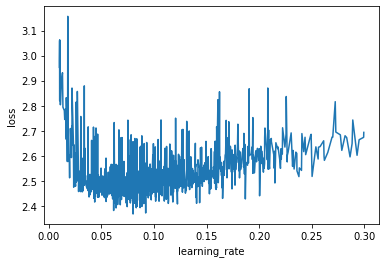

In [13]:
loss_plot('learning_rate', TRIALS)

Loss plot for parameter minibatch_frac


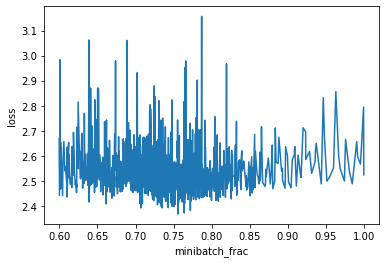

In [14]:
loss_plot('minibatch_frac', TRIALS)

Loss plot for parameter Base


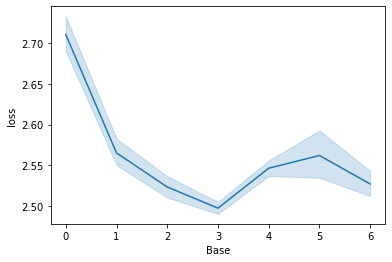

In [15]:
loss_plot('Base', TRIALS)

Loss plot for parameter n_estimators


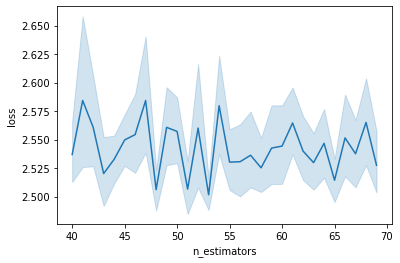

In [16]:
loss_plot('n_estimators', TRIALS)

## Train a final model
Increasing the number of boosters by increasing n_estimators

In [17]:
default_params = {"n_estimators":60,
                  "verbose_eval":1,
                  "random_state":1}

best_params.update(default_params)

ngb = NGBRegressor(**best_params).fit(X_train,y_train,X_val=X_validation, Y_val=y_validation, early_stopping_rounds=10)

[iter 0] loss=3.5776 val_loss=3.5039 scale=1.0000 norm=6.5252
[iter 1] loss=3.4444 val_loss=3.3515 scale=2.0000 norm=11.9917
[iter 2] loss=3.3070 val_loss=3.2630 scale=2.0000 norm=10.6069
[iter 3] loss=3.2064 val_loss=3.1863 scale=2.0000 norm=9.0763
[iter 4] loss=3.1085 val_loss=3.1193 scale=2.0000 norm=7.6472
[iter 5] loss=3.0445 val_loss=3.0470 scale=2.0000 norm=7.0622
[iter 6] loss=2.9682 val_loss=2.9818 scale=2.0000 norm=6.2778
[iter 7] loss=2.8971 val_loss=2.9138 scale=2.0000 norm=5.6303
[iter 8] loss=2.8271 val_loss=2.8499 scale=2.0000 norm=5.1343
[iter 9] loss=2.7428 val_loss=2.7921 scale=2.0000 norm=4.4105
[iter 10] loss=2.6815 val_loss=2.7385 scale=2.0000 norm=4.1873
[iter 11] loss=2.6066 val_loss=2.6825 scale=2.0000 norm=3.8338
[iter 12] loss=2.5446 val_loss=2.6325 scale=2.0000 norm=3.5238
[iter 13] loss=2.4638 val_loss=2.5893 scale=2.0000 norm=3.2118
[iter 14] loss=2.4156 val_loss=2.5500 scale=2.0000 norm=3.0893
[iter 15] loss=2.3345 val_loss=2.5166 scale=2.0000 norm=2.8459


## Evaluate on a test set

In [18]:
Y_pred = ngb.predict(X_test)
Y_dist = ngb.pred_dist(X_test)

In [19]:
Mae = median_absolute_error(y_test, Y_pred)
logger.info(f"Median Absolute Error = {Mae}")

mea = mean_absolute_error(y_test, Y_pred)
logger.info(f"Mean Absolute Error = {mea}")

2021-01-12 23:24:40 INFO     Median Absolute Error = 1.5756856391316028
2021-01-12 23:24:40 INFO     Mean Absolute Error = 2.198666126029358


Text(336.9714285714286, 0.5, 'Predictions [Hours]')

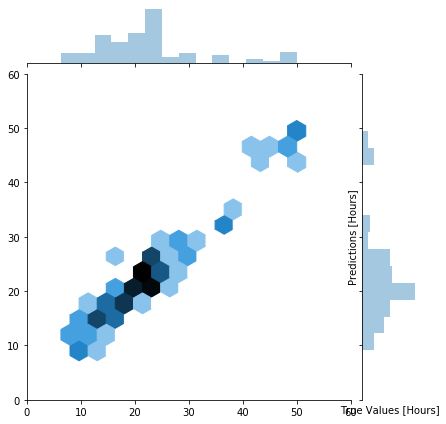

In [21]:
samp_low = 0
samp_high = 60

# a = plt.axes(aspect="equal")
sns.jointplot(y_test[(y_test > samp_low) & (y_test < samp_high)], Y_pred[(y_test > samp_low) & (y_test < samp_high)], kind="hexbin", bins="log", xlim=(samp_low,samp_high), ylim=(samp_low, samp_high))
# plt.scatter(y_samp, y_pred)
plt.xlabel("True Values [Hours]")
plt.ylabel("Predictions [Hours]")

In [26]:
pred_dist = ngb.staged_pred_dist(X_test)

In [27]:
len(pred_dist)

30

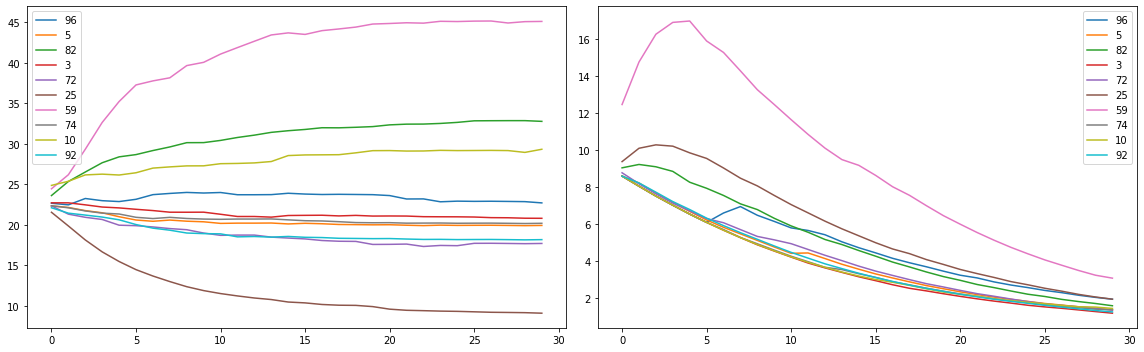

In [29]:
# Plot evolution of parameters for select test points
npars = 10
ii = np.random.choice(len(X_test), npars)
par_evol = np.array([(p[ii].params['loc'], p[ii].params['scale']) for p in pred_dist])
par_evol.shape

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5*1))
axs = axs.flatten()
for i in range(npars):
    axs[0].plot(par_evol[:, 0, i], label=ii[i])
    axs[1].plot(par_evol[:, 1, i], label=ii[i])
    #axs[0].set_xlim(200,)
    #axs[1].set_xlim(200,)
    #axs[1].set_ylim(0, 4)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()